# Miller age

In [1]:
ood_seed = 8

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "dataset_complete_Miller.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["age"] = adata.obs["age"].astype("str").astype("category")

adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
adata.obs["age_int"] = adata.obs["age"].astype(str).astype(float).astype(int).astype(str).astype("category")

adata.obs["age_continuous"] = adata.obs["age"].astype(float)
df = adata.obs.groupby(["cell_type", "age"]).size()
df2 = adata.obs.groupby(["cell_type"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 100 and df2[i[0]] > 350]

In [7]:
df

cell_type                            age 
Bud tip adjacent cells               11.5    169
                                     15.0    282
                                     18.0    777
                                     21.0      0
Bud tip progenitor                   11.5    273
                                     15.0    338
                                     18.0    683
                                     21.0      2
Deuterosomal cells                   11.5      2
                                     15.0    145
                                     18.0    111
                                     21.0     49
Hub cells                            11.5    218
                                     15.0    308
                                     18.0    620
                                     21.0      2
Intermediate trachea ciliated cells  11.5      0
                                     15.0     59
                                     18.0      0
                           

In [8]:
availables, len(availables)

([(('Bud tip adjacent cells', '11.5'), 169),
  (('Bud tip adjacent cells', '15.0'), 282),
  (('Bud tip adjacent cells', '18.0'), 777),
  (('Bud tip progenitor', '11.5'), 273),
  (('Bud tip progenitor', '15.0'), 338),
  (('Bud tip progenitor', '18.0'), 683),
  (('Hub cells', '11.5'), 218),
  (('Hub cells', '15.0'), 308),
  (('Hub cells', '18.0'), 620),
  (('Lung ciliated cells', '15.0'), 692),
  (('Lung ciliated cells', '18.0'), 494),
  (('Lung ciliated cells', '21.0'), 165),
  (('Lung secretory cells', '15.0'), 595),
  (('Lung secretory cells', '21.0'), 438),
  (('Submucosal gland cells', '15.0'), 380),
  (('Submucosal gland cells', '18.0'), 156)],
 16)

In [9]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask


def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["cell_type"] == choice[0][0]) & (adata.obs["age"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

(('Hub cells', '18.0'), 620)


Removed datapoint: 620

train         5470
validation    1315
ood            620
Name: split, dtype: int64

In [10]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [11]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="age_int",
    control_group="11",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['integration_donor'],
)

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 96875.66it/s]

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 928070.91it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [12]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [13]:
model.train(max_epochs=400)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 196.81it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:04<32:11,  4.84s/it]

Epoch 1/400:   0%|          | 1/400 [00:04<32:11,  4.84s/it, v_num=1, recon=1.24e+3, r2_mean=0.0603, adv_loss=3.39, acc_pert=0.335, acc_integration_donor=0.148]

Epoch 2/400:   0%|          | 1/400 [00:04<32:11,  4.84s/it, v_num=1, recon=1.24e+3, r2_mean=0.0603, adv_loss=3.39, acc_pert=0.335, acc_integration_donor=0.148]

Epoch 2/400:   0%|          | 2/400 [00:07<23:57,  3.61s/it, v_num=1, recon=1.24e+3, r2_mean=0.0603, adv_loss=3.39, acc_pert=0.335, acc_integration_donor=0.148]

Epoch 2/400:   0%|          | 2/400 [00:07<23:57,  3.61s/it, v_num=1, recon=1.04e+3, r2_mean=0.294, adv_loss=3.01, acc_pert=0.461, acc_integration_donor=0.302] 

Epoch 3/400:   0%|          | 2/400 [00:07<23:57,  3.61s/it, v_num=1, recon=1.04e+3, r2_mean=0.294, adv_loss=3.01, acc_pert=0.461, acc_integration_donor=0.302]

Epoch 3/400:   1%|          | 3/400 [00:10<20:21,  3.08s/it, v_num=1, recon=1.04e+3, r2_mean=0.294, adv_loss=3.01, acc_pert=0.461, acc_integration_donor=0.302]

Epoch 3/400:   1%|          | 3/400 [00:10<20:21,  3.08s/it, v_num=1, recon=964, r2_mean=0.393, adv_loss=2.67, acc_pert=0.506, acc_integration_donor=0.425]    

Epoch 4/400:   1%|          | 3/400 [00:10<20:21,  3.08s/it, v_num=1, recon=964, r2_mean=0.393, adv_loss=2.67, acc_pert=0.506, acc_integration_donor=0.425]

Epoch 4/400:   1%|          | 4/400 [00:12<19:20,  2.93s/it, v_num=1, recon=964, r2_mean=0.393, adv_loss=2.67, acc_pert=0.506, acc_integration_donor=0.425]

Epoch 4/400:   1%|          | 4/400 [00:12<19:20,  2.93s/it, v_num=1, recon=928, r2_mean=0.446, adv_loss=2.44, acc_pert=0.52, acc_integration_donor=0.495] 

Epoch 5/400:   1%|          | 4/400 [00:12<19:20,  2.93s/it, v_num=1, recon=928, r2_mean=0.446, adv_loss=2.44, acc_pert=0.52, acc_integration_donor=0.495]

Epoch 5/400:   1%|▏         | 5/400 [00:15<18:35,  2.82s/it, v_num=1, recon=928, r2_mean=0.446, adv_loss=2.44, acc_pert=0.52, acc_integration_donor=0.495]

Epoch 5/400:   1%|▏         | 5/400 [00:15<18:35,  2.82s/it, v_num=1, recon=908, r2_mean=0.471, adv_loss=2.34, acc_pert=0.535, acc_integration_donor=0.512]

Epoch 6/400:   1%|▏         | 5/400 [00:15<18:35,  2.82s/it, v_num=1, recon=908, r2_mean=0.471, adv_loss=2.34, acc_pert=0.535, acc_integration_donor=0.512]

Epoch 6/400:   2%|▏         | 6/400 [00:17<17:47,  2.71s/it, v_num=1, recon=908, r2_mean=0.471, adv_loss=2.34, acc_pert=0.535, acc_integration_donor=0.512]

Epoch 6/400:   2%|▏         | 6/400 [00:17<17:47,  2.71s/it, v_num=1, recon=895, r2_mean=0.475, adv_loss=2.27, acc_pert=0.544, acc_integration_donor=0.52] 

Epoch 7/400:   2%|▏         | 6/400 [00:17<17:47,  2.71s/it, v_num=1, recon=895, r2_mean=0.475, adv_loss=2.27, acc_pert=0.544, acc_integration_donor=0.52]

Epoch 7/400:   2%|▏         | 7/400 [00:20<17:06,  2.61s/it, v_num=1, recon=895, r2_mean=0.475, adv_loss=2.27, acc_pert=0.544, acc_integration_donor=0.52]

Epoch 7/400:   2%|▏         | 7/400 [00:20<17:06,  2.61s/it, v_num=1, recon=887, r2_mean=0.488, adv_loss=2.23, acc_pert=0.542, acc_integration_donor=0.525]

Epoch 8/400:   2%|▏         | 7/400 [00:20<17:06,  2.61s/it, v_num=1, recon=887, r2_mean=0.488, adv_loss=2.23, acc_pert=0.542, acc_integration_donor=0.525]

Epoch 8/400:   2%|▏         | 8/400 [00:22<16:35,  2.54s/it, v_num=1, recon=887, r2_mean=0.488, adv_loss=2.23, acc_pert=0.542, acc_integration_donor=0.525]

Epoch 8/400:   2%|▏         | 8/400 [00:22<16:35,  2.54s/it, v_num=1, recon=880, r2_mean=0.492, adv_loss=2.19, acc_pert=0.548, acc_integration_donor=0.525]

Epoch 9/400:   2%|▏         | 8/400 [00:22<16:35,  2.54s/it, v_num=1, recon=880, r2_mean=0.492, adv_loss=2.19, acc_pert=0.548, acc_integration_donor=0.525]

Epoch 9/400:   2%|▏         | 9/400 [00:25<16:18,  2.50s/it, v_num=1, recon=880, r2_mean=0.492, adv_loss=2.19, acc_pert=0.548, acc_integration_donor=0.525]

Epoch 9/400:   2%|▏         | 9/400 [00:25<16:18,  2.50s/it, v_num=1, recon=874, r2_mean=0.503, adv_loss=2.17, acc_pert=0.554, acc_integration_donor=0.526]

Epoch 10/400:   2%|▏         | 9/400 [00:25<16:18,  2.50s/it, v_num=1, recon=874, r2_mean=0.503, adv_loss=2.17, acc_pert=0.554, acc_integration_donor=0.526]


disnt_basal = 0.5268056151193301

disnt_after = 0.9007767430602438

val_r2_mean = 0.5158096199685877

val_r2_var = 0.2000794471664862


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [00:30<22:50,  3.51s/it, v_num=1, recon=874, r2_mean=0.503, adv_loss=2.17, acc_pert=0.554, acc_integration_donor=0.526]

Epoch 10/400:   2%|▎         | 10/400 [00:30<22:50,  3.51s/it, v_num=1, recon=869, r2_mean=0.505, adv_loss=2.14, acc_pert=0.568, acc_integration_donor=0.519, val_recon=912, disnt_basal=0.527, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [00:30<22:50,  3.51s/it, v_num=1, recon=869, r2_mean=0.505, adv_loss=2.14, acc_pert=0.568, acc_integration_donor=0.519, val_recon=912, disnt_basal=0.527, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:33<20:38,  3.18s/it, v_num=1, recon=869, r2_mean=0.505, adv_loss=2.14, acc_pert=0.568, acc_integration_donor=0.519, val_recon=912, disnt_basal=0.527, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:33<20:38,  3.18s/it, v_num=1, recon=865, r2_mean=0.513, adv_loss=2.15, acc_pert=0.559, acc_integration_donor=0.525, val_recon=912, disnt_basal=0.527, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [00:33<20:38,  3.18s/it, v_num=1, recon=865, r2_mean=0.513, adv_loss=2.15, acc_pert=0.559, acc_integration_donor=0.525, val_recon=912, disnt_basal=0.527, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:35<19:18,  2.99s/it, v_num=1, recon=865, r2_mean=0.513, adv_loss=2.15, acc_pert=0.559, acc_integration_donor=0.525, val_recon=912, disnt_basal=0.527, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:35<19:18,  2.99s/it, v_num=1, recon=861, r2_mean=0.514, adv_loss=2.13, acc_pert=0.58, acc_integration_donor=0.526, val_recon=912, disnt_basal=0.527, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan] 

Epoch 13/400:   3%|▎         | 12/400 [00:35<19:18,  2.99s/it, v_num=1, recon=861, r2_mean=0.514, adv_loss=2.13, acc_pert=0.58, acc_integration_donor=0.526, val_recon=912, disnt_basal=0.527, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:38<18:14,  2.83s/it, v_num=1, recon=861, r2_mean=0.514, adv_loss=2.13, acc_pert=0.58, acc_integration_donor=0.526, val_recon=912, disnt_basal=0.527, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:38<18:14,  2.83s/it, v_num=1, recon=859, r2_mean=0.52, adv_loss=2.12, acc_pert=0.57, acc_integration_donor=0.518, val_recon=912, disnt_basal=0.527, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan] 

Epoch 14/400:   3%|▎         | 13/400 [00:38<18:14,  2.83s/it, v_num=1, recon=859, r2_mean=0.52, adv_loss=2.12, acc_pert=0.57, acc_integration_donor=0.518, val_recon=912, disnt_basal=0.527, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:40<17:21,  2.70s/it, v_num=1, recon=859, r2_mean=0.52, adv_loss=2.12, acc_pert=0.57, acc_integration_donor=0.518, val_recon=912, disnt_basal=0.527, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:40<17:21,  2.70s/it, v_num=1, recon=854, r2_mean=0.526, adv_loss=2.11, acc_pert=0.568, acc_integration_donor=0.535, val_recon=912, disnt_basal=0.527, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [00:40<17:21,  2.70s/it, v_num=1, recon=854, r2_mean=0.526, adv_loss=2.11, acc_pert=0.568, acc_integration_donor=0.535, val_recon=912, disnt_basal=0.527, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:43<17:04,  2.66s/it, v_num=1, recon=854, r2_mean=0.526, adv_loss=2.11, acc_pert=0.568, acc_integration_donor=0.535, val_recon=912, disnt_basal=0.527, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:43<17:04,  2.66s/it, v_num=1, recon=851, r2_mean=0.53, adv_loss=2.14, acc_pert=0.562, acc_integration_donor=0.521, val_recon=912, disnt_basal=0.527, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan] 

Epoch 16/400:   4%|▍         | 15/400 [00:43<17:04,  2.66s/it, v_num=1, recon=851, r2_mean=0.53, adv_loss=2.14, acc_pert=0.562, acc_integration_donor=0.521, val_recon=912, disnt_basal=0.527, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:45<16:32,  2.58s/it, v_num=1, recon=851, r2_mean=0.53, adv_loss=2.14, acc_pert=0.562, acc_integration_donor=0.521, val_recon=912, disnt_basal=0.527, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:45<16:32,  2.58s/it, v_num=1, recon=849, r2_mean=0.534, adv_loss=2.15, acc_pert=0.562, acc_integration_donor=0.525, val_recon=912, disnt_basal=0.527, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [00:45<16:32,  2.58s/it, v_num=1, recon=849, r2_mean=0.534, adv_loss=2.15, acc_pert=0.562, acc_integration_donor=0.525, val_recon=912, disnt_basal=0.527, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [00:48<16:09,  2.53s/it, v_num=1, recon=849, r2_mean=0.534, adv_loss=2.15, acc_pert=0.562, acc_integration_donor=0.525, val_recon=912, disnt_basal=0.527, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [00:48<16:09,  2.53s/it, v_num=1, recon=847, r2_mean=0.537, adv_loss=2.15, acc_pert=0.557, acc_integration_donor=0.522, val_recon=912, disnt_basal=0.527, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [00:48<16:09,  2.53s/it, v_num=1, recon=847, r2_mean=0.537, adv_loss=2.15, acc_pert=0.557, acc_integration_donor=0.522, val_recon=912, disnt_basal=0.527, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [00:51<17:23,  2.73s/it, v_num=1, recon=847, r2_mean=0.537, adv_loss=2.15, acc_pert=0.557, acc_integration_donor=0.522, val_recon=912, disnt_basal=0.527, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [00:51<17:23,  2.73s/it, v_num=1, recon=844, r2_mean=0.54, adv_loss=2.14, acc_pert=0.548, acc_integration_donor=0.528, val_recon=912, disnt_basal=0.527, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan] 

Epoch 19/400:   4%|▍         | 18/400 [00:51<17:23,  2.73s/it, v_num=1, recon=844, r2_mean=0.54, adv_loss=2.14, acc_pert=0.548, acc_integration_donor=0.528, val_recon=912, disnt_basal=0.527, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [00:53<16:56,  2.67s/it, v_num=1, recon=844, r2_mean=0.54, adv_loss=2.14, acc_pert=0.548, acc_integration_donor=0.528, val_recon=912, disnt_basal=0.527, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [00:53<16:56,  2.67s/it, v_num=1, recon=843, r2_mean=0.538, adv_loss=2.16, acc_pert=0.546, acc_integration_donor=0.517, val_recon=912, disnt_basal=0.527, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [00:53<16:56,  2.67s/it, v_num=1, recon=843, r2_mean=0.538, adv_loss=2.16, acc_pert=0.546, acc_integration_donor=0.517, val_recon=912, disnt_basal=0.527, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]


disnt_basal = 0.5157284430310002

disnt_after = 0.9176509909151004

val_r2_mean = 0.5143420337276026

val_r2_var = 0.2961459424008023


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [00:58<21:02,  3.32s/it, v_num=1, recon=843, r2_mean=0.538, adv_loss=2.16, acc_pert=0.546, acc_integration_donor=0.517, val_recon=912, disnt_basal=0.527, disnt_after=0.901, val_r2_mean=0.516, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [00:58<21:02,  3.32s/it, v_num=1, recon=841, r2_mean=0.541, adv_loss=2.16, acc_pert=0.549, acc_integration_donor=0.513, val_recon=866, disnt_basal=0.516, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 21/400:   5%|▌         | 20/400 [00:58<21:02,  3.32s/it, v_num=1, recon=841, r2_mean=0.541, adv_loss=2.16, acc_pert=0.549, acc_integration_donor=0.513, val_recon=866, disnt_basal=0.516, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:01<19:18,  3.06s/it, v_num=1, recon=841, r2_mean=0.541, adv_loss=2.16, acc_pert=0.549, acc_integration_donor=0.513, val_recon=866, disnt_basal=0.516, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:01<19:18,  3.06s/it, v_num=1, recon=838, r2_mean=0.548, adv_loss=2.17, acc_pert=0.535, acc_integration_donor=0.516, val_recon=866, disnt_basal=0.516, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [01:01<19:18,  3.06s/it, v_num=1, recon=838, r2_mean=0.548, adv_loss=2.17, acc_pert=0.535, acc_integration_donor=0.516, val_recon=866, disnt_basal=0.516, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:03<18:03,  2.87s/it, v_num=1, recon=838, r2_mean=0.548, adv_loss=2.17, acc_pert=0.535, acc_integration_donor=0.516, val_recon=866, disnt_basal=0.516, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:03<18:03,  2.87s/it, v_num=1, recon=837, r2_mean=0.548, adv_loss=2.16, acc_pert=0.54, acc_integration_donor=0.52, val_recon=866, disnt_basal=0.516, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]  

Epoch 23/400:   6%|▌         | 22/400 [01:03<18:03,  2.87s/it, v_num=1, recon=837, r2_mean=0.548, adv_loss=2.16, acc_pert=0.54, acc_integration_donor=0.52, val_recon=866, disnt_basal=0.516, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:06<17:50,  2.84s/it, v_num=1, recon=837, r2_mean=0.548, adv_loss=2.16, acc_pert=0.54, acc_integration_donor=0.52, val_recon=866, disnt_basal=0.516, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:06<17:50,  2.84s/it, v_num=1, recon=835, r2_mean=0.547, adv_loss=2.16, acc_pert=0.54, acc_integration_donor=0.512, val_recon=866, disnt_basal=0.516, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [01:06<17:50,  2.84s/it, v_num=1, recon=835, r2_mean=0.547, adv_loss=2.16, acc_pert=0.54, acc_integration_donor=0.512, val_recon=866, disnt_basal=0.516, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:08<17:11,  2.74s/it, v_num=1, recon=835, r2_mean=0.547, adv_loss=2.16, acc_pert=0.54, acc_integration_donor=0.512, val_recon=866, disnt_basal=0.516, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:08<17:11,  2.74s/it, v_num=1, recon=834, r2_mean=0.546, adv_loss=2.15, acc_pert=0.554, acc_integration_donor=0.526, val_recon=866, disnt_basal=0.516, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [01:08<17:11,  2.74s/it, v_num=1, recon=834, r2_mean=0.546, adv_loss=2.15, acc_pert=0.554, acc_integration_donor=0.526, val_recon=866, disnt_basal=0.516, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:11<16:51,  2.70s/it, v_num=1, recon=834, r2_mean=0.546, adv_loss=2.15, acc_pert=0.554, acc_integration_donor=0.526, val_recon=866, disnt_basal=0.516, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:11<16:51,  2.70s/it, v_num=1, recon=832, r2_mean=0.552, adv_loss=2.16, acc_pert=0.548, acc_integration_donor=0.517, val_recon=866, disnt_basal=0.516, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [01:11<16:51,  2.70s/it, v_num=1, recon=832, r2_mean=0.552, adv_loss=2.16, acc_pert=0.548, acc_integration_donor=0.517, val_recon=866, disnt_basal=0.516, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:13<16:16,  2.61s/it, v_num=1, recon=832, r2_mean=0.552, adv_loss=2.16, acc_pert=0.548, acc_integration_donor=0.517, val_recon=866, disnt_basal=0.516, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:13<16:16,  2.61s/it, v_num=1, recon=831, r2_mean=0.551, adv_loss=2.17, acc_pert=0.541, acc_integration_donor=0.515, val_recon=866, disnt_basal=0.516, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [01:13<16:16,  2.61s/it, v_num=1, recon=831, r2_mean=0.551, adv_loss=2.17, acc_pert=0.541, acc_integration_donor=0.515, val_recon=866, disnt_basal=0.516, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:16<16:11,  2.61s/it, v_num=1, recon=831, r2_mean=0.551, adv_loss=2.17, acc_pert=0.541, acc_integration_donor=0.515, val_recon=866, disnt_basal=0.516, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:16<16:11,  2.61s/it, v_num=1, recon=829, r2_mean=0.561, adv_loss=2.15, acc_pert=0.545, acc_integration_donor=0.527, val_recon=866, disnt_basal=0.516, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [01:16<16:11,  2.61s/it, v_num=1, recon=829, r2_mean=0.561, adv_loss=2.15, acc_pert=0.545, acc_integration_donor=0.527, val_recon=866, disnt_basal=0.516, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:19<16:17,  2.63s/it, v_num=1, recon=829, r2_mean=0.561, adv_loss=2.15, acc_pert=0.545, acc_integration_donor=0.527, val_recon=866, disnt_basal=0.516, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:19<16:17,  2.63s/it, v_num=1, recon=828, r2_mean=0.555, adv_loss=2.17, acc_pert=0.54, acc_integration_donor=0.522, val_recon=866, disnt_basal=0.516, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan] 

Epoch 29/400:   7%|▋         | 28/400 [01:19<16:17,  2.63s/it, v_num=1, recon=828, r2_mean=0.555, adv_loss=2.17, acc_pert=0.54, acc_integration_donor=0.522, val_recon=866, disnt_basal=0.516, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:21<16:04,  2.60s/it, v_num=1, recon=828, r2_mean=0.555, adv_loss=2.17, acc_pert=0.54, acc_integration_donor=0.522, val_recon=866, disnt_basal=0.516, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:21<16:04,  2.60s/it, v_num=1, recon=827, r2_mean=0.555, adv_loss=2.19, acc_pert=0.532, acc_integration_donor=0.521, val_recon=866, disnt_basal=0.516, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 30/400:   7%|▋         | 29/400 [01:21<16:04,  2.60s/it, v_num=1, recon=827, r2_mean=0.555, adv_loss=2.19, acc_pert=0.532, acc_integration_donor=0.521, val_recon=866, disnt_basal=0.516, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]


disnt_basal = 0.4905736577560923

disnt_after = 0.9249932432146242

val_r2_mean = 0.5161471407521855

val_r2_var = 0.3451126034964215


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [01:29<25:40,  4.16s/it, v_num=1, recon=827, r2_mean=0.555, adv_loss=2.19, acc_pert=0.532, acc_integration_donor=0.521, val_recon=866, disnt_basal=0.516, disnt_after=0.918, val_r2_mean=0.514, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [01:29<25:40,  4.16s/it, v_num=1, recon=826, r2_mean=0.559, adv_loss=2.19, acc_pert=0.536, acc_integration_donor=0.519, val_recon=863, disnt_basal=0.491, disnt_after=0.925, val_r2_mean=0.516, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [01:29<25:40,  4.16s/it, v_num=1, recon=826, r2_mean=0.559, adv_loss=2.19, acc_pert=0.536, acc_integration_donor=0.519, val_recon=863, disnt_basal=0.491, disnt_after=0.925, val_r2_mean=0.516, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [01:31<22:25,  3.65s/it, v_num=1, recon=826, r2_mean=0.559, adv_loss=2.19, acc_pert=0.536, acc_integration_donor=0.519, val_recon=863, disnt_basal=0.491, disnt_after=0.925, val_r2_mean=0.516, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [01:31<22:25,  3.65s/it, v_num=1, recon=825, r2_mean=0.557, adv_loss=2.18, acc_pert=0.542, acc_integration_donor=0.526, val_recon=863, disnt_basal=0.491, disnt_after=0.925, val_r2_mean=0.516, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [01:31<22:25,  3.65s/it, v_num=1, recon=825, r2_mean=0.557, adv_loss=2.18, acc_pert=0.542, acc_integration_donor=0.526, val_recon=863, disnt_basal=0.491, disnt_after=0.925, val_r2_mean=0.516, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [01:34<20:22,  3.32s/it, v_num=1, recon=825, r2_mean=0.557, adv_loss=2.18, acc_pert=0.542, acc_integration_donor=0.526, val_recon=863, disnt_basal=0.491, disnt_after=0.925, val_r2_mean=0.516, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [01:34<20:22,  3.32s/it, v_num=1, recon=824, r2_mean=0.558, adv_loss=2.21, acc_pert=0.529, acc_integration_donor=0.515, val_recon=863, disnt_basal=0.491, disnt_after=0.925, val_r2_mean=0.516, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [01:34<20:22,  3.32s/it, v_num=1, recon=824, r2_mean=0.558, adv_loss=2.21, acc_pert=0.529, acc_integration_donor=0.515, val_recon=863, disnt_basal=0.491, disnt_after=0.925, val_r2_mean=0.516, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [01:37<19:16,  3.15s/it, v_num=1, recon=824, r2_mean=0.558, adv_loss=2.21, acc_pert=0.529, acc_integration_donor=0.515, val_recon=863, disnt_basal=0.491, disnt_after=0.925, val_r2_mean=0.516, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [01:37<19:16,  3.15s/it, v_num=1, recon=822, r2_mean=0.56, adv_loss=2.19, acc_pert=0.531, acc_integration_donor=0.519, val_recon=863, disnt_basal=0.491, disnt_after=0.925, val_r2_mean=0.516, val_KL=nan] 

Epoch 34/400:   8%|▊         | 33/400 [01:37<19:16,  3.15s/it, v_num=1, recon=822, r2_mean=0.56, adv_loss=2.19, acc_pert=0.531, acc_integration_donor=0.519, val_recon=863, disnt_basal=0.491, disnt_after=0.925, val_r2_mean=0.516, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [01:40<18:39,  3.06s/it, v_num=1, recon=822, r2_mean=0.56, adv_loss=2.19, acc_pert=0.531, acc_integration_donor=0.519, val_recon=863, disnt_basal=0.491, disnt_after=0.925, val_r2_mean=0.516, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [01:40<18:39,  3.06s/it, v_num=1, recon=820, r2_mean=0.56, adv_loss=2.2, acc_pert=0.535, acc_integration_donor=0.515, val_recon=863, disnt_basal=0.491, disnt_after=0.925, val_r2_mean=0.516, val_KL=nan] 

Epoch 35/400:   8%|▊         | 34/400 [01:40<18:39,  3.06s/it, v_num=1, recon=820, r2_mean=0.56, adv_loss=2.2, acc_pert=0.535, acc_integration_donor=0.515, val_recon=863, disnt_basal=0.491, disnt_after=0.925, val_r2_mean=0.516, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [01:42<18:08,  2.98s/it, v_num=1, recon=820, r2_mean=0.56, adv_loss=2.2, acc_pert=0.535, acc_integration_donor=0.515, val_recon=863, disnt_basal=0.491, disnt_after=0.925, val_r2_mean=0.516, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [01:42<18:08,  2.98s/it, v_num=1, recon=820, r2_mean=0.563, adv_loss=2.21, acc_pert=0.515, acc_integration_donor=0.517, val_recon=863, disnt_basal=0.491, disnt_after=0.925, val_r2_mean=0.516, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [01:42<18:08,  2.98s/it, v_num=1, recon=820, r2_mean=0.563, adv_loss=2.21, acc_pert=0.515, acc_integration_donor=0.517, val_recon=863, disnt_basal=0.491, disnt_after=0.925, val_r2_mean=0.516, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [01:45<17:22,  2.86s/it, v_num=1, recon=820, r2_mean=0.563, adv_loss=2.21, acc_pert=0.515, acc_integration_donor=0.517, val_recon=863, disnt_basal=0.491, disnt_after=0.925, val_r2_mean=0.516, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [01:45<17:22,  2.86s/it, v_num=1, recon=818, r2_mean=0.565, adv_loss=2.21, acc_pert=0.525, acc_integration_donor=0.513, val_recon=863, disnt_basal=0.491, disnt_after=0.925, val_r2_mean=0.516, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [01:45<17:22,  2.86s/it, v_num=1, recon=818, r2_mean=0.565, adv_loss=2.21, acc_pert=0.525, acc_integration_donor=0.513, val_recon=863, disnt_basal=0.491, disnt_after=0.925, val_r2_mean=0.516, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [01:48<16:57,  2.80s/it, v_num=1, recon=818, r2_mean=0.565, adv_loss=2.21, acc_pert=0.525, acc_integration_donor=0.513, val_recon=863, disnt_basal=0.491, disnt_after=0.925, val_r2_mean=0.516, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [01:48<16:57,  2.80s/it, v_num=1, recon=819, r2_mean=0.566, adv_loss=2.23, acc_pert=0.527, acc_integration_donor=0.505, val_recon=863, disnt_basal=0.491, disnt_after=0.925, val_r2_mean=0.516, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [01:48<16:57,  2.80s/it, v_num=1, recon=819, r2_mean=0.566, adv_loss=2.23, acc_pert=0.527, acc_integration_donor=0.505, val_recon=863, disnt_basal=0.491, disnt_after=0.925, val_r2_mean=0.516, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [01:50<16:14,  2.69s/it, v_num=1, recon=819, r2_mean=0.566, adv_loss=2.23, acc_pert=0.527, acc_integration_donor=0.505, val_recon=863, disnt_basal=0.491, disnt_after=0.925, val_r2_mean=0.516, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [01:50<16:14,  2.69s/it, v_num=1, recon=817, r2_mean=0.565, adv_loss=2.23, acc_pert=0.528, acc_integration_donor=0.507, val_recon=863, disnt_basal=0.491, disnt_after=0.925, val_r2_mean=0.516, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [01:50<16:14,  2.69s/it, v_num=1, recon=817, r2_mean=0.565, adv_loss=2.23, acc_pert=0.528, acc_integration_donor=0.507, val_recon=863, disnt_basal=0.491, disnt_after=0.925, val_r2_mean=0.516, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [01:52<15:47,  2.62s/it, v_num=1, recon=817, r2_mean=0.565, adv_loss=2.23, acc_pert=0.528, acc_integration_donor=0.507, val_recon=863, disnt_basal=0.491, disnt_after=0.925, val_r2_mean=0.516, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [01:52<15:47,  2.62s/it, v_num=1, recon=817, r2_mean=0.567, adv_loss=2.24, acc_pert=0.527, acc_integration_donor=0.505, val_recon=863, disnt_basal=0.491, disnt_after=0.925, val_r2_mean=0.516, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [01:52<15:47,  2.62s/it, v_num=1, recon=817, r2_mean=0.567, adv_loss=2.24, acc_pert=0.527, acc_integration_donor=0.505, val_recon=863, disnt_basal=0.491, disnt_after=0.925, val_r2_mean=0.516, val_KL=nan]


disnt_basal = 0.4954666383013178

disnt_after = 0.9253178198897056

val_r2_mean = 0.5079881968823347

val_r2_var = 0.35194953124631534

Epoch 40/400:  10%|█         | 40/400 [01:59<21:55,  3.65s/it, v_num=1, recon=817, r2_mean=0.567, adv_loss=2.24, acc_pert=0.527, acc_integration_donor=0.505, val_recon=863, disnt_basal=0.491, disnt_after=0.925, val_r2_mean=0.516, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [01:59<21:55,  3.65s/it, v_num=1, recon=815, r2_mean=0.569, adv_loss=2.23, acc_pert=0.526, acc_integration_donor=0.504, val_recon=861, disnt_basal=0.495, disnt_after=0.925, val_r2_mean=0.508, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [01:59<21:55,  3.65s/it, v_num=1, recon=815, r2_mean=0.569, adv_loss=2.23, acc_pert=0.526, acc_integration_donor=0.504, val_recon=861, disnt_basal=0.495, disnt_after=0.925, val_r2_mean=0.508, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [02:01<20:03,  3.35s/it, v_num=1, recon=815, r2_mean=0.569, adv_loss=2.23, acc_pert=0.526, acc_integration_donor=0.504, val_recon=861, disnt_basal=0.495, disnt_after=0.925, val_r2_mean=0.508, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [02:01<20:03,  3.35s/it, v_num=1, recon=815, r2_mean=0.57, adv_loss=2.25, acc_pert=0.521, acc_integration_donor=0.507, val_recon=861, disnt_basal=0.495, disnt_after=0.925, val_r2_mean=0.508, val_KL=nan] 

Epoch 42/400:  10%|█         | 41/400 [02:01<20:03,  3.35s/it, v_num=1, recon=815, r2_mean=0.57, adv_loss=2.25, acc_pert=0.521, acc_integration_donor=0.507, val_recon=861, disnt_basal=0.495, disnt_after=0.925, val_r2_mean=0.508, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [02:07<25:01,  4.20s/it, v_num=1, recon=815, r2_mean=0.57, adv_loss=2.25, acc_pert=0.521, acc_integration_donor=0.507, val_recon=861, disnt_basal=0.495, disnt_after=0.925, val_r2_mean=0.508, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [02:07<25:01,  4.20s/it, v_num=1, recon=813, r2_mean=0.571, adv_loss=2.24, acc_pert=0.514, acc_integration_donor=0.514, val_recon=861, disnt_basal=0.495, disnt_after=0.925, val_r2_mean=0.508, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [02:07<25:01,  4.20s/it, v_num=1, recon=813, r2_mean=0.571, adv_loss=2.24, acc_pert=0.514, acc_integration_donor=0.514, val_recon=861, disnt_basal=0.495, disnt_after=0.925, val_r2_mean=0.508, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [02:11<23:33,  3.96s/it, v_num=1, recon=813, r2_mean=0.571, adv_loss=2.24, acc_pert=0.514, acc_integration_donor=0.514, val_recon=861, disnt_basal=0.495, disnt_after=0.925, val_r2_mean=0.508, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [02:11<23:33,  3.96s/it, v_num=1, recon=812, r2_mean=0.566, adv_loss=2.24, acc_pert=0.526, acc_integration_donor=0.503, val_recon=861, disnt_basal=0.495, disnt_after=0.925, val_r2_mean=0.508, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [02:11<23:33,  3.96s/it, v_num=1, recon=812, r2_mean=0.566, adv_loss=2.24, acc_pert=0.526, acc_integration_donor=0.503, val_recon=861, disnt_basal=0.495, disnt_after=0.925, val_r2_mean=0.508, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [02:13<21:01,  3.54s/it, v_num=1, recon=812, r2_mean=0.566, adv_loss=2.24, acc_pert=0.526, acc_integration_donor=0.503, val_recon=861, disnt_basal=0.495, disnt_after=0.925, val_r2_mean=0.508, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [02:13<21:01,  3.54s/it, v_num=1, recon=811, r2_mean=0.57, adv_loss=2.26, acc_pert=0.52, acc_integration_donor=0.506, val_recon=861, disnt_basal=0.495, disnt_after=0.925, val_r2_mean=0.508, val_KL=nan]  

Epoch 45/400:  11%|█         | 44/400 [02:13<21:01,  3.54s/it, v_num=1, recon=811, r2_mean=0.57, adv_loss=2.26, acc_pert=0.52, acc_integration_donor=0.506, val_recon=861, disnt_basal=0.495, disnt_after=0.925, val_r2_mean=0.508, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [02:16<19:03,  3.22s/it, v_num=1, recon=811, r2_mean=0.57, adv_loss=2.26, acc_pert=0.52, acc_integration_donor=0.506, val_recon=861, disnt_basal=0.495, disnt_after=0.925, val_r2_mean=0.508, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [02:16<19:03,  3.22s/it, v_num=1, recon=810, r2_mean=0.569, adv_loss=2.26, acc_pert=0.518, acc_integration_donor=0.511, val_recon=861, disnt_basal=0.495, disnt_after=0.925, val_r2_mean=0.508, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [02:16<19:03,  3.22s/it, v_num=1, recon=810, r2_mean=0.569, adv_loss=2.26, acc_pert=0.518, acc_integration_donor=0.511, val_recon=861, disnt_basal=0.495, disnt_after=0.925, val_r2_mean=0.508, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [02:18<17:48,  3.02s/it, v_num=1, recon=810, r2_mean=0.569, adv_loss=2.26, acc_pert=0.518, acc_integration_donor=0.511, val_recon=861, disnt_basal=0.495, disnt_after=0.925, val_r2_mean=0.508, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [02:18<17:48,  3.02s/it, v_num=1, recon=809, r2_mean=0.571, adv_loss=2.27, acc_pert=0.508, acc_integration_donor=0.506, val_recon=861, disnt_basal=0.495, disnt_after=0.925, val_r2_mean=0.508, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [02:18<17:48,  3.02s/it, v_num=1, recon=809, r2_mean=0.571, adv_loss=2.27, acc_pert=0.508, acc_integration_donor=0.506, val_recon=861, disnt_basal=0.495, disnt_after=0.925, val_r2_mean=0.508, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [02:21<17:40,  3.00s/it, v_num=1, recon=809, r2_mean=0.571, adv_loss=2.27, acc_pert=0.508, acc_integration_donor=0.506, val_recon=861, disnt_basal=0.495, disnt_after=0.925, val_r2_mean=0.508, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [02:21<17:40,  3.00s/it, v_num=1, recon=808, r2_mean=0.574, adv_loss=2.26, acc_pert=0.51, acc_integration_donor=0.506, val_recon=861, disnt_basal=0.495, disnt_after=0.925, val_r2_mean=0.508, val_KL=nan] 

Epoch 48/400:  12%|█▏        | 47/400 [02:21<17:40,  3.00s/it, v_num=1, recon=808, r2_mean=0.574, adv_loss=2.26, acc_pert=0.51, acc_integration_donor=0.506, val_recon=861, disnt_basal=0.495, disnt_after=0.925, val_r2_mean=0.508, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [02:24<16:41,  2.84s/it, v_num=1, recon=808, r2_mean=0.574, adv_loss=2.26, acc_pert=0.51, acc_integration_donor=0.506, val_recon=861, disnt_basal=0.495, disnt_after=0.925, val_r2_mean=0.508, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [02:24<16:41,  2.84s/it, v_num=1, recon=807, r2_mean=0.577, adv_loss=2.27, acc_pert=0.502, acc_integration_donor=0.505, val_recon=861, disnt_basal=0.495, disnt_after=0.925, val_r2_mean=0.508, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [02:24<16:41,  2.84s/it, v_num=1, recon=807, r2_mean=0.577, adv_loss=2.27, acc_pert=0.502, acc_integration_donor=0.505, val_recon=861, disnt_basal=0.495, disnt_after=0.925, val_r2_mean=0.508, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [02:26<15:57,  2.73s/it, v_num=1, recon=807, r2_mean=0.577, adv_loss=2.27, acc_pert=0.502, acc_integration_donor=0.505, val_recon=861, disnt_basal=0.495, disnt_after=0.925, val_r2_mean=0.508, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [02:26<15:57,  2.73s/it, v_num=1, recon=806, r2_mean=0.576, adv_loss=2.26, acc_pert=0.512, acc_integration_donor=0.506, val_recon=861, disnt_basal=0.495, disnt_after=0.925, val_r2_mean=0.508, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [02:26<15:57,  2.73s/it, v_num=1, recon=806, r2_mean=0.576, adv_loss=2.26, acc_pert=0.512, acc_integration_donor=0.506, val_recon=861, disnt_basal=0.495, disnt_after=0.925, val_r2_mean=0.508, val_KL=nan]


disnt_basal = 0.47976518552562814

disnt_after = 0.9060113938265022

val_r2_mean = 0.5334292853420431

val_r2_var = 0.3803821483796293


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [02:42<39:12,  6.72s/it, v_num=1, recon=806, r2_mean=0.576, adv_loss=2.26, acc_pert=0.512, acc_integration_donor=0.506, val_recon=861, disnt_basal=0.495, disnt_after=0.925, val_r2_mean=0.508, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [02:42<39:12,  6.72s/it, v_num=1, recon=805, r2_mean=0.577, adv_loss=2.28, acc_pert=0.512, acc_integration_donor=0.51, val_recon=857, disnt_basal=0.48, disnt_after=0.906, val_r2_mean=0.533, val_KL=nan]  

Epoch 51/400:  12%|█▎        | 50/400 [02:42<39:12,  6.72s/it, v_num=1, recon=805, r2_mean=0.577, adv_loss=2.28, acc_pert=0.512, acc_integration_donor=0.51, val_recon=857, disnt_basal=0.48, disnt_after=0.906, val_r2_mean=0.533, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [02:45<32:04,  5.51s/it, v_num=1, recon=805, r2_mean=0.577, adv_loss=2.28, acc_pert=0.512, acc_integration_donor=0.51, val_recon=857, disnt_basal=0.48, disnt_after=0.906, val_r2_mean=0.533, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [02:45<32:04,  5.51s/it, v_num=1, recon=805, r2_mean=0.575, adv_loss=2.28, acc_pert=0.512, acc_integration_donor=0.499, val_recon=857, disnt_basal=0.48, disnt_after=0.906, val_r2_mean=0.533, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [02:45<32:04,  5.51s/it, v_num=1, recon=805, r2_mean=0.575, adv_loss=2.28, acc_pert=0.512, acc_integration_donor=0.499, val_recon=857, disnt_basal=0.48, disnt_after=0.906, val_r2_mean=0.533, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [02:47<26:35,  4.58s/it, v_num=1, recon=805, r2_mean=0.575, adv_loss=2.28, acc_pert=0.512, acc_integration_donor=0.499, val_recon=857, disnt_basal=0.48, disnt_after=0.906, val_r2_mean=0.533, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [02:47<26:35,  4.58s/it, v_num=1, recon=804, r2_mean=0.581, adv_loss=2.27, acc_pert=0.507, acc_integration_donor=0.51, val_recon=857, disnt_basal=0.48, disnt_after=0.906, val_r2_mean=0.533, val_KL=nan] 

Epoch 53/400:  13%|█▎        | 52/400 [02:47<26:35,  4.58s/it, v_num=1, recon=804, r2_mean=0.581, adv_loss=2.27, acc_pert=0.507, acc_integration_donor=0.51, val_recon=857, disnt_basal=0.48, disnt_after=0.906, val_r2_mean=0.533, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [02:50<23:02,  3.98s/it, v_num=1, recon=804, r2_mean=0.581, adv_loss=2.27, acc_pert=0.507, acc_integration_donor=0.51, val_recon=857, disnt_basal=0.48, disnt_after=0.906, val_r2_mean=0.533, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [02:50<23:02,  3.98s/it, v_num=1, recon=803, r2_mean=0.579, adv_loss=2.28, acc_pert=0.51, acc_integration_donor=0.504, val_recon=857, disnt_basal=0.48, disnt_after=0.906, val_r2_mean=0.533, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [02:50<23:02,  3.98s/it, v_num=1, recon=803, r2_mean=0.579, adv_loss=2.28, acc_pert=0.51, acc_integration_donor=0.504, val_recon=857, disnt_basal=0.48, disnt_after=0.906, val_r2_mean=0.533, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [02:52<20:16,  3.52s/it, v_num=1, recon=803, r2_mean=0.579, adv_loss=2.28, acc_pert=0.51, acc_integration_donor=0.504, val_recon=857, disnt_basal=0.48, disnt_after=0.906, val_r2_mean=0.533, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [02:52<20:16,  3.52s/it, v_num=1, recon=802, r2_mean=0.577, adv_loss=2.27, acc_pert=0.511, acc_integration_donor=0.505, val_recon=857, disnt_basal=0.48, disnt_after=0.906, val_r2_mean=0.533, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [02:52<20:16,  3.52s/it, v_num=1, recon=802, r2_mean=0.577, adv_loss=2.27, acc_pert=0.511, acc_integration_donor=0.505, val_recon=857, disnt_basal=0.48, disnt_after=0.906, val_r2_mean=0.533, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [02:55<18:18,  3.18s/it, v_num=1, recon=802, r2_mean=0.577, adv_loss=2.27, acc_pert=0.511, acc_integration_donor=0.505, val_recon=857, disnt_basal=0.48, disnt_after=0.906, val_r2_mean=0.533, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [02:55<18:18,  3.18s/it, v_num=1, recon=802, r2_mean=0.575, adv_loss=2.27, acc_pert=0.514, acc_integration_donor=0.505, val_recon=857, disnt_basal=0.48, disnt_after=0.906, val_r2_mean=0.533, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [02:55<18:18,  3.18s/it, v_num=1, recon=802, r2_mean=0.575, adv_loss=2.27, acc_pert=0.514, acc_integration_donor=0.505, val_recon=857, disnt_basal=0.48, disnt_after=0.906, val_r2_mean=0.533, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [02:57<16:56,  2.96s/it, v_num=1, recon=802, r2_mean=0.575, adv_loss=2.27, acc_pert=0.514, acc_integration_donor=0.505, val_recon=857, disnt_basal=0.48, disnt_after=0.906, val_r2_mean=0.533, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [02:57<16:56,  2.96s/it, v_num=1, recon=800, r2_mean=0.579, adv_loss=2.28, acc_pert=0.508, acc_integration_donor=0.511, val_recon=857, disnt_basal=0.48, disnt_after=0.906, val_r2_mean=0.533, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [02:57<16:56,  2.96s/it, v_num=1, recon=800, r2_mean=0.579, adv_loss=2.28, acc_pert=0.508, acc_integration_donor=0.511, val_recon=857, disnt_basal=0.48, disnt_after=0.906, val_r2_mean=0.533, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [03:00<16:02,  2.81s/it, v_num=1, recon=800, r2_mean=0.579, adv_loss=2.28, acc_pert=0.508, acc_integration_donor=0.511, val_recon=857, disnt_basal=0.48, disnt_after=0.906, val_r2_mean=0.533, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [03:00<16:02,  2.81s/it, v_num=1, recon=799, r2_mean=0.581, adv_loss=2.28, acc_pert=0.509, acc_integration_donor=0.506, val_recon=857, disnt_basal=0.48, disnt_after=0.906, val_r2_mean=0.533, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [03:00<16:02,  2.81s/it, v_num=1, recon=799, r2_mean=0.581, adv_loss=2.28, acc_pert=0.509, acc_integration_donor=0.506, val_recon=857, disnt_basal=0.48, disnt_after=0.906, val_r2_mean=0.533, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [03:02<15:17,  2.68s/it, v_num=1, recon=799, r2_mean=0.581, adv_loss=2.28, acc_pert=0.509, acc_integration_donor=0.506, val_recon=857, disnt_basal=0.48, disnt_after=0.906, val_r2_mean=0.533, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [03:02<15:17,  2.68s/it, v_num=1, recon=798, r2_mean=0.577, adv_loss=2.3, acc_pert=0.503, acc_integration_donor=0.504, val_recon=857, disnt_basal=0.48, disnt_after=0.906, val_r2_mean=0.533, val_KL=nan] 

Epoch 59/400:  14%|█▍        | 58/400 [03:02<15:17,  2.68s/it, v_num=1, recon=798, r2_mean=0.577, adv_loss=2.3, acc_pert=0.503, acc_integration_donor=0.504, val_recon=857, disnt_basal=0.48, disnt_after=0.906, val_r2_mean=0.533, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [03:04<14:48,  2.60s/it, v_num=1, recon=798, r2_mean=0.577, adv_loss=2.3, acc_pert=0.503, acc_integration_donor=0.504, val_recon=857, disnt_basal=0.48, disnt_after=0.906, val_r2_mean=0.533, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [03:04<14:48,  2.60s/it, v_num=1, recon=797, r2_mean=0.58, adv_loss=2.29, acc_pert=0.512, acc_integration_donor=0.504, val_recon=857, disnt_basal=0.48, disnt_after=0.906, val_r2_mean=0.533, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [03:04<14:48,  2.60s/it, v_num=1, recon=797, r2_mean=0.58, adv_loss=2.29, acc_pert=0.512, acc_integration_donor=0.504, val_recon=857, disnt_basal=0.48, disnt_after=0.906, val_r2_mean=0.533, val_KL=nan]


disnt_basal = 0.47656840257870653

disnt_after = 0.9329720070019019

val_r2_mean = 0.5248688693557466

val_r2_var = 0.3823776181255068


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [03:10<19:08,  3.38s/it, v_num=1, recon=797, r2_mean=0.58, adv_loss=2.29, acc_pert=0.512, acc_integration_donor=0.504, val_recon=857, disnt_basal=0.48, disnt_after=0.906, val_r2_mean=0.533, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [03:10<19:08,  3.38s/it, v_num=1, recon=796, r2_mean=0.582, adv_loss=2.3, acc_pert=0.497, acc_integration_donor=0.5, val_recon=868, disnt_basal=0.477, disnt_after=0.933, val_r2_mean=0.525, val_KL=nan] 

Epoch 61/400:  15%|█▌        | 60/400 [03:10<19:08,  3.38s/it, v_num=1, recon=796, r2_mean=0.582, adv_loss=2.3, acc_pert=0.497, acc_integration_donor=0.5, val_recon=868, disnt_basal=0.477, disnt_after=0.933, val_r2_mean=0.525, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [03:12<17:32,  3.11s/it, v_num=1, recon=796, r2_mean=0.582, adv_loss=2.3, acc_pert=0.497, acc_integration_donor=0.5, val_recon=868, disnt_basal=0.477, disnt_after=0.933, val_r2_mean=0.525, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [03:12<17:32,  3.11s/it, v_num=1, recon=796, r2_mean=0.581, adv_loss=2.3, acc_pert=0.507, acc_integration_donor=0.506, val_recon=868, disnt_basal=0.477, disnt_after=0.933, val_r2_mean=0.525, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [03:12<17:32,  3.11s/it, v_num=1, recon=796, r2_mean=0.581, adv_loss=2.3, acc_pert=0.507, acc_integration_donor=0.506, val_recon=868, disnt_basal=0.477, disnt_after=0.933, val_r2_mean=0.525, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [03:15<16:19,  2.90s/it, v_num=1, recon=796, r2_mean=0.581, adv_loss=2.3, acc_pert=0.507, acc_integration_donor=0.506, val_recon=868, disnt_basal=0.477, disnt_after=0.933, val_r2_mean=0.525, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [03:15<16:19,  2.90s/it, v_num=1, recon=795, r2_mean=0.581, adv_loss=2.3, acc_pert=0.499, acc_integration_donor=0.509, val_recon=868, disnt_basal=0.477, disnt_after=0.933, val_r2_mean=0.525, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [03:15<16:19,  2.90s/it, v_num=1, recon=795, r2_mean=0.581, adv_loss=2.3, acc_pert=0.499, acc_integration_donor=0.509, val_recon=868, disnt_basal=0.477, disnt_after=0.933, val_r2_mean=0.525, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [03:17<15:26,  2.75s/it, v_num=1, recon=795, r2_mean=0.581, adv_loss=2.3, acc_pert=0.499, acc_integration_donor=0.509, val_recon=868, disnt_basal=0.477, disnt_after=0.933, val_r2_mean=0.525, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [03:17<15:26,  2.75s/it, v_num=1, recon=794, r2_mean=0.581, adv_loss=2.31, acc_pert=0.497, acc_integration_donor=0.503, val_recon=868, disnt_basal=0.477, disnt_after=0.933, val_r2_mean=0.525, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [03:17<15:26,  2.75s/it, v_num=1, recon=794, r2_mean=0.581, adv_loss=2.31, acc_pert=0.497, acc_integration_donor=0.503, val_recon=868, disnt_basal=0.477, disnt_after=0.933, val_r2_mean=0.525, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [03:20<15:36,  2.79s/it, v_num=1, recon=794, r2_mean=0.581, adv_loss=2.31, acc_pert=0.497, acc_integration_donor=0.503, val_recon=868, disnt_basal=0.477, disnt_after=0.933, val_r2_mean=0.525, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [03:20<15:36,  2.79s/it, v_num=1, recon=794, r2_mean=0.581, adv_loss=2.33, acc_pert=0.483, acc_integration_donor=0.497, val_recon=868, disnt_basal=0.477, disnt_after=0.933, val_r2_mean=0.525, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [03:20<15:36,  2.79s/it, v_num=1, recon=794, r2_mean=0.581, adv_loss=2.33, acc_pert=0.483, acc_integration_donor=0.497, val_recon=868, disnt_basal=0.477, disnt_after=0.933, val_r2_mean=0.525, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [03:22<14:55,  2.67s/it, v_num=1, recon=794, r2_mean=0.581, adv_loss=2.33, acc_pert=0.483, acc_integration_donor=0.497, val_recon=868, disnt_basal=0.477, disnt_after=0.933, val_r2_mean=0.525, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [03:22<14:55,  2.67s/it, v_num=1, recon=792, r2_mean=0.585, adv_loss=2.32, acc_pert=0.502, acc_integration_donor=0.495, val_recon=868, disnt_basal=0.477, disnt_after=0.933, val_r2_mean=0.525, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [03:22<14:55,  2.67s/it, v_num=1, recon=792, r2_mean=0.585, adv_loss=2.32, acc_pert=0.502, acc_integration_donor=0.495, val_recon=868, disnt_basal=0.477, disnt_after=0.933, val_r2_mean=0.525, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [03:26<15:51,  2.85s/it, v_num=1, recon=792, r2_mean=0.585, adv_loss=2.32, acc_pert=0.502, acc_integration_donor=0.495, val_recon=868, disnt_basal=0.477, disnt_after=0.933, val_r2_mean=0.525, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [03:26<15:51,  2.85s/it, v_num=1, recon=791, r2_mean=0.588, adv_loss=2.33, acc_pert=0.488, acc_integration_donor=0.493, val_recon=868, disnt_basal=0.477, disnt_after=0.933, val_r2_mean=0.525, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [03:26<15:51,  2.85s/it, v_num=1, recon=791, r2_mean=0.588, adv_loss=2.33, acc_pert=0.488, acc_integration_donor=0.493, val_recon=868, disnt_basal=0.477, disnt_after=0.933, val_r2_mean=0.525, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [03:28<15:13,  2.74s/it, v_num=1, recon=791, r2_mean=0.588, adv_loss=2.33, acc_pert=0.488, acc_integration_donor=0.493, val_recon=868, disnt_basal=0.477, disnt_after=0.933, val_r2_mean=0.525, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [03:28<15:13,  2.74s/it, v_num=1, recon=791, r2_mean=0.587, adv_loss=2.31, acc_pert=0.503, acc_integration_donor=0.499, val_recon=868, disnt_basal=0.477, disnt_after=0.933, val_r2_mean=0.525, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [03:28<15:13,  2.74s/it, v_num=1, recon=791, r2_mean=0.587, adv_loss=2.31, acc_pert=0.503, acc_integration_donor=0.499, val_recon=868, disnt_basal=0.477, disnt_after=0.933, val_r2_mean=0.525, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [03:31<15:47,  2.85s/it, v_num=1, recon=791, r2_mean=0.587, adv_loss=2.31, acc_pert=0.503, acc_integration_donor=0.499, val_recon=868, disnt_basal=0.477, disnt_after=0.933, val_r2_mean=0.525, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [03:31<15:47,  2.85s/it, v_num=1, recon=790, r2_mean=0.585, adv_loss=2.33, acc_pert=0.496, acc_integration_donor=0.511, val_recon=868, disnt_basal=0.477, disnt_after=0.933, val_r2_mean=0.525, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [03:31<15:47,  2.85s/it, v_num=1, recon=790, r2_mean=0.585, adv_loss=2.33, acc_pert=0.496, acc_integration_donor=0.511, val_recon=868, disnt_basal=0.477, disnt_after=0.933, val_r2_mean=0.525, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [03:34<15:20,  2.78s/it, v_num=1, recon=790, r2_mean=0.585, adv_loss=2.33, acc_pert=0.496, acc_integration_donor=0.511, val_recon=868, disnt_basal=0.477, disnt_after=0.933, val_r2_mean=0.525, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [03:34<15:20,  2.78s/it, v_num=1, recon=788, r2_mean=0.586, adv_loss=2.31, acc_pert=0.503, acc_integration_donor=0.506, val_recon=868, disnt_basal=0.477, disnt_after=0.933, val_r2_mean=0.525, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [03:34<15:20,  2.78s/it, v_num=1, recon=788, r2_mean=0.586, adv_loss=2.31, acc_pert=0.503, acc_integration_donor=0.506, val_recon=868, disnt_basal=0.477, disnt_after=0.933, val_r2_mean=0.525, val_KL=nan]


disnt_basal = 0.47498690843818425

disnt_after = 0.9206725651247253

val_r2_mean = 0.5116749772584284

val_r2_var = 0.37972808842148104

Epoch 70/400:  18%|█▊        | 70/400 [03:44<28:11,  5.12s/it, v_num=1, recon=788, r2_mean=0.586, adv_loss=2.31, acc_pert=0.503, acc_integration_donor=0.506, val_recon=868, disnt_basal=0.477, disnt_after=0.933, val_r2_mean=0.525, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [03:44<28:11,  5.12s/it, v_num=1, recon=788, r2_mean=0.585, adv_loss=2.33, acc_pert=0.493, acc_integration_donor=0.509, val_recon=874, disnt_basal=0.475, disnt_after=0.921, val_r2_mean=0.512, val_KL=nan]

Epoch 71/400:  18%|█▊        | 70/400 [03:44<28:11,  5.12s/it, v_num=1, recon=788, r2_mean=0.585, adv_loss=2.33, acc_pert=0.493, acc_integration_donor=0.509, val_recon=874, disnt_basal=0.475, disnt_after=0.921, val_r2_mean=0.512, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [03:47<24:03,  4.39s/it, v_num=1, recon=788, r2_mean=0.585, adv_loss=2.33, acc_pert=0.493, acc_integration_donor=0.509, val_recon=874, disnt_basal=0.475, disnt_after=0.921, val_r2_mean=0.512, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [03:47<24:03,  4.39s/it, v_num=1, recon=787, r2_mean=0.587, adv_loss=2.32, acc_pert=0.489, acc_integration_donor=0.504, val_recon=874, disnt_basal=0.475, disnt_after=0.921, val_r2_mean=0.512, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [03:47<24:03,  4.39s/it, v_num=1, recon=787, r2_mean=0.587, adv_loss=2.32, acc_pert=0.489, acc_integration_donor=0.504, val_recon=874, disnt_basal=0.475, disnt_after=0.921, val_r2_mean=0.512, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [03:49<20:51,  3.81s/it, v_num=1, recon=787, r2_mean=0.587, adv_loss=2.32, acc_pert=0.489, acc_integration_donor=0.504, val_recon=874, disnt_basal=0.475, disnt_after=0.921, val_r2_mean=0.512, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [03:49<20:51,  3.81s/it, v_num=1, recon=787, r2_mean=0.59, adv_loss=2.34, acc_pert=0.491, acc_integration_donor=0.502, val_recon=874, disnt_basal=0.475, disnt_after=0.921, val_r2_mean=0.512, val_KL=nan] 

Epoch 73/400:  18%|█▊        | 72/400 [03:49<20:51,  3.81s/it, v_num=1, recon=787, r2_mean=0.59, adv_loss=2.34, acc_pert=0.491, acc_integration_donor=0.502, val_recon=874, disnt_basal=0.475, disnt_after=0.921, val_r2_mean=0.512, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [03:52<18:36,  3.41s/it, v_num=1, recon=787, r2_mean=0.59, adv_loss=2.34, acc_pert=0.491, acc_integration_donor=0.502, val_recon=874, disnt_basal=0.475, disnt_after=0.921, val_r2_mean=0.512, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [03:52<18:36,  3.41s/it, v_num=1, recon=786, r2_mean=0.587, adv_loss=2.35, acc_pert=0.482, acc_integration_donor=0.507, val_recon=874, disnt_basal=0.475, disnt_after=0.921, val_r2_mean=0.512, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [03:52<18:36,  3.41s/it, v_num=1, recon=786, r2_mean=0.587, adv_loss=2.35, acc_pert=0.482, acc_integration_donor=0.507, val_recon=874, disnt_basal=0.475, disnt_after=0.921, val_r2_mean=0.512, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [03:54<17:04,  3.14s/it, v_num=1, recon=786, r2_mean=0.587, adv_loss=2.35, acc_pert=0.482, acc_integration_donor=0.507, val_recon=874, disnt_basal=0.475, disnt_after=0.921, val_r2_mean=0.512, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [03:54<17:04,  3.14s/it, v_num=1, recon=785, r2_mean=0.588, adv_loss=2.35, acc_pert=0.479, acc_integration_donor=0.502, val_recon=874, disnt_basal=0.475, disnt_after=0.921, val_r2_mean=0.512, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [03:54<17:04,  3.14s/it, v_num=1, recon=785, r2_mean=0.588, adv_loss=2.35, acc_pert=0.479, acc_integration_donor=0.502, val_recon=874, disnt_basal=0.475, disnt_after=0.921, val_r2_mean=0.512, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [03:57<16:25,  3.03s/it, v_num=1, recon=785, r2_mean=0.588, adv_loss=2.35, acc_pert=0.479, acc_integration_donor=0.502, val_recon=874, disnt_basal=0.475, disnt_after=0.921, val_r2_mean=0.512, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [03:57<16:25,  3.03s/it, v_num=1, recon=784, r2_mean=0.589, adv_loss=2.36, acc_pert=0.483, acc_integration_donor=0.5, val_recon=874, disnt_basal=0.475, disnt_after=0.921, val_r2_mean=0.512, val_KL=nan]  

Epoch 76/400:  19%|█▉        | 75/400 [03:57<16:25,  3.03s/it, v_num=1, recon=784, r2_mean=0.589, adv_loss=2.36, acc_pert=0.483, acc_integration_donor=0.5, val_recon=874, disnt_basal=0.475, disnt_after=0.921, val_r2_mean=0.512, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [04:00<15:44,  2.91s/it, v_num=1, recon=784, r2_mean=0.589, adv_loss=2.36, acc_pert=0.483, acc_integration_donor=0.5, val_recon=874, disnt_basal=0.475, disnt_after=0.921, val_r2_mean=0.512, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [04:00<15:44,  2.91s/it, v_num=1, recon=782, r2_mean=0.592, adv_loss=2.35, acc_pert=0.49, acc_integration_donor=0.503, val_recon=874, disnt_basal=0.475, disnt_after=0.921, val_r2_mean=0.512, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [04:00<15:44,  2.91s/it, v_num=1, recon=782, r2_mean=0.592, adv_loss=2.35, acc_pert=0.49, acc_integration_donor=0.503, val_recon=874, disnt_basal=0.475, disnt_after=0.921, val_r2_mean=0.512, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [04:03<15:38,  2.91s/it, v_num=1, recon=782, r2_mean=0.592, adv_loss=2.35, acc_pert=0.49, acc_integration_donor=0.503, val_recon=874, disnt_basal=0.475, disnt_after=0.921, val_r2_mean=0.512, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [04:03<15:38,  2.91s/it, v_num=1, recon=783, r2_mean=0.591, adv_loss=2.34, acc_pert=0.486, acc_integration_donor=0.503, val_recon=874, disnt_basal=0.475, disnt_after=0.921, val_r2_mean=0.512, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [04:03<15:38,  2.91s/it, v_num=1, recon=783, r2_mean=0.591, adv_loss=2.34, acc_pert=0.486, acc_integration_donor=0.503, val_recon=874, disnt_basal=0.475, disnt_after=0.921, val_r2_mean=0.512, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [04:05<14:52,  2.77s/it, v_num=1, recon=783, r2_mean=0.591, adv_loss=2.34, acc_pert=0.486, acc_integration_donor=0.503, val_recon=874, disnt_basal=0.475, disnt_after=0.921, val_r2_mean=0.512, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [04:05<14:52,  2.77s/it, v_num=1, recon=781, r2_mean=0.594, adv_loss=2.35, acc_pert=0.481, acc_integration_donor=0.504, val_recon=874, disnt_basal=0.475, disnt_after=0.921, val_r2_mean=0.512, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [04:05<14:52,  2.77s/it, v_num=1, recon=781, r2_mean=0.594, adv_loss=2.35, acc_pert=0.481, acc_integration_donor=0.504, val_recon=874, disnt_basal=0.475, disnt_after=0.921, val_r2_mean=0.512, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [04:08<14:49,  2.77s/it, v_num=1, recon=781, r2_mean=0.594, adv_loss=2.35, acc_pert=0.481, acc_integration_donor=0.504, val_recon=874, disnt_basal=0.475, disnt_after=0.921, val_r2_mean=0.512, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [04:08<14:49,  2.77s/it, v_num=1, recon=780, r2_mean=0.591, adv_loss=2.34, acc_pert=0.487, acc_integration_donor=0.504, val_recon=874, disnt_basal=0.475, disnt_after=0.921, val_r2_mean=0.512, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [04:08<14:49,  2.77s/it, v_num=1, recon=780, r2_mean=0.591, adv_loss=2.34, acc_pert=0.487, acc_integration_donor=0.504, val_recon=874, disnt_basal=0.475, disnt_after=0.921, val_r2_mean=0.512, val_KL=nan]


disnt_basal = 0.4691120512757504

disnt_after = 0.9348452831145301

val_r2_mean = 0.5293234304496737

val_r2_var = 0.40834853640108393


Epoch 00079: cpa_metric reached. Module best state updated.


Epoch 80/400:  20%|██        | 80/400 [04:16<23:08,  4.34s/it, v_num=1, recon=780, r2_mean=0.591, adv_loss=2.34, acc_pert=0.487, acc_integration_donor=0.504, val_recon=874, disnt_basal=0.475, disnt_after=0.921, val_r2_mean=0.512, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [04:16<23:08,  4.34s/it, v_num=1, recon=779, r2_mean=0.589, adv_loss=2.36, acc_pert=0.486, acc_integration_donor=0.506, val_recon=872, disnt_basal=0.469, disnt_after=0.935, val_r2_mean=0.529, val_KL=nan]

Epoch 81/400:  20%|██        | 80/400 [04:16<23:08,  4.34s/it, v_num=1, recon=779, r2_mean=0.589, adv_loss=2.36, acc_pert=0.486, acc_integration_donor=0.506, val_recon=872, disnt_basal=0.469, disnt_after=0.935, val_r2_mean=0.529, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [04:19<20:34,  3.87s/it, v_num=1, recon=779, r2_mean=0.589, adv_loss=2.36, acc_pert=0.486, acc_integration_donor=0.506, val_recon=872, disnt_basal=0.469, disnt_after=0.935, val_r2_mean=0.529, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [04:19<20:34,  3.87s/it, v_num=1, recon=779, r2_mean=0.595, adv_loss=2.35, acc_pert=0.486, acc_integration_donor=0.496, val_recon=872, disnt_basal=0.469, disnt_after=0.935, val_r2_mean=0.529, val_KL=nan]

Epoch 82/400:  20%|██        | 81/400 [04:19<20:34,  3.87s/it, v_num=1, recon=779, r2_mean=0.595, adv_loss=2.35, acc_pert=0.486, acc_integration_donor=0.496, val_recon=872, disnt_basal=0.469, disnt_after=0.935, val_r2_mean=0.529, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [04:21<18:34,  3.50s/it, v_num=1, recon=779, r2_mean=0.595, adv_loss=2.35, acc_pert=0.486, acc_integration_donor=0.496, val_recon=872, disnt_basal=0.469, disnt_after=0.935, val_r2_mean=0.529, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [04:21<18:34,  3.50s/it, v_num=1, recon=777, r2_mean=0.596, adv_loss=2.35, acc_pert=0.496, acc_integration_donor=0.503, val_recon=872, disnt_basal=0.469, disnt_after=0.935, val_r2_mean=0.529, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [04:21<18:34,  3.50s/it, v_num=1, recon=777, r2_mean=0.596, adv_loss=2.35, acc_pert=0.496, acc_integration_donor=0.503, val_recon=872, disnt_basal=0.469, disnt_after=0.935, val_r2_mean=0.529, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [04:24<17:03,  3.23s/it, v_num=1, recon=777, r2_mean=0.596, adv_loss=2.35, acc_pert=0.496, acc_integration_donor=0.503, val_recon=872, disnt_basal=0.469, disnt_after=0.935, val_r2_mean=0.529, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [04:24<17:03,  3.23s/it, v_num=1, recon=777, r2_mean=0.593, adv_loss=2.36, acc_pert=0.487, acc_integration_donor=0.507, val_recon=872, disnt_basal=0.469, disnt_after=0.935, val_r2_mean=0.529, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [04:24<17:03,  3.23s/it, v_num=1, recon=777, r2_mean=0.593, adv_loss=2.36, acc_pert=0.487, acc_integration_donor=0.507, val_recon=872, disnt_basal=0.469, disnt_after=0.935, val_r2_mean=0.529, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [04:27<16:14,  3.08s/it, v_num=1, recon=777, r2_mean=0.593, adv_loss=2.36, acc_pert=0.487, acc_integration_donor=0.507, val_recon=872, disnt_basal=0.469, disnt_after=0.935, val_r2_mean=0.529, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [04:27<16:14,  3.08s/it, v_num=1, recon=776, r2_mean=0.597, adv_loss=2.37, acc_pert=0.474, acc_integration_donor=0.506, val_recon=872, disnt_basal=0.469, disnt_after=0.935, val_r2_mean=0.529, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [04:27<16:14,  3.08s/it, v_num=1, recon=776, r2_mean=0.597, adv_loss=2.37, acc_pert=0.474, acc_integration_donor=0.506, val_recon=872, disnt_basal=0.469, disnt_after=0.935, val_r2_mean=0.529, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [04:30<15:44,  3.00s/it, v_num=1, recon=776, r2_mean=0.597, adv_loss=2.37, acc_pert=0.474, acc_integration_donor=0.506, val_recon=872, disnt_basal=0.469, disnt_after=0.935, val_r2_mean=0.529, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [04:30<15:44,  3.00s/it, v_num=1, recon=775, r2_mean=0.598, adv_loss=2.39, acc_pert=0.474, acc_integration_donor=0.503, val_recon=872, disnt_basal=0.469, disnt_after=0.935, val_r2_mean=0.529, val_KL=nan]

Epoch 86/400:  21%|██▏       | 85/400 [04:30<15:44,  3.00s/it, v_num=1, recon=775, r2_mean=0.598, adv_loss=2.39, acc_pert=0.474, acc_integration_donor=0.503, val_recon=872, disnt_basal=0.469, disnt_after=0.935, val_r2_mean=0.529, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [04:32<15:03,  2.88s/it, v_num=1, recon=775, r2_mean=0.598, adv_loss=2.39, acc_pert=0.474, acc_integration_donor=0.503, val_recon=872, disnt_basal=0.469, disnt_after=0.935, val_r2_mean=0.529, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [04:32<15:03,  2.88s/it, v_num=1, recon=774, r2_mean=0.597, adv_loss=2.38, acc_pert=0.464, acc_integration_donor=0.504, val_recon=872, disnt_basal=0.469, disnt_after=0.935, val_r2_mean=0.529, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [04:32<15:03,  2.88s/it, v_num=1, recon=774, r2_mean=0.597, adv_loss=2.38, acc_pert=0.464, acc_integration_donor=0.504, val_recon=872, disnt_basal=0.469, disnt_after=0.935, val_r2_mean=0.529, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [04:35<14:28,  2.78s/it, v_num=1, recon=774, r2_mean=0.597, adv_loss=2.38, acc_pert=0.464, acc_integration_donor=0.504, val_recon=872, disnt_basal=0.469, disnt_after=0.935, val_r2_mean=0.529, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [04:35<14:28,  2.78s/it, v_num=1, recon=774, r2_mean=0.596, adv_loss=2.36, acc_pert=0.485, acc_integration_donor=0.502, val_recon=872, disnt_basal=0.469, disnt_after=0.935, val_r2_mean=0.529, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [04:35<14:28,  2.78s/it, v_num=1, recon=774, r2_mean=0.596, adv_loss=2.36, acc_pert=0.485, acc_integration_donor=0.502, val_recon=872, disnt_basal=0.469, disnt_after=0.935, val_r2_mean=0.529, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [04:37<14:14,  2.74s/it, v_num=1, recon=774, r2_mean=0.596, adv_loss=2.36, acc_pert=0.485, acc_integration_donor=0.502, val_recon=872, disnt_basal=0.469, disnt_after=0.935, val_r2_mean=0.529, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [04:37<14:14,  2.74s/it, v_num=1, recon=773, r2_mean=0.602, adv_loss=2.38, acc_pert=0.476, acc_integration_donor=0.504, val_recon=872, disnt_basal=0.469, disnt_after=0.935, val_r2_mean=0.529, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [04:37<14:14,  2.74s/it, v_num=1, recon=773, r2_mean=0.602, adv_loss=2.38, acc_pert=0.476, acc_integration_donor=0.504, val_recon=872, disnt_basal=0.469, disnt_after=0.935, val_r2_mean=0.529, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [04:40<13:50,  2.67s/it, v_num=1, recon=773, r2_mean=0.602, adv_loss=2.38, acc_pert=0.476, acc_integration_donor=0.504, val_recon=872, disnt_basal=0.469, disnt_after=0.935, val_r2_mean=0.529, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [04:40<13:50,  2.67s/it, v_num=1, recon=772, r2_mean=0.597, adv_loss=2.39, acc_pert=0.472, acc_integration_donor=0.489, val_recon=872, disnt_basal=0.469, disnt_after=0.935, val_r2_mean=0.529, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [04:40<13:50,  2.67s/it, v_num=1, recon=772, r2_mean=0.597, adv_loss=2.39, acc_pert=0.472, acc_integration_donor=0.489, val_recon=872, disnt_basal=0.469, disnt_after=0.935, val_r2_mean=0.529, val_KL=nan]


disnt_basal = 0.4464316764228533

disnt_after = 0.942471404443981

val_r2_mean = 0.5179636810313571

val_r2_var = 0.3851285089146007


Epoch 00089: cpa_metric reached. Module best state updated.


Epoch 90/400:  22%|██▎       | 90/400 [04:46<19:07,  3.70s/it, v_num=1, recon=772, r2_mean=0.597, adv_loss=2.39, acc_pert=0.472, acc_integration_donor=0.489, val_recon=872, disnt_basal=0.469, disnt_after=0.935, val_r2_mean=0.529, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [04:46<19:07,  3.70s/it, v_num=1, recon=771, r2_mean=0.6, adv_loss=2.39, acc_pert=0.478, acc_integration_donor=0.494, val_recon=865, disnt_basal=0.446, disnt_after=0.942, val_r2_mean=0.518, val_KL=nan]  

Epoch 91/400:  22%|██▎       | 90/400 [04:46<19:07,  3.70s/it, v_num=1, recon=771, r2_mean=0.6, adv_loss=2.39, acc_pert=0.478, acc_integration_donor=0.494, val_recon=865, disnt_basal=0.446, disnt_after=0.942, val_r2_mean=0.518, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [04:48<17:07,  3.33s/it, v_num=1, recon=771, r2_mean=0.6, adv_loss=2.39, acc_pert=0.478, acc_integration_donor=0.494, val_recon=865, disnt_basal=0.446, disnt_after=0.942, val_r2_mean=0.518, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [04:48<17:07,  3.33s/it, v_num=1, recon=770, r2_mean=0.599, adv_loss=2.36, acc_pert=0.476, acc_integration_donor=0.499, val_recon=865, disnt_basal=0.446, disnt_after=0.942, val_r2_mean=0.518, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [04:48<17:07,  3.33s/it, v_num=1, recon=770, r2_mean=0.599, adv_loss=2.36, acc_pert=0.476, acc_integration_donor=0.499, val_recon=865, disnt_basal=0.446, disnt_after=0.942, val_r2_mean=0.518, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [04:51<15:45,  3.07s/it, v_num=1, recon=770, r2_mean=0.599, adv_loss=2.36, acc_pert=0.476, acc_integration_donor=0.499, val_recon=865, disnt_basal=0.446, disnt_after=0.942, val_r2_mean=0.518, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [04:51<15:45,  3.07s/it, v_num=1, recon=769, r2_mean=0.598, adv_loss=2.39, acc_pert=0.475, acc_integration_donor=0.499, val_recon=865, disnt_basal=0.446, disnt_after=0.942, val_r2_mean=0.518, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [04:51<15:45,  3.07s/it, v_num=1, recon=769, r2_mean=0.598, adv_loss=2.39, acc_pert=0.475, acc_integration_donor=0.499, val_recon=865, disnt_basal=0.446, disnt_after=0.942, val_r2_mean=0.518, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [04:54<15:36,  3.05s/it, v_num=1, recon=769, r2_mean=0.598, adv_loss=2.39, acc_pert=0.475, acc_integration_donor=0.499, val_recon=865, disnt_basal=0.446, disnt_after=0.942, val_r2_mean=0.518, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [04:54<15:36,  3.05s/it, v_num=1, recon=769, r2_mean=0.6, adv_loss=2.39, acc_pert=0.472, acc_integration_donor=0.497, val_recon=865, disnt_basal=0.446, disnt_after=0.942, val_r2_mean=0.518, val_KL=nan]  

Epoch 94/400:  23%|██▎       | 93/400 [04:54<15:36,  3.05s/it, v_num=1, recon=769, r2_mean=0.6, adv_loss=2.39, acc_pert=0.472, acc_integration_donor=0.497, val_recon=865, disnt_basal=0.446, disnt_after=0.942, val_r2_mean=0.518, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [04:57<15:09,  2.97s/it, v_num=1, recon=769, r2_mean=0.6, adv_loss=2.39, acc_pert=0.472, acc_integration_donor=0.497, val_recon=865, disnt_basal=0.446, disnt_after=0.942, val_r2_mean=0.518, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [04:57<15:09,  2.97s/it, v_num=1, recon=768, r2_mean=0.602, adv_loss=2.41, acc_pert=0.466, acc_integration_donor=0.489, val_recon=865, disnt_basal=0.446, disnt_after=0.942, val_r2_mean=0.518, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [04:57<15:09,  2.97s/it, v_num=1, recon=768, r2_mean=0.602, adv_loss=2.41, acc_pert=0.466, acc_integration_donor=0.489, val_recon=865, disnt_basal=0.446, disnt_after=0.942, val_r2_mean=0.518, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [04:59<14:17,  2.81s/it, v_num=1, recon=768, r2_mean=0.602, adv_loss=2.41, acc_pert=0.466, acc_integration_donor=0.489, val_recon=865, disnt_basal=0.446, disnt_after=0.942, val_r2_mean=0.518, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [04:59<14:17,  2.81s/it, v_num=1, recon=767, r2_mean=0.601, adv_loss=2.39, acc_pert=0.467, acc_integration_donor=0.492, val_recon=865, disnt_basal=0.446, disnt_after=0.942, val_r2_mean=0.518, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [04:59<14:17,  2.81s/it, v_num=1, recon=767, r2_mean=0.601, adv_loss=2.39, acc_pert=0.467, acc_integration_donor=0.492, val_recon=865, disnt_basal=0.446, disnt_after=0.942, val_r2_mean=0.518, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [05:02<13:45,  2.71s/it, v_num=1, recon=767, r2_mean=0.601, adv_loss=2.39, acc_pert=0.467, acc_integration_donor=0.492, val_recon=865, disnt_basal=0.446, disnt_after=0.942, val_r2_mean=0.518, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [05:02<13:45,  2.71s/it, v_num=1, recon=766, r2_mean=0.601, adv_loss=2.38, acc_pert=0.484, acc_integration_donor=0.493, val_recon=865, disnt_basal=0.446, disnt_after=0.942, val_r2_mean=0.518, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [05:02<13:45,  2.71s/it, v_num=1, recon=766, r2_mean=0.601, adv_loss=2.38, acc_pert=0.484, acc_integration_donor=0.493, val_recon=865, disnt_basal=0.446, disnt_after=0.942, val_r2_mean=0.518, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [05:04<13:23,  2.65s/it, v_num=1, recon=766, r2_mean=0.601, adv_loss=2.38, acc_pert=0.484, acc_integration_donor=0.493, val_recon=865, disnt_basal=0.446, disnt_after=0.942, val_r2_mean=0.518, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [05:04<13:23,  2.65s/it, v_num=1, recon=766, r2_mean=0.603, adv_loss=2.37, acc_pert=0.48, acc_integration_donor=0.497, val_recon=865, disnt_basal=0.446, disnt_after=0.942, val_r2_mean=0.518, val_KL=nan] 

Epoch 98/400:  24%|██▍       | 97/400 [05:04<13:23,  2.65s/it, v_num=1, recon=766, r2_mean=0.603, adv_loss=2.37, acc_pert=0.48, acc_integration_donor=0.497, val_recon=865, disnt_basal=0.446, disnt_after=0.942, val_r2_mean=0.518, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [05:07<12:58,  2.58s/it, v_num=1, recon=766, r2_mean=0.603, adv_loss=2.37, acc_pert=0.48, acc_integration_donor=0.497, val_recon=865, disnt_basal=0.446, disnt_after=0.942, val_r2_mean=0.518, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [05:07<12:58,  2.58s/it, v_num=1, recon=765, r2_mean=0.603, adv_loss=2.39, acc_pert=0.477, acc_integration_donor=0.501, val_recon=865, disnt_basal=0.446, disnt_after=0.942, val_r2_mean=0.518, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [05:07<12:58,  2.58s/it, v_num=1, recon=765, r2_mean=0.603, adv_loss=2.39, acc_pert=0.477, acc_integration_donor=0.501, val_recon=865, disnt_basal=0.446, disnt_after=0.942, val_r2_mean=0.518, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [05:09<13:21,  2.66s/it, v_num=1, recon=765, r2_mean=0.603, adv_loss=2.39, acc_pert=0.477, acc_integration_donor=0.501, val_recon=865, disnt_basal=0.446, disnt_after=0.942, val_r2_mean=0.518, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [05:09<13:21,  2.66s/it, v_num=1, recon=764, r2_mean=0.603, adv_loss=2.39, acc_pert=0.473, acc_integration_donor=0.497, val_recon=865, disnt_basal=0.446, disnt_after=0.942, val_r2_mean=0.518, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [05:09<13:21,  2.66s/it, v_num=1, recon=764, r2_mean=0.603, adv_loss=2.39, acc_pert=0.473, acc_integration_donor=0.497, val_recon=865, disnt_basal=0.446, disnt_after=0.942, val_r2_mean=0.518, val_KL=nan]


disnt_basal = 0.4517102790358297

disnt_after = 0.9396236968982387

val_r2_mean = 0.5186816001093233

val_r2_var = 0.4032971191328842

Epoch 100/400:  25%|██▌       | 100/400 [05:15<17:24,  3.48s/it, v_num=1, recon=764, r2_mean=0.603, adv_loss=2.39, acc_pert=0.473, acc_integration_donor=0.497, val_recon=865, disnt_basal=0.446, disnt_after=0.942, val_r2_mean=0.518, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [05:15<17:24,  3.48s/it, v_num=1, recon=763, r2_mean=0.604, adv_loss=2.41, acc_pert=0.478, acc_integration_donor=0.497, val_recon=865, disnt_basal=0.452, disnt_after=0.94, val_r2_mean=0.519, val_KL=nan] 

Epoch 101/400:  25%|██▌       | 100/400 [05:15<17:24,  3.48s/it, v_num=1, recon=763, r2_mean=0.604, adv_loss=2.41, acc_pert=0.478, acc_integration_donor=0.497, val_recon=865, disnt_basal=0.452, disnt_after=0.94, val_r2_mean=0.519, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [05:17<16:00,  3.21s/it, v_num=1, recon=763, r2_mean=0.604, adv_loss=2.41, acc_pert=0.478, acc_integration_donor=0.497, val_recon=865, disnt_basal=0.452, disnt_after=0.94, val_r2_mean=0.519, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [05:17<16:00,  3.21s/it, v_num=1, recon=762, r2_mean=0.603, adv_loss=2.39, acc_pert=0.469, acc_integration_donor=0.495, val_recon=865, disnt_basal=0.452, disnt_after=0.94, val_r2_mean=0.519, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [05:17<16:00,  3.21s/it, v_num=1, recon=762, r2_mean=0.603, adv_loss=2.39, acc_pert=0.469, acc_integration_donor=0.495, val_recon=865, disnt_basal=0.452, disnt_after=0.94, val_r2_mean=0.519, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [05:20<14:51,  2.99s/it, v_num=1, recon=762, r2_mean=0.603, adv_loss=2.39, acc_pert=0.469, acc_integration_donor=0.495, val_recon=865, disnt_basal=0.452, disnt_after=0.94, val_r2_mean=0.519, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [05:20<14:51,  2.99s/it, v_num=1, recon=761, r2_mean=0.606, adv_loss=2.39, acc_pert=0.478, acc_integration_donor=0.493, val_recon=865, disnt_basal=0.452, disnt_after=0.94, val_r2_mean=0.519, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [05:20<14:51,  2.99s/it, v_num=1, recon=761, r2_mean=0.606, adv_loss=2.39, acc_pert=0.478, acc_integration_donor=0.493, val_recon=865, disnt_basal=0.452, disnt_after=0.94, val_r2_mean=0.519, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [05:22<13:58,  2.82s/it, v_num=1, recon=761, r2_mean=0.606, adv_loss=2.39, acc_pert=0.478, acc_integration_donor=0.493, val_recon=865, disnt_basal=0.452, disnt_after=0.94, val_r2_mean=0.519, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [05:22<13:58,  2.82s/it, v_num=1, recon=761, r2_mean=0.602, adv_loss=2.41, acc_pert=0.474, acc_integration_donor=0.491, val_recon=865, disnt_basal=0.452, disnt_after=0.94, val_r2_mean=0.519, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [05:22<13:58,  2.82s/it, v_num=1, recon=761, r2_mean=0.602, adv_loss=2.41, acc_pert=0.474, acc_integration_donor=0.491, val_recon=865, disnt_basal=0.452, disnt_after=0.94, val_r2_mean=0.519, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [05:25<13:24,  2.72s/it, v_num=1, recon=761, r2_mean=0.602, adv_loss=2.41, acc_pert=0.474, acc_integration_donor=0.491, val_recon=865, disnt_basal=0.452, disnt_after=0.94, val_r2_mean=0.519, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [05:25<13:24,  2.72s/it, v_num=1, recon=760, r2_mean=0.603, adv_loss=2.4, acc_pert=0.465, acc_integration_donor=0.504, val_recon=865, disnt_basal=0.452, disnt_after=0.94, val_r2_mean=0.519, val_KL=nan] 

Epoch 105/400:  26%|██▌       | 104/400 [05:25<13:24,  2.72s/it, v_num=1, recon=760, r2_mean=0.603, adv_loss=2.4, acc_pert=0.465, acc_integration_donor=0.504, val_recon=865, disnt_basal=0.452, disnt_after=0.94, val_r2_mean=0.519, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [05:27<13:22,  2.72s/it, v_num=1, recon=760, r2_mean=0.603, adv_loss=2.4, acc_pert=0.465, acc_integration_donor=0.504, val_recon=865, disnt_basal=0.452, disnt_after=0.94, val_r2_mean=0.519, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [05:27<13:22,  2.72s/it, v_num=1, recon=760, r2_mean=0.605, adv_loss=2.4, acc_pert=0.464, acc_integration_donor=0.503, val_recon=865, disnt_basal=0.452, disnt_after=0.94, val_r2_mean=0.519, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [05:27<13:22,  2.72s/it, v_num=1, recon=760, r2_mean=0.605, adv_loss=2.4, acc_pert=0.464, acc_integration_donor=0.503, val_recon=865, disnt_basal=0.452, disnt_after=0.94, val_r2_mean=0.519, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [05:30<13:07,  2.68s/it, v_num=1, recon=760, r2_mean=0.605, adv_loss=2.4, acc_pert=0.464, acc_integration_donor=0.503, val_recon=865, disnt_basal=0.452, disnt_after=0.94, val_r2_mean=0.519, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [05:30<13:07,  2.68s/it, v_num=1, recon=758, r2_mean=0.61, adv_loss=2.4, acc_pert=0.48, acc_integration_donor=0.489, val_recon=865, disnt_basal=0.452, disnt_after=0.94, val_r2_mean=0.519, val_KL=nan]  

Epoch 107/400:  26%|██▋       | 106/400 [05:30<13:07,  2.68s/it, v_num=1, recon=758, r2_mean=0.61, adv_loss=2.4, acc_pert=0.48, acc_integration_donor=0.489, val_recon=865, disnt_basal=0.452, disnt_after=0.94, val_r2_mean=0.519, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [05:32<12:45,  2.61s/it, v_num=1, recon=758, r2_mean=0.61, adv_loss=2.4, acc_pert=0.48, acc_integration_donor=0.489, val_recon=865, disnt_basal=0.452, disnt_after=0.94, val_r2_mean=0.519, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [05:32<12:45,  2.61s/it, v_num=1, recon=757, r2_mean=0.609, adv_loss=2.4, acc_pert=0.471, acc_integration_donor=0.49, val_recon=865, disnt_basal=0.452, disnt_after=0.94, val_r2_mean=0.519, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [05:32<12:45,  2.61s/it, v_num=1, recon=757, r2_mean=0.609, adv_loss=2.4, acc_pert=0.471, acc_integration_donor=0.49, val_recon=865, disnt_basal=0.452, disnt_after=0.94, val_r2_mean=0.519, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [05:35<12:27,  2.56s/it, v_num=1, recon=757, r2_mean=0.609, adv_loss=2.4, acc_pert=0.471, acc_integration_donor=0.49, val_recon=865, disnt_basal=0.452, disnt_after=0.94, val_r2_mean=0.519, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [05:35<12:27,  2.56s/it, v_num=1, recon=757, r2_mean=0.607, adv_loss=2.4, acc_pert=0.481, acc_integration_donor=0.497, val_recon=865, disnt_basal=0.452, disnt_after=0.94, val_r2_mean=0.519, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [05:35<12:27,  2.56s/it, v_num=1, recon=757, r2_mean=0.607, adv_loss=2.4, acc_pert=0.481, acc_integration_donor=0.497, val_recon=865, disnt_basal=0.452, disnt_after=0.94, val_r2_mean=0.519, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [05:37<12:12,  2.52s/it, v_num=1, recon=757, r2_mean=0.607, adv_loss=2.4, acc_pert=0.481, acc_integration_donor=0.497, val_recon=865, disnt_basal=0.452, disnt_after=0.94, val_r2_mean=0.519, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [05:37<12:12,  2.52s/it, v_num=1, recon=756, r2_mean=0.611, adv_loss=2.4, acc_pert=0.474, acc_integration_donor=0.49, val_recon=865, disnt_basal=0.452, disnt_after=0.94, val_r2_mean=0.519, val_KL=nan] 

Epoch 110/400:  27%|██▋       | 109/400 [05:37<12:12,  2.52s/it, v_num=1, recon=756, r2_mean=0.611, adv_loss=2.4, acc_pert=0.474, acc_integration_donor=0.49, val_recon=865, disnt_basal=0.452, disnt_after=0.94, val_r2_mean=0.519, val_KL=nan]


disnt_basal = 0.442925751006092

disnt_after = 0.9277194114006001

val_r2_mean = 0.5100010430270975

val_r2_var = 0.40460200810974295

Epoch 110/400:  28%|██▊       | 110/400 [05:42<16:00,  3.31s/it, v_num=1, recon=756, r2_mean=0.611, adv_loss=2.4, acc_pert=0.474, acc_integration_donor=0.49, val_recon=865, disnt_basal=0.452, disnt_after=0.94, val_r2_mean=0.519, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [05:43<16:00,  3.31s/it, v_num=1, recon=755, r2_mean=0.607, adv_loss=2.39, acc_pert=0.47, acc_integration_donor=0.503, val_recon=865, disnt_basal=0.443, disnt_after=0.928, val_r2_mean=0.51, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [05:43<16:00,  3.31s/it, v_num=1, recon=755, r2_mean=0.607, adv_loss=2.39, acc_pert=0.47, acc_integration_donor=0.503, val_recon=865, disnt_basal=0.443, disnt_after=0.928, val_r2_mean=0.51, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [05:45<14:48,  3.08s/it, v_num=1, recon=755, r2_mean=0.607, adv_loss=2.39, acc_pert=0.47, acc_integration_donor=0.503, val_recon=865, disnt_basal=0.443, disnt_after=0.928, val_r2_mean=0.51, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [05:45<14:48,  3.08s/it, v_num=1, recon=754, r2_mean=0.613, adv_loss=2.4, acc_pert=0.472, acc_integration_donor=0.489, val_recon=865, disnt_basal=0.443, disnt_after=0.928, val_r2_mean=0.51, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [05:45<14:48,  3.08s/it, v_num=1, recon=754, r2_mean=0.613, adv_loss=2.4, acc_pert=0.472, acc_integration_donor=0.489, val_recon=865, disnt_basal=0.443, disnt_after=0.928, val_r2_mean=0.51, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [05:48<13:57,  2.91s/it, v_num=1, recon=754, r2_mean=0.613, adv_loss=2.4, acc_pert=0.472, acc_integration_donor=0.489, val_recon=865, disnt_basal=0.443, disnt_after=0.928, val_r2_mean=0.51, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [05:48<13:57,  2.91s/it, v_num=1, recon=753, r2_mean=0.61, adv_loss=2.43, acc_pert=0.461, acc_integration_donor=0.489, val_recon=865, disnt_basal=0.443, disnt_after=0.928, val_r2_mean=0.51, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [05:48<13:57,  2.91s/it, v_num=1, recon=753, r2_mean=0.61, adv_loss=2.43, acc_pert=0.461, acc_integration_donor=0.489, val_recon=865, disnt_basal=0.443, disnt_after=0.928, val_r2_mean=0.51, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [05:50<13:39,  2.85s/it, v_num=1, recon=753, r2_mean=0.61, adv_loss=2.43, acc_pert=0.461, acc_integration_donor=0.489, val_recon=865, disnt_basal=0.443, disnt_after=0.928, val_r2_mean=0.51, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [05:50<13:39,  2.85s/it, v_num=1, recon=752, r2_mean=0.611, adv_loss=2.39, acc_pert=0.477, acc_integration_donor=0.494, val_recon=865, disnt_basal=0.443, disnt_after=0.928, val_r2_mean=0.51, val_KL=nan]

Epoch 114/400:  28%|██▊       | 113/400 [05:50<13:39,  2.85s/it, v_num=1, recon=752, r2_mean=0.611, adv_loss=2.39, acc_pert=0.477, acc_integration_donor=0.494, val_recon=865, disnt_basal=0.443, disnt_after=0.928, val_r2_mean=0.51, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [05:53<13:19,  2.80s/it, v_num=1, recon=752, r2_mean=0.611, adv_loss=2.39, acc_pert=0.477, acc_integration_donor=0.494, val_recon=865, disnt_basal=0.443, disnt_after=0.928, val_r2_mean=0.51, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [05:53<13:19,  2.80s/it, v_num=1, recon=753, r2_mean=0.61, adv_loss=2.41, acc_pert=0.47, acc_integration_donor=0.497, val_recon=865, disnt_basal=0.443, disnt_after=0.928, val_r2_mean=0.51, val_KL=nan]  

Epoch 115/400:  28%|██▊       | 114/400 [05:53<13:19,  2.80s/it, v_num=1, recon=753, r2_mean=0.61, adv_loss=2.41, acc_pert=0.47, acc_integration_donor=0.497, val_recon=865, disnt_basal=0.443, disnt_after=0.928, val_r2_mean=0.51, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [05:56<13:05,  2.75s/it, v_num=1, recon=753, r2_mean=0.61, adv_loss=2.41, acc_pert=0.47, acc_integration_donor=0.497, val_recon=865, disnt_basal=0.443, disnt_after=0.928, val_r2_mean=0.51, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [05:56<13:05,  2.75s/it, v_num=1, recon=751, r2_mean=0.615, adv_loss=2.43, acc_pert=0.469, acc_integration_donor=0.495, val_recon=865, disnt_basal=0.443, disnt_after=0.928, val_r2_mean=0.51, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [05:56<13:05,  2.75s/it, v_num=1, recon=751, r2_mean=0.615, adv_loss=2.43, acc_pert=0.469, acc_integration_donor=0.495, val_recon=865, disnt_basal=0.443, disnt_after=0.928, val_r2_mean=0.51, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [05:58<12:57,  2.74s/it, v_num=1, recon=751, r2_mean=0.615, adv_loss=2.43, acc_pert=0.469, acc_integration_donor=0.495, val_recon=865, disnt_basal=0.443, disnt_after=0.928, val_r2_mean=0.51, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [05:58<12:57,  2.74s/it, v_num=1, recon=751, r2_mean=0.611, adv_loss=2.4, acc_pert=0.483, acc_integration_donor=0.49, val_recon=865, disnt_basal=0.443, disnt_after=0.928, val_r2_mean=0.51, val_KL=nan]  

Epoch 117/400:  29%|██▉       | 116/400 [05:58<12:57,  2.74s/it, v_num=1, recon=751, r2_mean=0.611, adv_loss=2.4, acc_pert=0.483, acc_integration_donor=0.49, val_recon=865, disnt_basal=0.443, disnt_after=0.928, val_r2_mean=0.51, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [06:01<12:47,  2.71s/it, v_num=1, recon=751, r2_mean=0.611, adv_loss=2.4, acc_pert=0.483, acc_integration_donor=0.49, val_recon=865, disnt_basal=0.443, disnt_after=0.928, val_r2_mean=0.51, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [06:01<12:47,  2.71s/it, v_num=1, recon=750, r2_mean=0.608, adv_loss=2.42, acc_pert=0.467, acc_integration_donor=0.492, val_recon=865, disnt_basal=0.443, disnt_after=0.928, val_r2_mean=0.51, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [06:01<12:47,  2.71s/it, v_num=1, recon=750, r2_mean=0.608, adv_loss=2.42, acc_pert=0.467, acc_integration_donor=0.492, val_recon=865, disnt_basal=0.443, disnt_after=0.928, val_r2_mean=0.51, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [06:04<12:53,  2.74s/it, v_num=1, recon=750, r2_mean=0.608, adv_loss=2.42, acc_pert=0.467, acc_integration_donor=0.492, val_recon=865, disnt_basal=0.443, disnt_after=0.928, val_r2_mean=0.51, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [06:04<12:53,  2.74s/it, v_num=1, recon=749, r2_mean=0.614, adv_loss=2.4, acc_pert=0.489, acc_integration_donor=0.492, val_recon=865, disnt_basal=0.443, disnt_after=0.928, val_r2_mean=0.51, val_KL=nan] 

Epoch 119/400:  30%|██▉       | 118/400 [06:04<12:53,  2.74s/it, v_num=1, recon=749, r2_mean=0.614, adv_loss=2.4, acc_pert=0.489, acc_integration_donor=0.492, val_recon=865, disnt_basal=0.443, disnt_after=0.928, val_r2_mean=0.51, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [06:06<12:20,  2.64s/it, v_num=1, recon=749, r2_mean=0.614, adv_loss=2.4, acc_pert=0.489, acc_integration_donor=0.492, val_recon=865, disnt_basal=0.443, disnt_after=0.928, val_r2_mean=0.51, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [06:06<12:20,  2.64s/it, v_num=1, recon=749, r2_mean=0.611, adv_loss=2.42, acc_pert=0.471, acc_integration_donor=0.503, val_recon=865, disnt_basal=0.443, disnt_after=0.928, val_r2_mean=0.51, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [06:06<12:20,  2.64s/it, v_num=1, recon=749, r2_mean=0.611, adv_loss=2.42, acc_pert=0.471, acc_integration_donor=0.503, val_recon=865, disnt_basal=0.443, disnt_after=0.928, val_r2_mean=0.51, val_KL=nan]


disnt_basal = 0.44417633100216053

disnt_after = 0.9310463946988407

val_r2_mean = 0.5032002742994915

val_r2_var = 0.4100648186036519

Epoch 120/400:  30%|███       | 120/400 [06:15<21:25,  4.59s/it, v_num=1, recon=749, r2_mean=0.611, adv_loss=2.42, acc_pert=0.471, acc_integration_donor=0.503, val_recon=865, disnt_basal=0.443, disnt_after=0.928, val_r2_mean=0.51, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [06:15<21:25,  4.59s/it, v_num=1, recon=748, r2_mean=0.614, adv_loss=2.42, acc_pert=0.481, acc_integration_donor=0.491, val_recon=873, disnt_basal=0.444, disnt_after=0.931, val_r2_mean=0.503, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [06:15<21:25,  4.59s/it, v_num=1, recon=748, r2_mean=0.614, adv_loss=2.42, acc_pert=0.481, acc_integration_donor=0.491, val_recon=873, disnt_basal=0.444, disnt_after=0.931, val_r2_mean=0.503, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [06:18<18:30,  3.98s/it, v_num=1, recon=748, r2_mean=0.614, adv_loss=2.42, acc_pert=0.481, acc_integration_donor=0.491, val_recon=873, disnt_basal=0.444, disnt_after=0.931, val_r2_mean=0.503, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [06:18<18:30,  3.98s/it, v_num=1, recon=747, r2_mean=0.608, adv_loss=2.42, acc_pert=0.466, acc_integration_donor=0.488, val_recon=873, disnt_basal=0.444, disnt_after=0.931, val_r2_mean=0.503, val_KL=nan]

Epoch 122/400:  30%|███       | 121/400 [06:18<18:30,  3.98s/it, v_num=1, recon=747, r2_mean=0.608, adv_loss=2.42, acc_pert=0.466, acc_integration_donor=0.488, val_recon=873, disnt_basal=0.444, disnt_after=0.931, val_r2_mean=0.503, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [06:20<16:29,  3.56s/it, v_num=1, recon=747, r2_mean=0.608, adv_loss=2.42, acc_pert=0.466, acc_integration_donor=0.488, val_recon=873, disnt_basal=0.444, disnt_after=0.931, val_r2_mean=0.503, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [06:20<16:29,  3.56s/it, v_num=1, recon=747, r2_mean=0.614, adv_loss=2.4, acc_pert=0.469, acc_integration_donor=0.498, val_recon=873, disnt_basal=0.444, disnt_after=0.931, val_r2_mean=0.503, val_KL=nan] 

Epoch 123/400:  30%|███       | 122/400 [06:20<16:29,  3.56s/it, v_num=1, recon=747, r2_mean=0.614, adv_loss=2.4, acc_pert=0.469, acc_integration_donor=0.498, val_recon=873, disnt_basal=0.444, disnt_after=0.931, val_r2_mean=0.503, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [06:23<15:04,  3.27s/it, v_num=1, recon=747, r2_mean=0.614, adv_loss=2.4, acc_pert=0.469, acc_integration_donor=0.498, val_recon=873, disnt_basal=0.444, disnt_after=0.931, val_r2_mean=0.503, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [06:23<15:04,  3.27s/it, v_num=1, recon=746, r2_mean=0.614, adv_loss=2.41, acc_pert=0.476, acc_integration_donor=0.501, val_recon=873, disnt_basal=0.444, disnt_after=0.931, val_r2_mean=0.503, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [06:23<15:04,  3.27s/it, v_num=1, recon=746, r2_mean=0.614, adv_loss=2.41, acc_pert=0.476, acc_integration_donor=0.501, val_recon=873, disnt_basal=0.444, disnt_after=0.931, val_r2_mean=0.503, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [06:26<14:34,  3.17s/it, v_num=1, recon=746, r2_mean=0.614, adv_loss=2.41, acc_pert=0.476, acc_integration_donor=0.501, val_recon=873, disnt_basal=0.444, disnt_after=0.931, val_r2_mean=0.503, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [06:26<14:34,  3.17s/it, v_num=1, recon=745, r2_mean=0.617, adv_loss=2.4, acc_pert=0.471, acc_integration_donor=0.498, val_recon=873, disnt_basal=0.444, disnt_after=0.931, val_r2_mean=0.503, val_KL=nan] 

Epoch 125/400:  31%|███       | 124/400 [06:26<14:34,  3.17s/it, v_num=1, recon=745, r2_mean=0.617, adv_loss=2.4, acc_pert=0.471, acc_integration_donor=0.498, val_recon=873, disnt_basal=0.444, disnt_after=0.931, val_r2_mean=0.503, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [06:29<13:43,  2.99s/it, v_num=1, recon=745, r2_mean=0.617, adv_loss=2.4, acc_pert=0.471, acc_integration_donor=0.498, val_recon=873, disnt_basal=0.444, disnt_after=0.931, val_r2_mean=0.503, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [06:29<13:43,  2.99s/it, v_num=1, recon=744, r2_mean=0.614, adv_loss=2.4, acc_pert=0.48, acc_integration_donor=0.494, val_recon=873, disnt_basal=0.444, disnt_after=0.931, val_r2_mean=0.503, val_KL=nan] 

Epoch 126/400:  31%|███▏      | 125/400 [06:29<13:43,  2.99s/it, v_num=1, recon=744, r2_mean=0.614, adv_loss=2.4, acc_pert=0.48, acc_integration_donor=0.494, val_recon=873, disnt_basal=0.444, disnt_after=0.931, val_r2_mean=0.503, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [06:31<13:37,  2.99s/it, v_num=1, recon=744, r2_mean=0.614, adv_loss=2.4, acc_pert=0.48, acc_integration_donor=0.494, val_recon=873, disnt_basal=0.444, disnt_after=0.931, val_r2_mean=0.503, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [06:32<13:37,  2.99s/it, v_num=1, recon=744, r2_mean=0.618, adv_loss=2.4, acc_pert=0.476, acc_integration_donor=0.486, val_recon=873, disnt_basal=0.444, disnt_after=0.931, val_r2_mean=0.503, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [06:32<13:37,  2.99s/it, v_num=1, recon=744, r2_mean=0.618, adv_loss=2.4, acc_pert=0.476, acc_integration_donor=0.486, val_recon=873, disnt_basal=0.444, disnt_after=0.931, val_r2_mean=0.503, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [06:34<13:35,  2.99s/it, v_num=1, recon=744, r2_mean=0.618, adv_loss=2.4, acc_pert=0.476, acc_integration_donor=0.486, val_recon=873, disnt_basal=0.444, disnt_after=0.931, val_r2_mean=0.503, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [06:34<13:35,  2.99s/it, v_num=1, recon=742, r2_mean=0.618, adv_loss=2.41, acc_pert=0.472, acc_integration_donor=0.492, val_recon=873, disnt_basal=0.444, disnt_after=0.931, val_r2_mean=0.503, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [06:34<13:35,  2.99s/it, v_num=1, recon=742, r2_mean=0.618, adv_loss=2.41, acc_pert=0.472, acc_integration_donor=0.492, val_recon=873, disnt_basal=0.444, disnt_after=0.931, val_r2_mean=0.503, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [06:37<12:59,  2.87s/it, v_num=1, recon=742, r2_mean=0.618, adv_loss=2.41, acc_pert=0.472, acc_integration_donor=0.492, val_recon=873, disnt_basal=0.444, disnt_after=0.931, val_r2_mean=0.503, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [06:37<12:59,  2.87s/it, v_num=1, recon=742, r2_mean=0.614, adv_loss=2.43, acc_pert=0.463, acc_integration_donor=0.492, val_recon=873, disnt_basal=0.444, disnt_after=0.931, val_r2_mean=0.503, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [06:37<12:59,  2.87s/it, v_num=1, recon=742, r2_mean=0.614, adv_loss=2.43, acc_pert=0.463, acc_integration_donor=0.492, val_recon=873, disnt_basal=0.444, disnt_after=0.931, val_r2_mean=0.503, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [06:40<12:41,  2.81s/it, v_num=1, recon=742, r2_mean=0.614, adv_loss=2.43, acc_pert=0.463, acc_integration_donor=0.492, val_recon=873, disnt_basal=0.444, disnt_after=0.931, val_r2_mean=0.503, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [06:40<12:41,  2.81s/it, v_num=1, recon=741, r2_mean=0.617, adv_loss=2.41, acc_pert=0.474, acc_integration_donor=0.487, val_recon=873, disnt_basal=0.444, disnt_after=0.931, val_r2_mean=0.503, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [06:40<12:41,  2.81s/it, v_num=1, recon=741, r2_mean=0.617, adv_loss=2.41, acc_pert=0.474, acc_integration_donor=0.487, val_recon=873, disnt_basal=0.444, disnt_after=0.931, val_r2_mean=0.503, val_KL=nan]


disnt_basal = 0.4389657355981898

disnt_after = 0.9342279958676989

val_r2_mean = 0.5103254554333625

val_r2_var = 0.4091356724694178


Epoch 00129: cpa_metric reached. Module best state updated.


Epoch 130/400:  32%|███▎      | 130/400 [06:48<19:58,  4.44s/it, v_num=1, recon=741, r2_mean=0.617, adv_loss=2.41, acc_pert=0.474, acc_integration_donor=0.487, val_recon=873, disnt_basal=0.444, disnt_after=0.931, val_r2_mean=0.503, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [06:48<19:58,  4.44s/it, v_num=1, recon=740, r2_mean=0.618, adv_loss=2.41, acc_pert=0.477, acc_integration_donor=0.495, val_recon=874, disnt_basal=0.439, disnt_after=0.934, val_r2_mean=0.51, val_KL=nan] 

Epoch 131/400:  32%|███▎      | 130/400 [06:48<19:58,  4.44s/it, v_num=1, recon=740, r2_mean=0.618, adv_loss=2.41, acc_pert=0.477, acc_integration_donor=0.495, val_recon=874, disnt_basal=0.439, disnt_after=0.934, val_r2_mean=0.51, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [06:50<17:17,  3.86s/it, v_num=1, recon=740, r2_mean=0.618, adv_loss=2.41, acc_pert=0.477, acc_integration_donor=0.495, val_recon=874, disnt_basal=0.439, disnt_after=0.934, val_r2_mean=0.51, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [06:50<17:17,  3.86s/it, v_num=1, recon=739, r2_mean=0.617, adv_loss=2.41, acc_pert=0.472, acc_integration_donor=0.5, val_recon=874, disnt_basal=0.439, disnt_after=0.934, val_r2_mean=0.51, val_KL=nan]  

Epoch 132/400:  33%|███▎      | 131/400 [06:51<17:17,  3.86s/it, v_num=1, recon=739, r2_mean=0.617, adv_loss=2.41, acc_pert=0.472, acc_integration_donor=0.5, val_recon=874, disnt_basal=0.439, disnt_after=0.934, val_r2_mean=0.51, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [06:53<15:33,  3.48s/it, v_num=1, recon=739, r2_mean=0.617, adv_loss=2.41, acc_pert=0.472, acc_integration_donor=0.5, val_recon=874, disnt_basal=0.439, disnt_after=0.934, val_r2_mean=0.51, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [06:53<15:33,  3.48s/it, v_num=1, recon=739, r2_mean=0.618, adv_loss=2.41, acc_pert=0.487, acc_integration_donor=0.498, val_recon=874, disnt_basal=0.439, disnt_after=0.934, val_r2_mean=0.51, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [06:53<15:33,  3.48s/it, v_num=1, recon=739, r2_mean=0.618, adv_loss=2.41, acc_pert=0.487, acc_integration_donor=0.498, val_recon=874, disnt_basal=0.439, disnt_after=0.934, val_r2_mean=0.51, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [06:56<14:04,  3.16s/it, v_num=1, recon=739, r2_mean=0.618, adv_loss=2.41, acc_pert=0.487, acc_integration_donor=0.498, val_recon=874, disnt_basal=0.439, disnt_after=0.934, val_r2_mean=0.51, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [06:56<14:04,  3.16s/it, v_num=1, recon=738, r2_mean=0.618, adv_loss=2.41, acc_pert=0.478, acc_integration_donor=0.496, val_recon=874, disnt_basal=0.439, disnt_after=0.934, val_r2_mean=0.51, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [06:56<14:04,  3.16s/it, v_num=1, recon=738, r2_mean=0.618, adv_loss=2.41, acc_pert=0.478, acc_integration_donor=0.496, val_recon=874, disnt_basal=0.439, disnt_after=0.934, val_r2_mean=0.51, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [06:58<13:18,  3.00s/it, v_num=1, recon=738, r2_mean=0.618, adv_loss=2.41, acc_pert=0.478, acc_integration_donor=0.496, val_recon=874, disnt_basal=0.439, disnt_after=0.934, val_r2_mean=0.51, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [06:58<13:18,  3.00s/it, v_num=1, recon=737, r2_mean=0.616, adv_loss=2.41, acc_pert=0.475, acc_integration_donor=0.496, val_recon=874, disnt_basal=0.439, disnt_after=0.934, val_r2_mean=0.51, val_KL=nan]

Epoch 135/400:  34%|███▎      | 134/400 [06:58<13:18,  3.00s/it, v_num=1, recon=737, r2_mean=0.616, adv_loss=2.41, acc_pert=0.475, acc_integration_donor=0.496, val_recon=874, disnt_basal=0.439, disnt_after=0.934, val_r2_mean=0.51, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [07:01<12:44,  2.88s/it, v_num=1, recon=737, r2_mean=0.616, adv_loss=2.41, acc_pert=0.475, acc_integration_donor=0.496, val_recon=874, disnt_basal=0.439, disnt_after=0.934, val_r2_mean=0.51, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [07:01<12:44,  2.88s/it, v_num=1, recon=736, r2_mean=0.618, adv_loss=2.42, acc_pert=0.457, acc_integration_donor=0.492, val_recon=874, disnt_basal=0.439, disnt_after=0.934, val_r2_mean=0.51, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [07:01<12:44,  2.88s/it, v_num=1, recon=736, r2_mean=0.618, adv_loss=2.42, acc_pert=0.457, acc_integration_donor=0.492, val_recon=874, disnt_basal=0.439, disnt_after=0.934, val_r2_mean=0.51, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [07:03<12:06,  2.75s/it, v_num=1, recon=736, r2_mean=0.618, adv_loss=2.42, acc_pert=0.457, acc_integration_donor=0.492, val_recon=874, disnt_basal=0.439, disnt_after=0.934, val_r2_mean=0.51, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [07:03<12:06,  2.75s/it, v_num=1, recon=736, r2_mean=0.62, adv_loss=2.41, acc_pert=0.48, acc_integration_donor=0.491, val_recon=874, disnt_basal=0.439, disnt_after=0.934, val_r2_mean=0.51, val_KL=nan]  

Epoch 137/400:  34%|███▍      | 136/400 [07:03<12:06,  2.75s/it, v_num=1, recon=736, r2_mean=0.62, adv_loss=2.41, acc_pert=0.48, acc_integration_donor=0.491, val_recon=874, disnt_basal=0.439, disnt_after=0.934, val_r2_mean=0.51, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [07:06<11:35,  2.65s/it, v_num=1, recon=736, r2_mean=0.62, adv_loss=2.41, acc_pert=0.48, acc_integration_donor=0.491, val_recon=874, disnt_basal=0.439, disnt_after=0.934, val_r2_mean=0.51, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [07:06<11:35,  2.65s/it, v_num=1, recon=735, r2_mean=0.622, adv_loss=2.4, acc_pert=0.485, acc_integration_donor=0.499, val_recon=874, disnt_basal=0.439, disnt_after=0.934, val_r2_mean=0.51, val_KL=nan]

Epoch 138/400:  34%|███▍      | 137/400 [07:06<11:35,  2.65s/it, v_num=1, recon=735, r2_mean=0.622, adv_loss=2.4, acc_pert=0.485, acc_integration_donor=0.499, val_recon=874, disnt_basal=0.439, disnt_after=0.934, val_r2_mean=0.51, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [07:08<11:16,  2.58s/it, v_num=1, recon=735, r2_mean=0.622, adv_loss=2.4, acc_pert=0.485, acc_integration_donor=0.499, val_recon=874, disnt_basal=0.439, disnt_after=0.934, val_r2_mean=0.51, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [07:08<11:16,  2.58s/it, v_num=1, recon=734, r2_mean=0.624, adv_loss=2.4, acc_pert=0.48, acc_integration_donor=0.496, val_recon=874, disnt_basal=0.439, disnt_after=0.934, val_r2_mean=0.51, val_KL=nan] 

Epoch 139/400:  34%|███▍      | 138/400 [07:08<11:16,  2.58s/it, v_num=1, recon=734, r2_mean=0.624, adv_loss=2.4, acc_pert=0.48, acc_integration_donor=0.496, val_recon=874, disnt_basal=0.439, disnt_after=0.934, val_r2_mean=0.51, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [07:10<11:01,  2.53s/it, v_num=1, recon=734, r2_mean=0.624, adv_loss=2.4, acc_pert=0.48, acc_integration_donor=0.496, val_recon=874, disnt_basal=0.439, disnt_after=0.934, val_r2_mean=0.51, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [07:10<11:01,  2.53s/it, v_num=1, recon=734, r2_mean=0.623, adv_loss=2.4, acc_pert=0.48, acc_integration_donor=0.499, val_recon=874, disnt_basal=0.439, disnt_after=0.934, val_r2_mean=0.51, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [07:10<11:01,  2.53s/it, v_num=1, recon=734, r2_mean=0.623, adv_loss=2.4, acc_pert=0.48, acc_integration_donor=0.499, val_recon=874, disnt_basal=0.439, disnt_after=0.934, val_r2_mean=0.51, val_KL=nan]


disnt_basal = 0.44720862268891215

disnt_after = 0.9381671795087008

val_r2_mean = 0.5015315433794801

val_r2_var = 0.3947567797519944

Epoch 140/400:  35%|███▌      | 140/400 [07:23<23:40,  5.46s/it, v_num=1, recon=734, r2_mean=0.623, adv_loss=2.4, acc_pert=0.48, acc_integration_donor=0.499, val_recon=874, disnt_basal=0.439, disnt_after=0.934, val_r2_mean=0.51, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [07:23<23:40,  5.46s/it, v_num=1, recon=732, r2_mean=0.623, adv_loss=2.4, acc_pert=0.468, acc_integration_donor=0.499, val_recon=875, disnt_basal=0.447, disnt_after=0.938, val_r2_mean=0.502, val_KL=nan]

Epoch 141/400:  35%|███▌      | 140/400 [07:23<23:40,  5.46s/it, v_num=1, recon=732, r2_mean=0.623, adv_loss=2.4, acc_pert=0.468, acc_integration_donor=0.499, val_recon=875, disnt_basal=0.447, disnt_after=0.938, val_r2_mean=0.502, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [07:25<19:51,  4.60s/it, v_num=1, recon=732, r2_mean=0.623, adv_loss=2.4, acc_pert=0.468, acc_integration_donor=0.499, val_recon=875, disnt_basal=0.447, disnt_after=0.938, val_r2_mean=0.502, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [07:25<19:51,  4.60s/it, v_num=1, recon=732, r2_mean=0.623, adv_loss=2.42, acc_pert=0.472, acc_integration_donor=0.486, val_recon=875, disnt_basal=0.447, disnt_after=0.938, val_r2_mean=0.502, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [07:25<19:51,  4.60s/it, v_num=1, recon=732, r2_mean=0.623, adv_loss=2.42, acc_pert=0.472, acc_integration_donor=0.486, val_recon=875, disnt_basal=0.447, disnt_after=0.938, val_r2_mean=0.502, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [07:28<17:04,  3.97s/it, v_num=1, recon=732, r2_mean=0.623, adv_loss=2.42, acc_pert=0.472, acc_integration_donor=0.486, val_recon=875, disnt_basal=0.447, disnt_after=0.938, val_r2_mean=0.502, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [07:28<17:04,  3.97s/it, v_num=1, recon=732, r2_mean=0.623, adv_loss=2.42, acc_pert=0.474, acc_integration_donor=0.491, val_recon=875, disnt_basal=0.447, disnt_after=0.938, val_r2_mean=0.502, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [07:28<17:04,  3.97s/it, v_num=1, recon=732, r2_mean=0.623, adv_loss=2.42, acc_pert=0.474, acc_integration_donor=0.491, val_recon=875, disnt_basal=0.447, disnt_after=0.938, val_r2_mean=0.502, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [07:30<15:06,  3.53s/it, v_num=1, recon=732, r2_mean=0.623, adv_loss=2.42, acc_pert=0.474, acc_integration_donor=0.491, val_recon=875, disnt_basal=0.447, disnt_after=0.938, val_r2_mean=0.502, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [07:30<15:06,  3.53s/it, v_num=1, recon=731, r2_mean=0.626, adv_loss=2.42, acc_pert=0.478, acc_integration_donor=0.497, val_recon=875, disnt_basal=0.447, disnt_after=0.938, val_r2_mean=0.502, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [07:30<15:06,  3.53s/it, v_num=1, recon=731, r2_mean=0.626, adv_loss=2.42, acc_pert=0.478, acc_integration_donor=0.497, val_recon=875, disnt_basal=0.447, disnt_after=0.938, val_r2_mean=0.502, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [07:34<15:29,  3.63s/it, v_num=1, recon=731, r2_mean=0.626, adv_loss=2.42, acc_pert=0.478, acc_integration_donor=0.497, val_recon=875, disnt_basal=0.447, disnt_after=0.938, val_r2_mean=0.502, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [07:34<15:29,  3.63s/it, v_num=1, recon=731, r2_mean=0.625, adv_loss=2.39, acc_pert=0.477, acc_integration_donor=0.494, val_recon=875, disnt_basal=0.447, disnt_after=0.938, val_r2_mean=0.502, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [07:34<15:29,  3.63s/it, v_num=1, recon=731, r2_mean=0.625, adv_loss=2.39, acc_pert=0.477, acc_integration_donor=0.494, val_recon=875, disnt_basal=0.447, disnt_after=0.938, val_r2_mean=0.502, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [07:37<14:09,  3.33s/it, v_num=1, recon=731, r2_mean=0.625, adv_loss=2.39, acc_pert=0.477, acc_integration_donor=0.494, val_recon=875, disnt_basal=0.447, disnt_after=0.938, val_r2_mean=0.502, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [07:37<14:09,  3.33s/it, v_num=1, recon=729, r2_mean=0.625, adv_loss=2.4, acc_pert=0.481, acc_integration_donor=0.493, val_recon=875, disnt_basal=0.447, disnt_after=0.938, val_r2_mean=0.502, val_KL=nan] 

Epoch 146/400:  36%|███▋      | 145/400 [07:37<14:09,  3.33s/it, v_num=1, recon=729, r2_mean=0.625, adv_loss=2.4, acc_pert=0.481, acc_integration_donor=0.493, val_recon=875, disnt_basal=0.447, disnt_after=0.938, val_r2_mean=0.502, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [07:39<13:03,  3.08s/it, v_num=1, recon=729, r2_mean=0.625, adv_loss=2.4, acc_pert=0.481, acc_integration_donor=0.493, val_recon=875, disnt_basal=0.447, disnt_after=0.938, val_r2_mean=0.502, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [07:39<13:03,  3.08s/it, v_num=1, recon=730, r2_mean=0.624, adv_loss=2.39, acc_pert=0.484, acc_integration_donor=0.498, val_recon=875, disnt_basal=0.447, disnt_after=0.938, val_r2_mean=0.502, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [07:39<13:03,  3.08s/it, v_num=1, recon=730, r2_mean=0.624, adv_loss=2.39, acc_pert=0.484, acc_integration_donor=0.498, val_recon=875, disnt_basal=0.447, disnt_after=0.938, val_r2_mean=0.502, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [07:42<12:16,  2.91s/it, v_num=1, recon=730, r2_mean=0.624, adv_loss=2.39, acc_pert=0.484, acc_integration_donor=0.498, val_recon=875, disnt_basal=0.447, disnt_after=0.938, val_r2_mean=0.502, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [07:42<12:16,  2.91s/it, v_num=1, recon=729, r2_mean=0.623, adv_loss=2.41, acc_pert=0.47, acc_integration_donor=0.493, val_recon=875, disnt_basal=0.447, disnt_after=0.938, val_r2_mean=0.502, val_KL=nan] 

Epoch 148/400:  37%|███▋      | 147/400 [07:42<12:16,  2.91s/it, v_num=1, recon=729, r2_mean=0.623, adv_loss=2.41, acc_pert=0.47, acc_integration_donor=0.493, val_recon=875, disnt_basal=0.447, disnt_after=0.938, val_r2_mean=0.502, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [07:44<11:35,  2.76s/it, v_num=1, recon=729, r2_mean=0.623, adv_loss=2.41, acc_pert=0.47, acc_integration_donor=0.493, val_recon=875, disnt_basal=0.447, disnt_after=0.938, val_r2_mean=0.502, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [07:44<11:35,  2.76s/it, v_num=1, recon=728, r2_mean=0.621, adv_loss=2.42, acc_pert=0.48, acc_integration_donor=0.494, val_recon=875, disnt_basal=0.447, disnt_after=0.938, val_r2_mean=0.502, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [07:44<11:35,  2.76s/it, v_num=1, recon=728, r2_mean=0.621, adv_loss=2.42, acc_pert=0.48, acc_integration_donor=0.494, val_recon=875, disnt_basal=0.447, disnt_after=0.938, val_r2_mean=0.502, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [07:47<11:19,  2.71s/it, v_num=1, recon=728, r2_mean=0.621, adv_loss=2.42, acc_pert=0.48, acc_integration_donor=0.494, val_recon=875, disnt_basal=0.447, disnt_after=0.938, val_r2_mean=0.502, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [07:47<11:19,  2.71s/it, v_num=1, recon=727, r2_mean=0.627, adv_loss=2.41, acc_pert=0.479, acc_integration_donor=0.487, val_recon=875, disnt_basal=0.447, disnt_after=0.938, val_r2_mean=0.502, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [07:47<11:19,  2.71s/it, v_num=1, recon=727, r2_mean=0.627, adv_loss=2.41, acc_pert=0.479, acc_integration_donor=0.487, val_recon=875, disnt_basal=0.447, disnt_after=0.938, val_r2_mean=0.502, val_KL=nan]


disnt_basal = 0.44535762264058504

disnt_after = 0.9386333846365962

val_r2_mean = 0.5046608150005341

val_r2_var = 0.39480039048375504

Epoch 150/400:  38%|███▊      | 150/400 [07:56<19:04,  4.58s/it, v_num=1, recon=727, r2_mean=0.627, adv_loss=2.41, acc_pert=0.479, acc_integration_donor=0.487, val_recon=875, disnt_basal=0.447, disnt_after=0.938, val_r2_mean=0.502, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [07:56<19:04,  4.58s/it, v_num=1, recon=726, r2_mean=0.626, adv_loss=2.42, acc_pert=0.476, acc_integration_donor=0.502, val_recon=884, disnt_basal=0.445, disnt_after=0.939, val_r2_mean=0.505, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [07:56<19:04,  4.58s/it, v_num=1, recon=726, r2_mean=0.626, adv_loss=2.42, acc_pert=0.476, acc_integration_donor=0.502, val_recon=884, disnt_basal=0.445, disnt_after=0.939, val_r2_mean=0.505, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [07:59<16:42,  4.03s/it, v_num=1, recon=726, r2_mean=0.626, adv_loss=2.42, acc_pert=0.476, acc_integration_donor=0.502, val_recon=884, disnt_basal=0.445, disnt_after=0.939, val_r2_mean=0.505, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [07:59<16:42,  4.03s/it, v_num=1, recon=726, r2_mean=0.628, adv_loss=2.4, acc_pert=0.477, acc_integration_donor=0.497, val_recon=884, disnt_basal=0.445, disnt_after=0.939, val_r2_mean=0.505, val_KL=nan] 

Epoch 152/400:  38%|███▊      | 151/400 [07:59<16:42,  4.03s/it, v_num=1, recon=726, r2_mean=0.628, adv_loss=2.4, acc_pert=0.477, acc_integration_donor=0.497, val_recon=884, disnt_basal=0.445, disnt_after=0.939, val_r2_mean=0.505, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [08:01<14:40,  3.55s/it, v_num=1, recon=726, r2_mean=0.628, adv_loss=2.4, acc_pert=0.477, acc_integration_donor=0.497, val_recon=884, disnt_basal=0.445, disnt_after=0.939, val_r2_mean=0.505, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [08:01<14:40,  3.55s/it, v_num=1, recon=725, r2_mean=0.627, adv_loss=2.38, acc_pert=0.481, acc_integration_donor=0.502, val_recon=884, disnt_basal=0.445, disnt_after=0.939, val_r2_mean=0.505, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [08:01<14:40,  3.55s/it, v_num=1, recon=725, r2_mean=0.627, adv_loss=2.38, acc_pert=0.481, acc_integration_donor=0.502, val_recon=884, disnt_basal=0.445, disnt_after=0.939, val_r2_mean=0.505, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [08:03<13:18,  3.23s/it, v_num=1, recon=725, r2_mean=0.627, adv_loss=2.38, acc_pert=0.481, acc_integration_donor=0.502, val_recon=884, disnt_basal=0.445, disnt_after=0.939, val_r2_mean=0.505, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [08:03<13:18,  3.23s/it, v_num=1, recon=725, r2_mean=0.631, adv_loss=2.39, acc_pert=0.469, acc_integration_donor=0.498, val_recon=884, disnt_basal=0.445, disnt_after=0.939, val_r2_mean=0.505, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [08:03<13:18,  3.23s/it, v_num=1, recon=725, r2_mean=0.631, adv_loss=2.39, acc_pert=0.469, acc_integration_donor=0.498, val_recon=884, disnt_basal=0.445, disnt_after=0.939, val_r2_mean=0.505, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [08:06<12:16,  2.99s/it, v_num=1, recon=725, r2_mean=0.631, adv_loss=2.39, acc_pert=0.469, acc_integration_donor=0.498, val_recon=884, disnt_basal=0.445, disnt_after=0.939, val_r2_mean=0.505, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [08:06<12:16,  2.99s/it, v_num=1, recon=724, r2_mean=0.629, adv_loss=2.41, acc_pert=0.478, acc_integration_donor=0.492, val_recon=884, disnt_basal=0.445, disnt_after=0.939, val_r2_mean=0.505, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [08:06<12:16,  2.99s/it, v_num=1, recon=724, r2_mean=0.629, adv_loss=2.41, acc_pert=0.478, acc_integration_donor=0.492, val_recon=884, disnt_basal=0.445, disnt_after=0.939, val_r2_mean=0.505, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [08:08<11:35,  2.84s/it, v_num=1, recon=724, r2_mean=0.629, adv_loss=2.41, acc_pert=0.478, acc_integration_donor=0.492, val_recon=884, disnt_basal=0.445, disnt_after=0.939, val_r2_mean=0.505, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [08:08<11:35,  2.84s/it, v_num=1, recon=723, r2_mean=0.631, adv_loss=2.41, acc_pert=0.477, acc_integration_donor=0.495, val_recon=884, disnt_basal=0.445, disnt_after=0.939, val_r2_mean=0.505, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [08:08<11:35,  2.84s/it, v_num=1, recon=723, r2_mean=0.631, adv_loss=2.41, acc_pert=0.477, acc_integration_donor=0.495, val_recon=884, disnt_basal=0.445, disnt_after=0.939, val_r2_mean=0.505, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [08:11<11:04,  2.72s/it, v_num=1, recon=723, r2_mean=0.631, adv_loss=2.41, acc_pert=0.477, acc_integration_donor=0.495, val_recon=884, disnt_basal=0.445, disnt_after=0.939, val_r2_mean=0.505, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [08:11<11:04,  2.72s/it, v_num=1, recon=723, r2_mean=0.627, adv_loss=2.41, acc_pert=0.485, acc_integration_donor=0.491, val_recon=884, disnt_basal=0.445, disnt_after=0.939, val_r2_mean=0.505, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [08:11<11:04,  2.72s/it, v_num=1, recon=723, r2_mean=0.627, adv_loss=2.41, acc_pert=0.485, acc_integration_donor=0.491, val_recon=884, disnt_basal=0.445, disnt_after=0.939, val_r2_mean=0.505, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [08:13<10:48,  2.67s/it, v_num=1, recon=723, r2_mean=0.627, adv_loss=2.41, acc_pert=0.485, acc_integration_donor=0.491, val_recon=884, disnt_basal=0.445, disnt_after=0.939, val_r2_mean=0.505, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [08:13<10:48,  2.67s/it, v_num=1, recon=721, r2_mean=0.629, adv_loss=2.39, acc_pert=0.487, acc_integration_donor=0.496, val_recon=884, disnt_basal=0.445, disnt_after=0.939, val_r2_mean=0.505, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [08:13<10:48,  2.67s/it, v_num=1, recon=721, r2_mean=0.629, adv_loss=2.39, acc_pert=0.487, acc_integration_donor=0.496, val_recon=884, disnt_basal=0.445, disnt_after=0.939, val_r2_mean=0.505, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [08:16<10:34,  2.62s/it, v_num=1, recon=721, r2_mean=0.629, adv_loss=2.39, acc_pert=0.487, acc_integration_donor=0.496, val_recon=884, disnt_basal=0.445, disnt_after=0.939, val_r2_mean=0.505, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [08:16<10:34,  2.62s/it, v_num=1, recon=721, r2_mean=0.632, adv_loss=2.39, acc_pert=0.478, acc_integration_donor=0.495, val_recon=884, disnt_basal=0.445, disnt_after=0.939, val_r2_mean=0.505, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [08:16<10:34,  2.62s/it, v_num=1, recon=721, r2_mean=0.632, adv_loss=2.39, acc_pert=0.478, acc_integration_donor=0.495, val_recon=884, disnt_basal=0.445, disnt_after=0.939, val_r2_mean=0.505, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [08:18<10:20,  2.57s/it, v_num=1, recon=721, r2_mean=0.632, adv_loss=2.39, acc_pert=0.478, acc_integration_donor=0.495, val_recon=884, disnt_basal=0.445, disnt_after=0.939, val_r2_mean=0.505, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [08:18<10:20,  2.57s/it, v_num=1, recon=721, r2_mean=0.632, adv_loss=2.38, acc_pert=0.485, acc_integration_donor=0.491, val_recon=884, disnt_basal=0.445, disnt_after=0.939, val_r2_mean=0.505, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [08:18<10:20,  2.57s/it, v_num=1, recon=721, r2_mean=0.632, adv_loss=2.38, acc_pert=0.485, acc_integration_donor=0.491, val_recon=884, disnt_basal=0.445, disnt_after=0.939, val_r2_mean=0.505, val_KL=nan]


disnt_basal = 0.43709035744622377

disnt_after = 0.9362214888031446

val_r2_mean = 0.5057371370010562

val_r2_var = 0.39096988844020025

Epoch 160/400:  40%|████      | 160/400 [08:32<23:05,  5.77s/it, v_num=1, recon=721, r2_mean=0.632, adv_loss=2.38, acc_pert=0.485, acc_integration_donor=0.491, val_recon=884, disnt_basal=0.445, disnt_after=0.939, val_r2_mean=0.505, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [08:32<23:05,  5.77s/it, v_num=1, recon=720, r2_mean=0.63, adv_loss=2.38, acc_pert=0.484, acc_integration_donor=0.505, val_recon=867, disnt_basal=0.437, disnt_after=0.936, val_r2_mean=0.506, val_KL=nan] 

Epoch 161/400:  40%|████      | 160/400 [08:32<23:05,  5.77s/it, v_num=1, recon=720, r2_mean=0.63, adv_loss=2.38, acc_pert=0.484, acc_integration_donor=0.505, val_recon=867, disnt_basal=0.437, disnt_after=0.936, val_r2_mean=0.506, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [08:34<18:58,  4.76s/it, v_num=1, recon=720, r2_mean=0.63, adv_loss=2.38, acc_pert=0.484, acc_integration_donor=0.505, val_recon=867, disnt_basal=0.437, disnt_after=0.936, val_r2_mean=0.506, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [08:34<18:58,  4.76s/it, v_num=1, recon=719, r2_mean=0.628, adv_loss=2.4, acc_pert=0.474, acc_integration_donor=0.502, val_recon=867, disnt_basal=0.437, disnt_after=0.936, val_r2_mean=0.506, val_KL=nan]

Epoch 162/400:  40%|████      | 161/400 [08:34<18:58,  4.76s/it, v_num=1, recon=719, r2_mean=0.628, adv_loss=2.4, acc_pert=0.474, acc_integration_donor=0.502, val_recon=867, disnt_basal=0.437, disnt_after=0.936, val_r2_mean=0.506, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [08:37<16:24,  4.14s/it, v_num=1, recon=719, r2_mean=0.628, adv_loss=2.4, acc_pert=0.474, acc_integration_donor=0.502, val_recon=867, disnt_basal=0.437, disnt_after=0.936, val_r2_mean=0.506, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [08:37<16:24,  4.14s/it, v_num=1, recon=719, r2_mean=0.631, adv_loss=2.38, acc_pert=0.484, acc_integration_donor=0.5, val_recon=867, disnt_basal=0.437, disnt_after=0.936, val_r2_mean=0.506, val_KL=nan] 

Epoch 163/400:  40%|████      | 162/400 [08:37<16:24,  4.14s/it, v_num=1, recon=719, r2_mean=0.631, adv_loss=2.38, acc_pert=0.484, acc_integration_donor=0.5, val_recon=867, disnt_basal=0.437, disnt_after=0.936, val_r2_mean=0.506, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [08:39<14:18,  3.62s/it, v_num=1, recon=719, r2_mean=0.631, adv_loss=2.38, acc_pert=0.484, acc_integration_donor=0.5, val_recon=867, disnt_basal=0.437, disnt_after=0.936, val_r2_mean=0.506, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [08:39<14:18,  3.62s/it, v_num=1, recon=718, r2_mean=0.633, adv_loss=2.4, acc_pert=0.481, acc_integration_donor=0.502, val_recon=867, disnt_basal=0.437, disnt_after=0.936, val_r2_mean=0.506, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [08:39<14:18,  3.62s/it, v_num=1, recon=718, r2_mean=0.633, adv_loss=2.4, acc_pert=0.481, acc_integration_donor=0.502, val_recon=867, disnt_basal=0.437, disnt_after=0.936, val_r2_mean=0.506, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [08:42<12:54,  3.28s/it, v_num=1, recon=718, r2_mean=0.633, adv_loss=2.4, acc_pert=0.481, acc_integration_donor=0.502, val_recon=867, disnt_basal=0.437, disnt_after=0.936, val_r2_mean=0.506, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [08:42<12:54,  3.28s/it, v_num=1, recon=718, r2_mean=0.631, adv_loss=2.41, acc_pert=0.475, acc_integration_donor=0.497, val_recon=867, disnt_basal=0.437, disnt_after=0.936, val_r2_mean=0.506, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [08:42<12:54,  3.28s/it, v_num=1, recon=718, r2_mean=0.631, adv_loss=2.41, acc_pert=0.475, acc_integration_donor=0.497, val_recon=867, disnt_basal=0.437, disnt_after=0.936, val_r2_mean=0.506, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [08:44<11:50,  3.02s/it, v_num=1, recon=718, r2_mean=0.631, adv_loss=2.41, acc_pert=0.475, acc_integration_donor=0.497, val_recon=867, disnt_basal=0.437, disnt_after=0.936, val_r2_mean=0.506, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [08:44<11:50,  3.02s/it, v_num=1, recon=717, r2_mean=0.629, adv_loss=2.4, acc_pert=0.487, acc_integration_donor=0.492, val_recon=867, disnt_basal=0.437, disnt_after=0.936, val_r2_mean=0.506, val_KL=nan] 

Epoch 166/400:  41%|████▏     | 165/400 [08:44<11:50,  3.02s/it, v_num=1, recon=717, r2_mean=0.629, adv_loss=2.4, acc_pert=0.487, acc_integration_donor=0.492, val_recon=867, disnt_basal=0.437, disnt_after=0.936, val_r2_mean=0.506, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [08:47<11:14,  2.88s/it, v_num=1, recon=717, r2_mean=0.629, adv_loss=2.4, acc_pert=0.487, acc_integration_donor=0.492, val_recon=867, disnt_basal=0.437, disnt_after=0.936, val_r2_mean=0.506, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [08:47<11:14,  2.88s/it, v_num=1, recon=716, r2_mean=0.632, adv_loss=2.4, acc_pert=0.479, acc_integration_donor=0.504, val_recon=867, disnt_basal=0.437, disnt_after=0.936, val_r2_mean=0.506, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [08:47<11:14,  2.88s/it, v_num=1, recon=716, r2_mean=0.632, adv_loss=2.4, acc_pert=0.479, acc_integration_donor=0.504, val_recon=867, disnt_basal=0.437, disnt_after=0.936, val_r2_mean=0.506, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [08:49<10:39,  2.74s/it, v_num=1, recon=716, r2_mean=0.632, adv_loss=2.4, acc_pert=0.479, acc_integration_donor=0.504, val_recon=867, disnt_basal=0.437, disnt_after=0.936, val_r2_mean=0.506, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [08:49<10:39,  2.74s/it, v_num=1, recon=716, r2_mean=0.631, adv_loss=2.4, acc_pert=0.482, acc_integration_donor=0.5, val_recon=867, disnt_basal=0.437, disnt_after=0.936, val_r2_mean=0.506, val_KL=nan]  

Epoch 168/400:  42%|████▏     | 167/400 [08:49<10:39,  2.74s/it, v_num=1, recon=716, r2_mean=0.631, adv_loss=2.4, acc_pert=0.482, acc_integration_donor=0.5, val_recon=867, disnt_basal=0.437, disnt_after=0.936, val_r2_mean=0.506, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [08:51<10:16,  2.66s/it, v_num=1, recon=716, r2_mean=0.631, adv_loss=2.4, acc_pert=0.482, acc_integration_donor=0.5, val_recon=867, disnt_basal=0.437, disnt_after=0.936, val_r2_mean=0.506, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [08:51<10:16,  2.66s/it, v_num=1, recon=715, r2_mean=0.633, adv_loss=2.41, acc_pert=0.475, acc_integration_donor=0.499, val_recon=867, disnt_basal=0.437, disnt_after=0.936, val_r2_mean=0.506, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [08:51<10:16,  2.66s/it, v_num=1, recon=715, r2_mean=0.633, adv_loss=2.41, acc_pert=0.475, acc_integration_donor=0.499, val_recon=867, disnt_basal=0.437, disnt_after=0.936, val_r2_mean=0.506, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [08:54<09:59,  2.60s/it, v_num=1, recon=715, r2_mean=0.633, adv_loss=2.41, acc_pert=0.475, acc_integration_donor=0.499, val_recon=867, disnt_basal=0.437, disnt_after=0.936, val_r2_mean=0.506, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [08:54<09:59,  2.60s/it, v_num=1, recon=714, r2_mean=0.634, adv_loss=2.39, acc_pert=0.486, acc_integration_donor=0.498, val_recon=867, disnt_basal=0.437, disnt_after=0.936, val_r2_mean=0.506, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [08:54<09:59,  2.60s/it, v_num=1, recon=714, r2_mean=0.634, adv_loss=2.39, acc_pert=0.486, acc_integration_donor=0.498, val_recon=867, disnt_basal=0.437, disnt_after=0.936, val_r2_mean=0.506, val_KL=nan]


disnt_basal = 0.43868009355767684

disnt_after = 0.9387678867349561

val_r2_mean = 0.49490390998589534

val_r2_var = 0.39128077339816403

Epoch 170/400:  42%|████▎     | 170/400 [09:03<16:56,  4.42s/it, v_num=1, recon=714, r2_mean=0.634, adv_loss=2.39, acc_pert=0.486, acc_integration_donor=0.498, val_recon=867, disnt_basal=0.437, disnt_after=0.936, val_r2_mean=0.506, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [09:03<16:56,  4.42s/it, v_num=1, recon=714, r2_mean=0.636, adv_loss=2.39, acc_pert=0.484, acc_integration_donor=0.489, val_recon=884, disnt_basal=0.439, disnt_after=0.939, val_r2_mean=0.495, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [09:03<16:56,  4.42s/it, v_num=1, recon=714, r2_mean=0.636, adv_loss=2.39, acc_pert=0.484, acc_integration_donor=0.489, val_recon=884, disnt_basal=0.439, disnt_after=0.939, val_r2_mean=0.495, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [09:06<15:22,  4.03s/it, v_num=1, recon=714, r2_mean=0.636, adv_loss=2.39, acc_pert=0.484, acc_integration_donor=0.489, val_recon=884, disnt_basal=0.439, disnt_after=0.939, val_r2_mean=0.495, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [09:06<15:22,  4.03s/it, v_num=1, recon=713, r2_mean=0.635, adv_loss=2.41, acc_pert=0.477, acc_integration_donor=0.494, val_recon=884, disnt_basal=0.439, disnt_after=0.939, val_r2_mean=0.495, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [09:06<15:22,  4.03s/it, v_num=1, recon=713, r2_mean=0.635, adv_loss=2.41, acc_pert=0.477, acc_integration_donor=0.494, val_recon=884, disnt_basal=0.439, disnt_after=0.939, val_r2_mean=0.495, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [09:08<13:40,  3.60s/it, v_num=1, recon=713, r2_mean=0.635, adv_loss=2.41, acc_pert=0.477, acc_integration_donor=0.494, val_recon=884, disnt_basal=0.439, disnt_after=0.939, val_r2_mean=0.495, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [09:08<13:40,  3.60s/it, v_num=1, recon=712, r2_mean=0.634, adv_loss=2.37, acc_pert=0.481, acc_integration_donor=0.497, val_recon=884, disnt_basal=0.439, disnt_after=0.939, val_r2_mean=0.495, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [09:08<13:40,  3.60s/it, v_num=1, recon=712, r2_mean=0.634, adv_loss=2.37, acc_pert=0.481, acc_integration_donor=0.497, val_recon=884, disnt_basal=0.439, disnt_after=0.939, val_r2_mean=0.495, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [09:11<12:55,  3.42s/it, v_num=1, recon=712, r2_mean=0.634, adv_loss=2.37, acc_pert=0.481, acc_integration_donor=0.497, val_recon=884, disnt_basal=0.439, disnt_after=0.939, val_r2_mean=0.495, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [09:11<12:55,  3.42s/it, v_num=1, recon=713, r2_mean=0.636, adv_loss=2.37, acc_pert=0.488, acc_integration_donor=0.502, val_recon=884, disnt_basal=0.439, disnt_after=0.939, val_r2_mean=0.495, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [09:11<12:55,  3.42s/it, v_num=1, recon=713, r2_mean=0.636, adv_loss=2.37, acc_pert=0.488, acc_integration_donor=0.502, val_recon=884, disnt_basal=0.439, disnt_after=0.939, val_r2_mean=0.495, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [09:17<15:10,  4.03s/it, v_num=1, recon=713, r2_mean=0.636, adv_loss=2.37, acc_pert=0.488, acc_integration_donor=0.502, val_recon=884, disnt_basal=0.439, disnt_after=0.939, val_r2_mean=0.495, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [09:17<15:10,  4.03s/it, v_num=1, recon=712, r2_mean=0.636, adv_loss=2.4, acc_pert=0.482, acc_integration_donor=0.499, val_recon=884, disnt_basal=0.439, disnt_after=0.939, val_r2_mean=0.495, val_KL=nan] 

Epoch 175/400:  44%|████▎     | 174/400 [09:17<15:10,  4.03s/it, v_num=1, recon=712, r2_mean=0.636, adv_loss=2.4, acc_pert=0.482, acc_integration_donor=0.499, val_recon=884, disnt_basal=0.439, disnt_after=0.939, val_r2_mean=0.495, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [09:19<13:17,  3.55s/it, v_num=1, recon=712, r2_mean=0.636, adv_loss=2.4, acc_pert=0.482, acc_integration_donor=0.499, val_recon=884, disnt_basal=0.439, disnt_after=0.939, val_r2_mean=0.495, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [09:19<13:17,  3.55s/it, v_num=1, recon=710, r2_mean=0.636, adv_loss=2.38, acc_pert=0.473, acc_integration_donor=0.501, val_recon=884, disnt_basal=0.439, disnt_after=0.939, val_r2_mean=0.495, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [09:19<13:17,  3.55s/it, v_num=1, recon=710, r2_mean=0.636, adv_loss=2.38, acc_pert=0.473, acc_integration_donor=0.501, val_recon=884, disnt_basal=0.439, disnt_after=0.939, val_r2_mean=0.495, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [09:22<12:18,  3.30s/it, v_num=1, recon=710, r2_mean=0.636, adv_loss=2.38, acc_pert=0.473, acc_integration_donor=0.501, val_recon=884, disnt_basal=0.439, disnt_after=0.939, val_r2_mean=0.495, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [09:22<12:18,  3.30s/it, v_num=1, recon=710, r2_mean=0.638, adv_loss=2.39, acc_pert=0.481, acc_integration_donor=0.5, val_recon=884, disnt_basal=0.439, disnt_after=0.939, val_r2_mean=0.495, val_KL=nan]  

Epoch 177/400:  44%|████▍     | 176/400 [09:22<12:18,  3.30s/it, v_num=1, recon=710, r2_mean=0.638, adv_loss=2.39, acc_pert=0.481, acc_integration_donor=0.5, val_recon=884, disnt_basal=0.439, disnt_after=0.939, val_r2_mean=0.495, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [09:25<11:36,  3.12s/it, v_num=1, recon=710, r2_mean=0.638, adv_loss=2.39, acc_pert=0.481, acc_integration_donor=0.5, val_recon=884, disnt_basal=0.439, disnt_after=0.939, val_r2_mean=0.495, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [09:25<11:36,  3.12s/it, v_num=1, recon=710, r2_mean=0.634, adv_loss=2.39, acc_pert=0.487, acc_integration_donor=0.5, val_recon=884, disnt_basal=0.439, disnt_after=0.939, val_r2_mean=0.495, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [09:25<11:36,  3.12s/it, v_num=1, recon=710, r2_mean=0.634, adv_loss=2.39, acc_pert=0.487, acc_integration_donor=0.5, val_recon=884, disnt_basal=0.439, disnt_after=0.939, val_r2_mean=0.495, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [09:27<11:07,  3.01s/it, v_num=1, recon=710, r2_mean=0.634, adv_loss=2.39, acc_pert=0.487, acc_integration_donor=0.5, val_recon=884, disnt_basal=0.439, disnt_after=0.939, val_r2_mean=0.495, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [09:27<11:07,  3.01s/it, v_num=1, recon=709, r2_mean=0.636, adv_loss=2.38, acc_pert=0.481, acc_integration_donor=0.501, val_recon=884, disnt_basal=0.439, disnt_after=0.939, val_r2_mean=0.495, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [09:27<11:07,  3.01s/it, v_num=1, recon=709, r2_mean=0.636, adv_loss=2.38, acc_pert=0.481, acc_integration_donor=0.501, val_recon=884, disnt_basal=0.439, disnt_after=0.939, val_r2_mean=0.495, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [09:30<10:43,  2.91s/it, v_num=1, recon=709, r2_mean=0.636, adv_loss=2.38, acc_pert=0.481, acc_integration_donor=0.501, val_recon=884, disnt_basal=0.439, disnt_after=0.939, val_r2_mean=0.495, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [09:30<10:43,  2.91s/it, v_num=1, recon=708, r2_mean=0.641, adv_loss=2.37, acc_pert=0.483, acc_integration_donor=0.504, val_recon=884, disnt_basal=0.439, disnt_after=0.939, val_r2_mean=0.495, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [09:30<10:43,  2.91s/it, v_num=1, recon=708, r2_mean=0.641, adv_loss=2.37, acc_pert=0.483, acc_integration_donor=0.504, val_recon=884, disnt_basal=0.439, disnt_after=0.939, val_r2_mean=0.495, val_KL=nan]


disnt_basal = 0.440643845088856

disnt_after = 0.9168625858670314

val_r2_mean = 0.4912069074132226

val_r2_var = 0.3915727842937816

Epoch 180/400:  45%|████▌     | 180/400 [09:44<22:41,  6.19s/it, v_num=1, recon=708, r2_mean=0.641, adv_loss=2.37, acc_pert=0.483, acc_integration_donor=0.504, val_recon=884, disnt_basal=0.439, disnt_after=0.939, val_r2_mean=0.495, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [09:44<22:41,  6.19s/it, v_num=1, recon=708, r2_mean=0.634, adv_loss=2.37, acc_pert=0.492, acc_integration_donor=0.498, val_recon=882, disnt_basal=0.441, disnt_after=0.917, val_r2_mean=0.491, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [09:44<22:41,  6.19s/it, v_num=1, recon=708, r2_mean=0.634, adv_loss=2.37, acc_pert=0.492, acc_integration_donor=0.498, val_recon=882, disnt_basal=0.441, disnt_after=0.917, val_r2_mean=0.491, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [09:47<18:47,  5.15s/it, v_num=1, recon=708, r2_mean=0.634, adv_loss=2.37, acc_pert=0.492, acc_integration_donor=0.498, val_recon=882, disnt_basal=0.441, disnt_after=0.917, val_r2_mean=0.491, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [09:47<18:47,  5.15s/it, v_num=1, recon=707, r2_mean=0.64, adv_loss=2.39, acc_pert=0.48, acc_integration_donor=0.485, val_recon=882, disnt_basal=0.441, disnt_after=0.917, val_r2_mean=0.491, val_KL=nan]  

Epoch 182/400:  45%|████▌     | 181/400 [09:47<18:47,  5.15s/it, v_num=1, recon=707, r2_mean=0.64, adv_loss=2.39, acc_pert=0.48, acc_integration_donor=0.485, val_recon=882, disnt_basal=0.441, disnt_after=0.917, val_r2_mean=0.491, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [09:49<16:15,  4.47s/it, v_num=1, recon=707, r2_mean=0.64, adv_loss=2.39, acc_pert=0.48, acc_integration_donor=0.485, val_recon=882, disnt_basal=0.441, disnt_after=0.917, val_r2_mean=0.491, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [09:49<16:15,  4.47s/it, v_num=1, recon=706, r2_mean=0.641, adv_loss=2.38, acc_pert=0.484, acc_integration_donor=0.501, val_recon=882, disnt_basal=0.441, disnt_after=0.917, val_r2_mean=0.491, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [09:49<16:15,  4.47s/it, v_num=1, recon=706, r2_mean=0.641, adv_loss=2.38, acc_pert=0.484, acc_integration_donor=0.501, val_recon=882, disnt_basal=0.441, disnt_after=0.917, val_r2_mean=0.491, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [09:52<14:04,  3.89s/it, v_num=1, recon=706, r2_mean=0.641, adv_loss=2.38, acc_pert=0.484, acc_integration_donor=0.501, val_recon=882, disnt_basal=0.441, disnt_after=0.917, val_r2_mean=0.491, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [09:52<14:04,  3.89s/it, v_num=1, recon=706, r2_mean=0.638, adv_loss=2.39, acc_pert=0.486, acc_integration_donor=0.498, val_recon=882, disnt_basal=0.441, disnt_after=0.917, val_r2_mean=0.491, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [09:52<14:04,  3.89s/it, v_num=1, recon=706, r2_mean=0.638, adv_loss=2.39, acc_pert=0.486, acc_integration_donor=0.498, val_recon=882, disnt_basal=0.441, disnt_after=0.917, val_r2_mean=0.491, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [09:55<12:35,  3.50s/it, v_num=1, recon=706, r2_mean=0.638, adv_loss=2.39, acc_pert=0.486, acc_integration_donor=0.498, val_recon=882, disnt_basal=0.441, disnt_after=0.917, val_r2_mean=0.491, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [09:55<12:35,  3.50s/it, v_num=1, recon=706, r2_mean=0.638, adv_loss=2.39, acc_pert=0.488, acc_integration_donor=0.498, val_recon=882, disnt_basal=0.441, disnt_after=0.917, val_r2_mean=0.491, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [09:55<12:35,  3.50s/it, v_num=1, recon=706, r2_mean=0.638, adv_loss=2.39, acc_pert=0.488, acc_integration_donor=0.498, val_recon=882, disnt_basal=0.441, disnt_after=0.917, val_r2_mean=0.491, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [09:57<11:31,  3.21s/it, v_num=1, recon=706, r2_mean=0.638, adv_loss=2.39, acc_pert=0.488, acc_integration_donor=0.498, val_recon=882, disnt_basal=0.441, disnt_after=0.917, val_r2_mean=0.491, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [09:57<11:31,  3.21s/it, v_num=1, recon=705, r2_mean=0.642, adv_loss=2.39, acc_pert=0.478, acc_integration_donor=0.498, val_recon=882, disnt_basal=0.441, disnt_after=0.917, val_r2_mean=0.491, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [09:57<11:31,  3.21s/it, v_num=1, recon=705, r2_mean=0.642, adv_loss=2.39, acc_pert=0.478, acc_integration_donor=0.498, val_recon=882, disnt_basal=0.441, disnt_after=0.917, val_r2_mean=0.491, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [10:00<10:41,  3.00s/it, v_num=1, recon=705, r2_mean=0.642, adv_loss=2.39, acc_pert=0.478, acc_integration_donor=0.498, val_recon=882, disnt_basal=0.441, disnt_after=0.917, val_r2_mean=0.491, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [10:00<10:41,  3.00s/it, v_num=1, recon=704, r2_mean=0.64, adv_loss=2.39, acc_pert=0.483, acc_integration_donor=0.49, val_recon=882, disnt_basal=0.441, disnt_after=0.917, val_r2_mean=0.491, val_KL=nan]  

Epoch 187/400:  46%|████▋     | 186/400 [10:00<10:41,  3.00s/it, v_num=1, recon=704, r2_mean=0.64, adv_loss=2.39, acc_pert=0.483, acc_integration_donor=0.49, val_recon=882, disnt_basal=0.441, disnt_after=0.917, val_r2_mean=0.491, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [10:02<10:08,  2.86s/it, v_num=1, recon=704, r2_mean=0.64, adv_loss=2.39, acc_pert=0.483, acc_integration_donor=0.49, val_recon=882, disnt_basal=0.441, disnt_after=0.917, val_r2_mean=0.491, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [10:02<10:08,  2.86s/it, v_num=1, recon=704, r2_mean=0.642, adv_loss=2.39, acc_pert=0.488, acc_integration_donor=0.492, val_recon=882, disnt_basal=0.441, disnt_after=0.917, val_r2_mean=0.491, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [10:02<10:08,  2.86s/it, v_num=1, recon=704, r2_mean=0.642, adv_loss=2.39, acc_pert=0.488, acc_integration_donor=0.492, val_recon=882, disnt_basal=0.441, disnt_after=0.917, val_r2_mean=0.491, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [10:05<09:55,  2.81s/it, v_num=1, recon=704, r2_mean=0.642, adv_loss=2.39, acc_pert=0.488, acc_integration_donor=0.492, val_recon=882, disnt_basal=0.441, disnt_after=0.917, val_r2_mean=0.491, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [10:05<09:55,  2.81s/it, v_num=1, recon=703, r2_mean=0.644, adv_loss=2.38, acc_pert=0.49, acc_integration_donor=0.499, val_recon=882, disnt_basal=0.441, disnt_after=0.917, val_r2_mean=0.491, val_KL=nan] 

Epoch 189/400:  47%|████▋     | 188/400 [10:05<09:55,  2.81s/it, v_num=1, recon=703, r2_mean=0.644, adv_loss=2.38, acc_pert=0.49, acc_integration_donor=0.499, val_recon=882, disnt_basal=0.441, disnt_after=0.917, val_r2_mean=0.491, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [10:08<09:44,  2.77s/it, v_num=1, recon=703, r2_mean=0.644, adv_loss=2.38, acc_pert=0.49, acc_integration_donor=0.499, val_recon=882, disnt_basal=0.441, disnt_after=0.917, val_r2_mean=0.491, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [10:08<09:44,  2.77s/it, v_num=1, recon=703, r2_mean=0.642, adv_loss=2.4, acc_pert=0.483, acc_integration_donor=0.492, val_recon=882, disnt_basal=0.441, disnt_after=0.917, val_r2_mean=0.491, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [10:08<09:44,  2.77s/it, v_num=1, recon=703, r2_mean=0.642, adv_loss=2.4, acc_pert=0.483, acc_integration_donor=0.492, val_recon=882, disnt_basal=0.441, disnt_after=0.917, val_r2_mean=0.491, val_KL=nan]


disnt_basal = 0.4376497621680997

disnt_after = 0.9533443881395225

val_r2_mean = 0.49473364641527073

val_r2_var = 0.395048319616101


Epoch 00189: cpa_metric reached. Module best state updated.


Epoch 190/400:  48%|████▊     | 190/400 [10:13<12:48,  3.66s/it, v_num=1, recon=703, r2_mean=0.642, adv_loss=2.4, acc_pert=0.483, acc_integration_donor=0.492, val_recon=882, disnt_basal=0.441, disnt_after=0.917, val_r2_mean=0.491, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [10:13<12:48,  3.66s/it, v_num=1, recon=703, r2_mean=0.638, adv_loss=2.4, acc_pert=0.483, acc_integration_donor=0.498, val_recon=905, disnt_basal=0.438, disnt_after=0.953, val_r2_mean=0.495, val_KL=nan]

Epoch 191/400:  48%|████▊     | 190/400 [10:13<12:48,  3.66s/it, v_num=1, recon=703, r2_mean=0.638, adv_loss=2.4, acc_pert=0.483, acc_integration_donor=0.498, val_recon=905, disnt_basal=0.438, disnt_after=0.953, val_r2_mean=0.495, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [10:16<11:41,  3.36s/it, v_num=1, recon=703, r2_mean=0.638, adv_loss=2.4, acc_pert=0.483, acc_integration_donor=0.498, val_recon=905, disnt_basal=0.438, disnt_after=0.953, val_r2_mean=0.495, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [10:16<11:41,  3.36s/it, v_num=1, recon=702, r2_mean=0.642, adv_loss=2.38, acc_pert=0.49, acc_integration_donor=0.497, val_recon=905, disnt_basal=0.438, disnt_after=0.953, val_r2_mean=0.495, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [10:16<11:41,  3.36s/it, v_num=1, recon=702, r2_mean=0.642, adv_loss=2.38, acc_pert=0.49, acc_integration_donor=0.497, val_recon=905, disnt_basal=0.438, disnt_after=0.953, val_r2_mean=0.495, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [10:19<10:52,  3.14s/it, v_num=1, recon=702, r2_mean=0.642, adv_loss=2.38, acc_pert=0.49, acc_integration_donor=0.497, val_recon=905, disnt_basal=0.438, disnt_after=0.953, val_r2_mean=0.495, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [10:19<10:52,  3.14s/it, v_num=1, recon=702, r2_mean=0.643, adv_loss=2.38, acc_pert=0.497, acc_integration_donor=0.495, val_recon=905, disnt_basal=0.438, disnt_after=0.953, val_r2_mean=0.495, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [10:19<10:52,  3.14s/it, v_num=1, recon=702, r2_mean=0.643, adv_loss=2.38, acc_pert=0.497, acc_integration_donor=0.495, val_recon=905, disnt_basal=0.438, disnt_after=0.953, val_r2_mean=0.495, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [10:21<10:23,  3.01s/it, v_num=1, recon=702, r2_mean=0.643, adv_loss=2.38, acc_pert=0.497, acc_integration_donor=0.495, val_recon=905, disnt_basal=0.438, disnt_after=0.953, val_r2_mean=0.495, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [10:21<10:23,  3.01s/it, v_num=1, recon=701, r2_mean=0.642, adv_loss=2.37, acc_pert=0.491, acc_integration_donor=0.499, val_recon=905, disnt_basal=0.438, disnt_after=0.953, val_r2_mean=0.495, val_KL=nan]

Epoch 194/400:  48%|████▊     | 193/400 [10:21<10:23,  3.01s/it, v_num=1, recon=701, r2_mean=0.642, adv_loss=2.37, acc_pert=0.491, acc_integration_donor=0.499, val_recon=905, disnt_basal=0.438, disnt_after=0.953, val_r2_mean=0.495, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [10:24<09:50,  2.87s/it, v_num=1, recon=701, r2_mean=0.642, adv_loss=2.37, acc_pert=0.491, acc_integration_donor=0.499, val_recon=905, disnt_basal=0.438, disnt_after=0.953, val_r2_mean=0.495, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [10:24<09:50,  2.87s/it, v_num=1, recon=700, r2_mean=0.645, adv_loss=2.38, acc_pert=0.479, acc_integration_donor=0.498, val_recon=905, disnt_basal=0.438, disnt_after=0.953, val_r2_mean=0.495, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [10:24<09:50,  2.87s/it, v_num=1, recon=700, r2_mean=0.645, adv_loss=2.38, acc_pert=0.479, acc_integration_donor=0.498, val_recon=905, disnt_basal=0.438, disnt_after=0.953, val_r2_mean=0.495, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [10:27<09:45,  2.86s/it, v_num=1, recon=700, r2_mean=0.645, adv_loss=2.38, acc_pert=0.479, acc_integration_donor=0.498, val_recon=905, disnt_basal=0.438, disnt_after=0.953, val_r2_mean=0.495, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [10:27<09:45,  2.86s/it, v_num=1, recon=700, r2_mean=0.643, adv_loss=2.37, acc_pert=0.496, acc_integration_donor=0.5, val_recon=905, disnt_basal=0.438, disnt_after=0.953, val_r2_mean=0.495, val_KL=nan]  

Epoch 196/400:  49%|████▉     | 195/400 [10:27<09:45,  2.86s/it, v_num=1, recon=700, r2_mean=0.643, adv_loss=2.37, acc_pert=0.496, acc_integration_donor=0.5, val_recon=905, disnt_basal=0.438, disnt_after=0.953, val_r2_mean=0.495, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [10:29<09:43,  2.86s/it, v_num=1, recon=700, r2_mean=0.643, adv_loss=2.37, acc_pert=0.496, acc_integration_donor=0.5, val_recon=905, disnt_basal=0.438, disnt_after=0.953, val_r2_mean=0.495, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [10:29<09:43,  2.86s/it, v_num=1, recon=699, r2_mean=0.644, adv_loss=2.37, acc_pert=0.486, acc_integration_donor=0.504, val_recon=905, disnt_basal=0.438, disnt_after=0.953, val_r2_mean=0.495, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [10:29<09:43,  2.86s/it, v_num=1, recon=699, r2_mean=0.644, adv_loss=2.37, acc_pert=0.486, acc_integration_donor=0.504, val_recon=905, disnt_basal=0.438, disnt_after=0.953, val_r2_mean=0.495, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [10:32<09:23,  2.77s/it, v_num=1, recon=699, r2_mean=0.644, adv_loss=2.37, acc_pert=0.486, acc_integration_donor=0.504, val_recon=905, disnt_basal=0.438, disnt_after=0.953, val_r2_mean=0.495, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [10:32<09:23,  2.77s/it, v_num=1, recon=698, r2_mean=0.645, adv_loss=2.39, acc_pert=0.483, acc_integration_donor=0.498, val_recon=905, disnt_basal=0.438, disnt_after=0.953, val_r2_mean=0.495, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [10:32<09:23,  2.77s/it, v_num=1, recon=698, r2_mean=0.645, adv_loss=2.39, acc_pert=0.483, acc_integration_donor=0.498, val_recon=905, disnt_basal=0.438, disnt_after=0.953, val_r2_mean=0.495, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [10:35<09:07,  2.71s/it, v_num=1, recon=698, r2_mean=0.645, adv_loss=2.39, acc_pert=0.483, acc_integration_donor=0.498, val_recon=905, disnt_basal=0.438, disnt_after=0.953, val_r2_mean=0.495, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [10:35<09:07,  2.71s/it, v_num=1, recon=698, r2_mean=0.645, adv_loss=2.37, acc_pert=0.497, acc_integration_donor=0.504, val_recon=905, disnt_basal=0.438, disnt_after=0.953, val_r2_mean=0.495, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [10:35<09:07,  2.71s/it, v_num=1, recon=698, r2_mean=0.645, adv_loss=2.37, acc_pert=0.497, acc_integration_donor=0.504, val_recon=905, disnt_basal=0.438, disnt_after=0.953, val_r2_mean=0.495, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [10:37<08:59,  2.68s/it, v_num=1, recon=698, r2_mean=0.645, adv_loss=2.37, acc_pert=0.497, acc_integration_donor=0.504, val_recon=905, disnt_basal=0.438, disnt_after=0.953, val_r2_mean=0.495, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [10:37<08:59,  2.68s/it, v_num=1, recon=698, r2_mean=0.648, adv_loss=2.36, acc_pert=0.495, acc_integration_donor=0.499, val_recon=905, disnt_basal=0.438, disnt_after=0.953, val_r2_mean=0.495, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [10:37<08:59,  2.68s/it, v_num=1, recon=698, r2_mean=0.648, adv_loss=2.36, acc_pert=0.495, acc_integration_donor=0.499, val_recon=905, disnt_basal=0.438, disnt_after=0.953, val_r2_mean=0.495, val_KL=nan]


disnt_basal = 0.42844648314298933

disnt_after = 0.9178141984833662

val_r2_mean = 0.49433880096132105

val_r2_var = 0.39878605577078735

Epoch 200/400:  50%|█████     | 200/400 [10:43<11:46,  3.53s/it, v_num=1, recon=698, r2_mean=0.648, adv_loss=2.36, acc_pert=0.495, acc_integration_donor=0.499, val_recon=905, disnt_basal=0.438, disnt_after=0.953, val_r2_mean=0.495, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [10:43<11:46,  3.53s/it, v_num=1, recon=697, r2_mean=0.646, adv_loss=2.37, acc_pert=0.498, acc_integration_donor=0.502, val_recon=898, disnt_basal=0.428, disnt_after=0.918, val_r2_mean=0.494, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [10:43<11:46,  3.53s/it, v_num=1, recon=697, r2_mean=0.646, adv_loss=2.37, acc_pert=0.498, acc_integration_donor=0.502, val_recon=898, disnt_basal=0.428, disnt_after=0.918, val_r2_mean=0.494, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [10:45<10:42,  3.23s/it, v_num=1, recon=697, r2_mean=0.646, adv_loss=2.37, acc_pert=0.498, acc_integration_donor=0.502, val_recon=898, disnt_basal=0.428, disnt_after=0.918, val_r2_mean=0.494, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [10:45<10:42,  3.23s/it, v_num=1, recon=696, r2_mean=0.645, adv_loss=2.37, acc_pert=0.492, acc_integration_donor=0.505, val_recon=898, disnt_basal=0.428, disnt_after=0.918, val_r2_mean=0.494, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [10:45<10:42,  3.23s/it, v_num=1, recon=696, r2_mean=0.645, adv_loss=2.37, acc_pert=0.492, acc_integration_donor=0.505, val_recon=898, disnt_basal=0.428, disnt_after=0.918, val_r2_mean=0.494, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [10:48<09:57,  3.02s/it, v_num=1, recon=696, r2_mean=0.645, adv_loss=2.37, acc_pert=0.492, acc_integration_donor=0.505, val_recon=898, disnt_basal=0.428, disnt_after=0.918, val_r2_mean=0.494, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [10:48<09:57,  3.02s/it, v_num=1, recon=696, r2_mean=0.646, adv_loss=2.38, acc_pert=0.497, acc_integration_donor=0.5, val_recon=898, disnt_basal=0.428, disnt_after=0.918, val_r2_mean=0.494, val_KL=nan]  

Epoch 203/400:  50%|█████     | 202/400 [10:48<09:57,  3.02s/it, v_num=1, recon=696, r2_mean=0.646, adv_loss=2.38, acc_pert=0.497, acc_integration_donor=0.5, val_recon=898, disnt_basal=0.428, disnt_after=0.918, val_r2_mean=0.494, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [10:50<09:26,  2.88s/it, v_num=1, recon=696, r2_mean=0.646, adv_loss=2.38, acc_pert=0.497, acc_integration_donor=0.5, val_recon=898, disnt_basal=0.428, disnt_after=0.918, val_r2_mean=0.494, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [10:50<09:26,  2.88s/it, v_num=1, recon=695, r2_mean=0.646, adv_loss=2.37, acc_pert=0.479, acc_integration_donor=0.498, val_recon=898, disnt_basal=0.428, disnt_after=0.918, val_r2_mean=0.494, val_KL=nan]

Epoch 204/400:  51%|█████     | 203/400 [10:50<09:26,  2.88s/it, v_num=1, recon=695, r2_mean=0.646, adv_loss=2.37, acc_pert=0.479, acc_integration_donor=0.498, val_recon=898, disnt_basal=0.428, disnt_after=0.918, val_r2_mean=0.494, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [10:53<09:19,  2.86s/it, v_num=1, recon=695, r2_mean=0.646, adv_loss=2.37, acc_pert=0.479, acc_integration_donor=0.498, val_recon=898, disnt_basal=0.428, disnt_after=0.918, val_r2_mean=0.494, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [10:53<09:19,  2.86s/it, v_num=1, recon=695, r2_mean=0.649, adv_loss=2.37, acc_pert=0.495, acc_integration_donor=0.492, val_recon=898, disnt_basal=0.428, disnt_after=0.918, val_r2_mean=0.494, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [10:53<09:19,  2.86s/it, v_num=1, recon=695, r2_mean=0.649, adv_loss=2.37, acc_pert=0.495, acc_integration_donor=0.492, val_recon=898, disnt_basal=0.428, disnt_after=0.918, val_r2_mean=0.494, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [10:56<09:02,  2.78s/it, v_num=1, recon=695, r2_mean=0.649, adv_loss=2.37, acc_pert=0.495, acc_integration_donor=0.492, val_recon=898, disnt_basal=0.428, disnt_after=0.918, val_r2_mean=0.494, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [10:56<09:02,  2.78s/it, v_num=1, recon=696, r2_mean=0.646, adv_loss=2.37, acc_pert=0.488, acc_integration_donor=0.497, val_recon=898, disnt_basal=0.428, disnt_after=0.918, val_r2_mean=0.494, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [10:56<09:02,  2.78s/it, v_num=1, recon=696, r2_mean=0.646, adv_loss=2.37, acc_pert=0.488, acc_integration_donor=0.497, val_recon=898, disnt_basal=0.428, disnt_after=0.918, val_r2_mean=0.494, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [10:58<08:48,  2.72s/it, v_num=1, recon=696, r2_mean=0.646, adv_loss=2.37, acc_pert=0.488, acc_integration_donor=0.497, val_recon=898, disnt_basal=0.428, disnt_after=0.918, val_r2_mean=0.494, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [10:58<08:48,  2.72s/it, v_num=1, recon=694, r2_mean=0.645, adv_loss=2.35, acc_pert=0.505, acc_integration_donor=0.502, val_recon=898, disnt_basal=0.428, disnt_after=0.918, val_r2_mean=0.494, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [10:58<08:48,  2.72s/it, v_num=1, recon=694, r2_mean=0.645, adv_loss=2.35, acc_pert=0.505, acc_integration_donor=0.502, val_recon=898, disnt_basal=0.428, disnt_after=0.918, val_r2_mean=0.494, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [11:01<08:40,  2.70s/it, v_num=1, recon=694, r2_mean=0.645, adv_loss=2.35, acc_pert=0.505, acc_integration_donor=0.502, val_recon=898, disnt_basal=0.428, disnt_after=0.918, val_r2_mean=0.494, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [11:01<08:40,  2.70s/it, v_num=1, recon=694, r2_mean=0.651, adv_loss=2.38, acc_pert=0.485, acc_integration_donor=0.497, val_recon=898, disnt_basal=0.428, disnt_after=0.918, val_r2_mean=0.494, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [11:01<08:40,  2.70s/it, v_num=1, recon=694, r2_mean=0.651, adv_loss=2.38, acc_pert=0.485, acc_integration_donor=0.497, val_recon=898, disnt_basal=0.428, disnt_after=0.918, val_r2_mean=0.494, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [11:04<09:10,  2.87s/it, v_num=1, recon=694, r2_mean=0.651, adv_loss=2.38, acc_pert=0.485, acc_integration_donor=0.497, val_recon=898, disnt_basal=0.428, disnt_after=0.918, val_r2_mean=0.494, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [11:04<09:10,  2.87s/it, v_num=1, recon=693, r2_mean=0.649, adv_loss=2.35, acc_pert=0.491, acc_integration_donor=0.501, val_recon=898, disnt_basal=0.428, disnt_after=0.918, val_r2_mean=0.494, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 208/400 [11:04<09:10,  2.87s/it, v_num=1, recon=693, r2_mean=0.649, adv_loss=2.35, acc_pert=0.491, acc_integration_donor=0.501, val_recon=898, disnt_basal=0.428, disnt_after=0.918, val_r2_mean=0.494, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [11:07<09:22,  2.94s/it, v_num=1, recon=693, r2_mean=0.649, adv_loss=2.35, acc_pert=0.491, acc_integration_donor=0.501, val_recon=898, disnt_basal=0.428, disnt_after=0.918, val_r2_mean=0.494, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [11:07<09:22,  2.94s/it, v_num=1, recon=692, r2_mean=0.649, adv_loss=2.35, acc_pert=0.495, acc_integration_donor=0.506, val_recon=898, disnt_basal=0.428, disnt_after=0.918, val_r2_mean=0.494, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [11:07<09:22,  2.94s/it, v_num=1, recon=692, r2_mean=0.649, adv_loss=2.35, acc_pert=0.495, acc_integration_donor=0.506, val_recon=898, disnt_basal=0.428, disnt_after=0.918, val_r2_mean=0.494, val_KL=nan]


disnt_basal = 0.4310826934555321

disnt_after = 0.933832869892737

val_r2_mean = 0.47810600901191885

val_r2_var = 0.393671876327558

Epoch 210/400:  52%|█████▎    | 210/400 [11:15<13:26,  4.24s/it, v_num=1, recon=692, r2_mean=0.649, adv_loss=2.35, acc_pert=0.495, acc_integration_donor=0.506, val_recon=898, disnt_basal=0.428, disnt_after=0.918, val_r2_mean=0.494, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [11:15<13:26,  4.24s/it, v_num=1, recon=692, r2_mean=0.648, adv_loss=2.37, acc_pert=0.483, acc_integration_donor=0.495, val_recon=894, disnt_basal=0.431, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 211/400:  52%|█████▎    | 210/400 [11:15<13:26,  4.24s/it, v_num=1, recon=692, r2_mean=0.648, adv_loss=2.37, acc_pert=0.483, acc_integration_donor=0.495, val_recon=894, disnt_basal=0.431, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [11:19<13:12,  4.19s/it, v_num=1, recon=692, r2_mean=0.648, adv_loss=2.37, acc_pert=0.483, acc_integration_donor=0.495, val_recon=894, disnt_basal=0.431, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [11:19<13:12,  4.19s/it, v_num=1, recon=692, r2_mean=0.649, adv_loss=2.37, acc_pert=0.485, acc_integration_donor=0.504, val_recon=894, disnt_basal=0.431, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [11:19<13:12,  4.19s/it, v_num=1, recon=692, r2_mean=0.649, adv_loss=2.37, acc_pert=0.485, acc_integration_donor=0.504, val_recon=894, disnt_basal=0.431, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [11:21<11:38,  3.72s/it, v_num=1, recon=692, r2_mean=0.649, adv_loss=2.37, acc_pert=0.485, acc_integration_donor=0.504, val_recon=894, disnt_basal=0.431, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [11:21<11:38,  3.72s/it, v_num=1, recon=691, r2_mean=0.649, adv_loss=2.36, acc_pert=0.502, acc_integration_donor=0.499, val_recon=894, disnt_basal=0.431, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [11:21<11:38,  3.72s/it, v_num=1, recon=691, r2_mean=0.649, adv_loss=2.36, acc_pert=0.502, acc_integration_donor=0.499, val_recon=894, disnt_basal=0.431, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [11:24<10:42,  3.44s/it, v_num=1, recon=691, r2_mean=0.649, adv_loss=2.36, acc_pert=0.502, acc_integration_donor=0.499, val_recon=894, disnt_basal=0.431, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [11:24<10:42,  3.44s/it, v_num=1, recon=691, r2_mean=0.65, adv_loss=2.39, acc_pert=0.484, acc_integration_donor=0.499, val_recon=894, disnt_basal=0.431, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan] 

Epoch 214/400:  53%|█████▎    | 213/400 [11:24<10:42,  3.44s/it, v_num=1, recon=691, r2_mean=0.65, adv_loss=2.39, acc_pert=0.484, acc_integration_donor=0.499, val_recon=894, disnt_basal=0.431, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [11:27<09:45,  3.15s/it, v_num=1, recon=691, r2_mean=0.65, adv_loss=2.39, acc_pert=0.484, acc_integration_donor=0.499, val_recon=894, disnt_basal=0.431, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [11:27<09:45,  3.15s/it, v_num=1, recon=690, r2_mean=0.653, adv_loss=2.37, acc_pert=0.498, acc_integration_donor=0.504, val_recon=894, disnt_basal=0.431, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [11:27<09:45,  3.15s/it, v_num=1, recon=690, r2_mean=0.653, adv_loss=2.37, acc_pert=0.498, acc_integration_donor=0.504, val_recon=894, disnt_basal=0.431, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [11:30<10:05,  3.28s/it, v_num=1, recon=690, r2_mean=0.653, adv_loss=2.37, acc_pert=0.498, acc_integration_donor=0.504, val_recon=894, disnt_basal=0.431, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [11:30<10:05,  3.28s/it, v_num=1, recon=689, r2_mean=0.651, adv_loss=2.36, acc_pert=0.49, acc_integration_donor=0.5, val_recon=894, disnt_basal=0.431, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]   

Epoch 216/400:  54%|█████▍    | 215/400 [11:30<10:05,  3.28s/it, v_num=1, recon=689, r2_mean=0.651, adv_loss=2.36, acc_pert=0.49, acc_integration_donor=0.5, val_recon=894, disnt_basal=0.431, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [11:33<09:19,  3.04s/it, v_num=1, recon=689, r2_mean=0.651, adv_loss=2.36, acc_pert=0.49, acc_integration_donor=0.5, val_recon=894, disnt_basal=0.431, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [11:33<09:19,  3.04s/it, v_num=1, recon=689, r2_mean=0.652, adv_loss=2.36, acc_pert=0.504, acc_integration_donor=0.5, val_recon=894, disnt_basal=0.431, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [11:33<09:19,  3.04s/it, v_num=1, recon=689, r2_mean=0.652, adv_loss=2.36, acc_pert=0.504, acc_integration_donor=0.5, val_recon=894, disnt_basal=0.431, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [11:35<08:58,  2.94s/it, v_num=1, recon=689, r2_mean=0.652, adv_loss=2.36, acc_pert=0.504, acc_integration_donor=0.5, val_recon=894, disnt_basal=0.431, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [11:35<08:58,  2.94s/it, v_num=1, recon=689, r2_mean=0.652, adv_loss=2.38, acc_pert=0.501, acc_integration_donor=0.497, val_recon=894, disnt_basal=0.431, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [11:35<08:58,  2.94s/it, v_num=1, recon=689, r2_mean=0.652, adv_loss=2.38, acc_pert=0.501, acc_integration_donor=0.497, val_recon=894, disnt_basal=0.431, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [11:40<10:37,  3.50s/it, v_num=1, recon=689, r2_mean=0.652, adv_loss=2.38, acc_pert=0.501, acc_integration_donor=0.497, val_recon=894, disnt_basal=0.431, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [11:40<10:37,  3.50s/it, v_num=1, recon=689, r2_mean=0.652, adv_loss=2.37, acc_pert=0.502, acc_integration_donor=0.498, val_recon=894, disnt_basal=0.431, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [11:40<10:37,  3.50s/it, v_num=1, recon=689, r2_mean=0.652, adv_loss=2.37, acc_pert=0.502, acc_integration_donor=0.498, val_recon=894, disnt_basal=0.431, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [11:43<09:40,  3.21s/it, v_num=1, recon=689, r2_mean=0.652, adv_loss=2.37, acc_pert=0.502, acc_integration_donor=0.498, val_recon=894, disnt_basal=0.431, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [11:43<09:40,  3.21s/it, v_num=1, recon=688, r2_mean=0.65, adv_loss=2.37, acc_pert=0.493, acc_integration_donor=0.503, val_recon=894, disnt_basal=0.431, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan] 

Epoch 220/400:  55%|█████▍    | 219/400 [11:43<09:40,  3.21s/it, v_num=1, recon=688, r2_mean=0.65, adv_loss=2.37, acc_pert=0.493, acc_integration_donor=0.503, val_recon=894, disnt_basal=0.431, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]


disnt_basal = 0.43003689195439526

disnt_after = 0.9231012827048469

val_r2_mean = 0.485546619377353

val_r2_var = 0.38673821227117017

Epoch 220/400:  55%|█████▌    | 220/400 [11:51<13:58,  4.66s/it, v_num=1, recon=688, r2_mean=0.65, adv_loss=2.37, acc_pert=0.493, acc_integration_donor=0.503, val_recon=894, disnt_basal=0.431, disnt_after=0.934, val_r2_mean=0.478, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [11:51<13:58,  4.66s/it, v_num=1, recon=688, r2_mean=0.654, adv_loss=2.36, acc_pert=0.499, acc_integration_donor=0.5, val_recon=901, disnt_basal=0.43, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]  

Epoch 221/400:  55%|█████▌    | 220/400 [11:51<13:58,  4.66s/it, v_num=1, recon=688, r2_mean=0.654, adv_loss=2.36, acc_pert=0.499, acc_integration_donor=0.5, val_recon=901, disnt_basal=0.43, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [11:53<12:11,  4.09s/it, v_num=1, recon=688, r2_mean=0.654, adv_loss=2.36, acc_pert=0.499, acc_integration_donor=0.5, val_recon=901, disnt_basal=0.43, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [11:53<12:11,  4.09s/it, v_num=1, recon=687, r2_mean=0.648, adv_loss=2.37, acc_pert=0.487, acc_integration_donor=0.503, val_recon=901, disnt_basal=0.43, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [11:53<12:11,  4.09s/it, v_num=1, recon=687, r2_mean=0.648, adv_loss=2.37, acc_pert=0.487, acc_integration_donor=0.503, val_recon=901, disnt_basal=0.43, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [11:56<11:05,  3.74s/it, v_num=1, recon=687, r2_mean=0.648, adv_loss=2.37, acc_pert=0.487, acc_integration_donor=0.503, val_recon=901, disnt_basal=0.43, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [11:56<11:05,  3.74s/it, v_num=1, recon=687, r2_mean=0.65, adv_loss=2.36, acc_pert=0.502, acc_integration_donor=0.502, val_recon=901, disnt_basal=0.43, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan] 

Epoch 223/400:  56%|█████▌    | 222/400 [11:56<11:05,  3.74s/it, v_num=1, recon=687, r2_mean=0.65, adv_loss=2.36, acc_pert=0.502, acc_integration_donor=0.502, val_recon=901, disnt_basal=0.43, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [11:59<10:19,  3.50s/it, v_num=1, recon=687, r2_mean=0.65, adv_loss=2.36, acc_pert=0.502, acc_integration_donor=0.502, val_recon=901, disnt_basal=0.43, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [11:59<10:19,  3.50s/it, v_num=1, recon=686, r2_mean=0.655, adv_loss=2.35, acc_pert=0.502, acc_integration_donor=0.498, val_recon=901, disnt_basal=0.43, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [11:59<10:19,  3.50s/it, v_num=1, recon=686, r2_mean=0.655, adv_loss=2.35, acc_pert=0.502, acc_integration_donor=0.498, val_recon=901, disnt_basal=0.43, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [12:02<09:40,  3.30s/it, v_num=1, recon=686, r2_mean=0.655, adv_loss=2.35, acc_pert=0.502, acc_integration_donor=0.498, val_recon=901, disnt_basal=0.43, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [12:02<09:40,  3.30s/it, v_num=1, recon=685, r2_mean=0.652, adv_loss=2.35, acc_pert=0.5, acc_integration_donor=0.508, val_recon=901, disnt_basal=0.43, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]  

Epoch 225/400:  56%|█████▌    | 224/400 [12:02<09:40,  3.30s/it, v_num=1, recon=685, r2_mean=0.652, adv_loss=2.35, acc_pert=0.5, acc_integration_donor=0.508, val_recon=901, disnt_basal=0.43, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [12:05<09:23,  3.22s/it, v_num=1, recon=685, r2_mean=0.652, adv_loss=2.35, acc_pert=0.5, acc_integration_donor=0.508, val_recon=901, disnt_basal=0.43, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [12:05<09:23,  3.22s/it, v_num=1, recon=686, r2_mean=0.654, adv_loss=2.36, acc_pert=0.486, acc_integration_donor=0.504, val_recon=901, disnt_basal=0.43, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [12:05<09:23,  3.22s/it, v_num=1, recon=686, r2_mean=0.654, adv_loss=2.36, acc_pert=0.486, acc_integration_donor=0.504, val_recon=901, disnt_basal=0.43, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [12:08<09:11,  3.17s/it, v_num=1, recon=686, r2_mean=0.654, adv_loss=2.36, acc_pert=0.486, acc_integration_donor=0.504, val_recon=901, disnt_basal=0.43, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [12:08<09:11,  3.17s/it, v_num=1, recon=685, r2_mean=0.653, adv_loss=2.36, acc_pert=0.491, acc_integration_donor=0.504, val_recon=901, disnt_basal=0.43, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [12:08<09:11,  3.17s/it, v_num=1, recon=685, r2_mean=0.653, adv_loss=2.36, acc_pert=0.491, acc_integration_donor=0.504, val_recon=901, disnt_basal=0.43, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [12:11<08:28,  2.94s/it, v_num=1, recon=685, r2_mean=0.653, adv_loss=2.36, acc_pert=0.491, acc_integration_donor=0.504, val_recon=901, disnt_basal=0.43, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [12:11<08:28,  2.94s/it, v_num=1, recon=685, r2_mean=0.652, adv_loss=2.36, acc_pert=0.494, acc_integration_donor=0.508, val_recon=901, disnt_basal=0.43, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 227/400 [12:11<08:28,  2.94s/it, v_num=1, recon=685, r2_mean=0.652, adv_loss=2.36, acc_pert=0.494, acc_integration_donor=0.508, val_recon=901, disnt_basal=0.43, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [12:13<08:04,  2.82s/it, v_num=1, recon=685, r2_mean=0.652, adv_loss=2.36, acc_pert=0.494, acc_integration_donor=0.508, val_recon=901, disnt_basal=0.43, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [12:13<08:04,  2.82s/it, v_num=1, recon=684, r2_mean=0.654, adv_loss=2.34, acc_pert=0.503, acc_integration_donor=0.499, val_recon=901, disnt_basal=0.43, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [12:13<08:04,  2.82s/it, v_num=1, recon=684, r2_mean=0.654, adv_loss=2.34, acc_pert=0.503, acc_integration_donor=0.499, val_recon=901, disnt_basal=0.43, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [12:17<08:58,  3.15s/it, v_num=1, recon=684, r2_mean=0.654, adv_loss=2.34, acc_pert=0.503, acc_integration_donor=0.499, val_recon=901, disnt_basal=0.43, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [12:17<08:58,  3.15s/it, v_num=1, recon=684, r2_mean=0.659, adv_loss=2.34, acc_pert=0.504, acc_integration_donor=0.509, val_recon=901, disnt_basal=0.43, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [12:17<08:58,  3.15s/it, v_num=1, recon=684, r2_mean=0.659, adv_loss=2.34, acc_pert=0.504, acc_integration_donor=0.509, val_recon=901, disnt_basal=0.43, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]


disnt_basal = 0.43673199632152254

disnt_after = 0.9322041103743807

val_r2_mean = 0.4791013773579102

val_r2_var = 0.3807528009275337

Epoch 230/400:  57%|█████▊    | 230/400 [12:27<14:36,  5.16s/it, v_num=1, recon=684, r2_mean=0.659, adv_loss=2.34, acc_pert=0.504, acc_integration_donor=0.509, val_recon=901, disnt_basal=0.43, disnt_after=0.923, val_r2_mean=0.486, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [12:27<14:36,  5.16s/it, v_num=1, recon=683, r2_mean=0.656, adv_loss=2.35, acc_pert=0.497, acc_integration_donor=0.505, val_recon=900, disnt_basal=0.437, disnt_after=0.932, val_r2_mean=0.479, val_KL=nan]

Epoch 231/400:  57%|█████▊    | 230/400 [12:27<14:36,  5.16s/it, v_num=1, recon=683, r2_mean=0.656, adv_loss=2.35, acc_pert=0.497, acc_integration_donor=0.505, val_recon=900, disnt_basal=0.437, disnt_after=0.932, val_r2_mean=0.479, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [12:29<12:16,  4.36s/it, v_num=1, recon=683, r2_mean=0.656, adv_loss=2.35, acc_pert=0.497, acc_integration_donor=0.505, val_recon=900, disnt_basal=0.437, disnt_after=0.932, val_r2_mean=0.479, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [12:29<12:16,  4.36s/it, v_num=1, recon=683, r2_mean=0.655, adv_loss=2.35, acc_pert=0.497, acc_integration_donor=0.5, val_recon=900, disnt_basal=0.437, disnt_after=0.932, val_r2_mean=0.479, val_KL=nan]  

Epoch 232/400:  58%|█████▊    | 231/400 [12:29<12:16,  4.36s/it, v_num=1, recon=683, r2_mean=0.655, adv_loss=2.35, acc_pert=0.497, acc_integration_donor=0.5, val_recon=900, disnt_basal=0.437, disnt_after=0.932, val_r2_mean=0.479, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [12:32<10:42,  3.83s/it, v_num=1, recon=683, r2_mean=0.655, adv_loss=2.35, acc_pert=0.497, acc_integration_donor=0.5, val_recon=900, disnt_basal=0.437, disnt_after=0.932, val_r2_mean=0.479, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [12:32<10:42,  3.83s/it, v_num=1, recon=683, r2_mean=0.652, adv_loss=2.36, acc_pert=0.503, acc_integration_donor=0.5, val_recon=900, disnt_basal=0.437, disnt_after=0.932, val_r2_mean=0.479, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 232/400 [12:32<10:42,  3.83s/it, v_num=1, recon=683, r2_mean=0.652, adv_loss=2.36, acc_pert=0.503, acc_integration_donor=0.5, val_recon=900, disnt_basal=0.437, disnt_after=0.932, val_r2_mean=0.479, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [12:35<09:33,  3.44s/it, v_num=1, recon=683, r2_mean=0.652, adv_loss=2.36, acc_pert=0.503, acc_integration_donor=0.5, val_recon=900, disnt_basal=0.437, disnt_after=0.932, val_r2_mean=0.479, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [12:35<09:33,  3.44s/it, v_num=1, recon=683, r2_mean=0.655, adv_loss=2.36, acc_pert=0.503, acc_integration_donor=0.499, val_recon=900, disnt_basal=0.437, disnt_after=0.932, val_r2_mean=0.479, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [12:35<09:33,  3.44s/it, v_num=1, recon=683, r2_mean=0.655, adv_loss=2.36, acc_pert=0.503, acc_integration_donor=0.499, val_recon=900, disnt_basal=0.437, disnt_after=0.932, val_r2_mean=0.479, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [12:37<08:43,  3.15s/it, v_num=1, recon=683, r2_mean=0.655, adv_loss=2.36, acc_pert=0.503, acc_integration_donor=0.499, val_recon=900, disnt_basal=0.437, disnt_after=0.932, val_r2_mean=0.479, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [12:37<08:43,  3.15s/it, v_num=1, recon=682, r2_mean=0.658, adv_loss=2.33, acc_pert=0.493, acc_integration_donor=0.509, val_recon=900, disnt_basal=0.437, disnt_after=0.932, val_r2_mean=0.479, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [12:37<08:43,  3.15s/it, v_num=1, recon=682, r2_mean=0.658, adv_loss=2.33, acc_pert=0.493, acc_integration_donor=0.509, val_recon=900, disnt_basal=0.437, disnt_after=0.932, val_r2_mean=0.479, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [12:40<08:08,  2.96s/it, v_num=1, recon=682, r2_mean=0.658, adv_loss=2.33, acc_pert=0.493, acc_integration_donor=0.509, val_recon=900, disnt_basal=0.437, disnt_after=0.932, val_r2_mean=0.479, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [12:40<08:08,  2.96s/it, v_num=1, recon=682, r2_mean=0.652, adv_loss=2.37, acc_pert=0.491, acc_integration_donor=0.501, val_recon=900, disnt_basal=0.437, disnt_after=0.932, val_r2_mean=0.479, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 235/400 [12:40<08:08,  2.96s/it, v_num=1, recon=682, r2_mean=0.652, adv_loss=2.37, acc_pert=0.491, acc_integration_donor=0.501, val_recon=900, disnt_basal=0.437, disnt_after=0.932, val_r2_mean=0.479, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [12:42<07:38,  2.79s/it, v_num=1, recon=682, r2_mean=0.652, adv_loss=2.37, acc_pert=0.491, acc_integration_donor=0.501, val_recon=900, disnt_basal=0.437, disnt_after=0.932, val_r2_mean=0.479, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [12:42<07:38,  2.79s/it, v_num=1, recon=682, r2_mean=0.656, adv_loss=2.34, acc_pert=0.497, acc_integration_donor=0.504, val_recon=900, disnt_basal=0.437, disnt_after=0.932, val_r2_mean=0.479, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 236/400 [12:42<07:38,  2.79s/it, v_num=1, recon=682, r2_mean=0.656, adv_loss=2.34, acc_pert=0.497, acc_integration_donor=0.504, val_recon=900, disnt_basal=0.437, disnt_after=0.932, val_r2_mean=0.479, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [12:44<07:18,  2.69s/it, v_num=1, recon=682, r2_mean=0.656, adv_loss=2.34, acc_pert=0.497, acc_integration_donor=0.504, val_recon=900, disnt_basal=0.437, disnt_after=0.932, val_r2_mean=0.479, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [12:44<07:18,  2.69s/it, v_num=1, recon=681, r2_mean=0.654, adv_loss=2.32, acc_pert=0.503, acc_integration_donor=0.508, val_recon=900, disnt_basal=0.437, disnt_after=0.932, val_r2_mean=0.479, val_KL=nan]

Epoch 238/400:  59%|█████▉    | 237/400 [12:44<07:18,  2.69s/it, v_num=1, recon=681, r2_mean=0.654, adv_loss=2.32, acc_pert=0.503, acc_integration_donor=0.508, val_recon=900, disnt_basal=0.437, disnt_after=0.932, val_r2_mean=0.479, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [12:47<07:18,  2.70s/it, v_num=1, recon=681, r2_mean=0.654, adv_loss=2.32, acc_pert=0.503, acc_integration_donor=0.508, val_recon=900, disnt_basal=0.437, disnt_after=0.932, val_r2_mean=0.479, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [12:47<07:18,  2.70s/it, v_num=1, recon=681, r2_mean=0.656, adv_loss=2.36, acc_pert=0.499, acc_integration_donor=0.498, val_recon=900, disnt_basal=0.437, disnt_after=0.932, val_r2_mean=0.479, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 238/400 [12:47<07:18,  2.70s/it, v_num=1, recon=681, r2_mean=0.656, adv_loss=2.36, acc_pert=0.499, acc_integration_donor=0.498, val_recon=900, disnt_basal=0.437, disnt_after=0.932, val_r2_mean=0.479, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [12:50<07:30,  2.80s/it, v_num=1, recon=681, r2_mean=0.656, adv_loss=2.36, acc_pert=0.499, acc_integration_donor=0.498, val_recon=900, disnt_basal=0.437, disnt_after=0.932, val_r2_mean=0.479, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [12:50<07:30,  2.80s/it, v_num=1, recon=680, r2_mean=0.655, adv_loss=2.34, acc_pert=0.503, acc_integration_donor=0.506, val_recon=900, disnt_basal=0.437, disnt_after=0.932, val_r2_mean=0.479, val_KL=nan]

Epoch 240/400:  60%|█████▉    | 239/400 [12:50<07:30,  2.80s/it, v_num=1, recon=680, r2_mean=0.655, adv_loss=2.34, acc_pert=0.503, acc_integration_donor=0.506, val_recon=900, disnt_basal=0.437, disnt_after=0.932, val_r2_mean=0.479, val_KL=nan]


disnt_basal = 0.43501045961092033

disnt_after = 0.9400533909639587

val_r2_mean = 0.4817098189483989

val_r2_var = 0.37681344557892194

Epoch 240/400:  60%|██████    | 240/400 [13:02<14:50,  5.57s/it, v_num=1, recon=680, r2_mean=0.655, adv_loss=2.34, acc_pert=0.503, acc_integration_donor=0.506, val_recon=900, disnt_basal=0.437, disnt_after=0.932, val_r2_mean=0.479, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [13:02<14:50,  5.57s/it, v_num=1, recon=680, r2_mean=0.655, adv_loss=2.32, acc_pert=0.507, acc_integration_donor=0.505, val_recon=908, disnt_basal=0.435, disnt_after=0.94, val_r2_mean=0.482, val_KL=nan] 

Epoch 241/400:  60%|██████    | 240/400 [13:02<14:50,  5.57s/it, v_num=1, recon=680, r2_mean=0.655, adv_loss=2.32, acc_pert=0.507, acc_integration_donor=0.505, val_recon=908, disnt_basal=0.435, disnt_after=0.94, val_r2_mean=0.482, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [13:07<13:55,  5.25s/it, v_num=1, recon=680, r2_mean=0.655, adv_loss=2.32, acc_pert=0.507, acc_integration_donor=0.505, val_recon=908, disnt_basal=0.435, disnt_after=0.94, val_r2_mean=0.482, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [13:07<13:55,  5.25s/it, v_num=1, recon=679, r2_mean=0.659, adv_loss=2.31, acc_pert=0.509, acc_integration_donor=0.511, val_recon=908, disnt_basal=0.435, disnt_after=0.94, val_r2_mean=0.482, val_KL=nan]

Epoch 242/400:  60%|██████    | 241/400 [13:07<13:55,  5.25s/it, v_num=1, recon=679, r2_mean=0.659, adv_loss=2.31, acc_pert=0.509, acc_integration_donor=0.511, val_recon=908, disnt_basal=0.435, disnt_after=0.94, val_r2_mean=0.482, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [13:09<11:45,  4.46s/it, v_num=1, recon=679, r2_mean=0.659, adv_loss=2.31, acc_pert=0.509, acc_integration_donor=0.511, val_recon=908, disnt_basal=0.435, disnt_after=0.94, val_r2_mean=0.482, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [13:09<11:45,  4.46s/it, v_num=1, recon=679, r2_mean=0.66, adv_loss=2.33, acc_pert=0.51, acc_integration_donor=0.502, val_recon=908, disnt_basal=0.435, disnt_after=0.94, val_r2_mean=0.482, val_KL=nan]  

Epoch 243/400:  60%|██████    | 242/400 [13:09<11:45,  4.46s/it, v_num=1, recon=679, r2_mean=0.66, adv_loss=2.33, acc_pert=0.51, acc_integration_donor=0.502, val_recon=908, disnt_basal=0.435, disnt_after=0.94, val_r2_mean=0.482, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [13:12<10:05,  3.86s/it, v_num=1, recon=679, r2_mean=0.66, adv_loss=2.33, acc_pert=0.51, acc_integration_donor=0.502, val_recon=908, disnt_basal=0.435, disnt_after=0.94, val_r2_mean=0.482, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [13:12<10:05,  3.86s/it, v_num=1, recon=678, r2_mean=0.658, adv_loss=2.35, acc_pert=0.504, acc_integration_donor=0.498, val_recon=908, disnt_basal=0.435, disnt_after=0.94, val_r2_mean=0.482, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [13:12<10:05,  3.86s/it, v_num=1, recon=678, r2_mean=0.658, adv_loss=2.35, acc_pert=0.504, acc_integration_donor=0.498, val_recon=908, disnt_basal=0.435, disnt_after=0.94, val_r2_mean=0.482, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [13:14<09:03,  3.48s/it, v_num=1, recon=678, r2_mean=0.658, adv_loss=2.35, acc_pert=0.504, acc_integration_donor=0.498, val_recon=908, disnt_basal=0.435, disnt_after=0.94, val_r2_mean=0.482, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [13:14<09:03,  3.48s/it, v_num=1, recon=678, r2_mean=0.659, adv_loss=2.35, acc_pert=0.487, acc_integration_donor=0.508, val_recon=908, disnt_basal=0.435, disnt_after=0.94, val_r2_mean=0.482, val_KL=nan]

Epoch 245/400:  61%|██████    | 244/400 [13:14<09:03,  3.48s/it, v_num=1, recon=678, r2_mean=0.659, adv_loss=2.35, acc_pert=0.487, acc_integration_donor=0.508, val_recon=908, disnt_basal=0.435, disnt_after=0.94, val_r2_mean=0.482, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [13:17<08:13,  3.18s/it, v_num=1, recon=678, r2_mean=0.659, adv_loss=2.35, acc_pert=0.487, acc_integration_donor=0.508, val_recon=908, disnt_basal=0.435, disnt_after=0.94, val_r2_mean=0.482, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [13:17<08:13,  3.18s/it, v_num=1, recon=677, r2_mean=0.66, adv_loss=2.35, acc_pert=0.501, acc_integration_donor=0.502, val_recon=908, disnt_basal=0.435, disnt_after=0.94, val_r2_mean=0.482, val_KL=nan] 

Epoch 246/400:  61%|██████▏   | 245/400 [13:17<08:13,  3.18s/it, v_num=1, recon=677, r2_mean=0.66, adv_loss=2.35, acc_pert=0.501, acc_integration_donor=0.502, val_recon=908, disnt_basal=0.435, disnt_after=0.94, val_r2_mean=0.482, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [13:19<07:36,  2.96s/it, v_num=1, recon=677, r2_mean=0.66, adv_loss=2.35, acc_pert=0.501, acc_integration_donor=0.502, val_recon=908, disnt_basal=0.435, disnt_after=0.94, val_r2_mean=0.482, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [13:19<07:36,  2.96s/it, v_num=1, recon=677, r2_mean=0.657, adv_loss=2.34, acc_pert=0.505, acc_integration_donor=0.5, val_recon=908, disnt_basal=0.435, disnt_after=0.94, val_r2_mean=0.482, val_KL=nan] 

Epoch 247/400:  62%|██████▏   | 246/400 [13:19<07:36,  2.96s/it, v_num=1, recon=677, r2_mean=0.657, adv_loss=2.34, acc_pert=0.505, acc_integration_donor=0.5, val_recon=908, disnt_basal=0.435, disnt_after=0.94, val_r2_mean=0.482, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [13:22<07:08,  2.80s/it, v_num=1, recon=677, r2_mean=0.657, adv_loss=2.34, acc_pert=0.505, acc_integration_donor=0.5, val_recon=908, disnt_basal=0.435, disnt_after=0.94, val_r2_mean=0.482, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [13:22<07:08,  2.80s/it, v_num=1, recon=677, r2_mean=0.657, adv_loss=2.35, acc_pert=0.491, acc_integration_donor=0.508, val_recon=908, disnt_basal=0.435, disnt_after=0.94, val_r2_mean=0.482, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 247/400 [13:22<07:08,  2.80s/it, v_num=1, recon=677, r2_mean=0.657, adv_loss=2.35, acc_pert=0.491, acc_integration_donor=0.508, val_recon=908, disnt_basal=0.435, disnt_after=0.94, val_r2_mean=0.482, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [13:24<06:52,  2.72s/it, v_num=1, recon=677, r2_mean=0.657, adv_loss=2.35, acc_pert=0.491, acc_integration_donor=0.508, val_recon=908, disnt_basal=0.435, disnt_after=0.94, val_r2_mean=0.482, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [13:24<06:52,  2.72s/it, v_num=1, recon=676, r2_mean=0.659, adv_loss=2.31, acc_pert=0.513, acc_integration_donor=0.508, val_recon=908, disnt_basal=0.435, disnt_after=0.94, val_r2_mean=0.482, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 248/400 [13:24<06:52,  2.72s/it, v_num=1, recon=676, r2_mean=0.659, adv_loss=2.31, acc_pert=0.513, acc_integration_donor=0.508, val_recon=908, disnt_basal=0.435, disnt_after=0.94, val_r2_mean=0.482, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [13:27<06:36,  2.63s/it, v_num=1, recon=676, r2_mean=0.659, adv_loss=2.31, acc_pert=0.513, acc_integration_donor=0.508, val_recon=908, disnt_basal=0.435, disnt_after=0.94, val_r2_mean=0.482, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [13:27<06:36,  2.63s/it, v_num=1, recon=676, r2_mean=0.658, adv_loss=2.34, acc_pert=0.5, acc_integration_donor=0.504, val_recon=908, disnt_basal=0.435, disnt_after=0.94, val_r2_mean=0.482, val_KL=nan]  

Epoch 250/400:  62%|██████▏   | 249/400 [13:27<06:36,  2.63s/it, v_num=1, recon=676, r2_mean=0.658, adv_loss=2.34, acc_pert=0.5, acc_integration_donor=0.504, val_recon=908, disnt_basal=0.435, disnt_after=0.94, val_r2_mean=0.482, val_KL=nan]


disnt_basal = 0.43508515182957425

disnt_after = 0.9326768038560225

val_r2_mean = 0.486820976165208

val_r2_var = 0.38603017411448737

Epoch 250/400:  62%|██████▎   | 250/400 [13:39<13:35,  5.44s/it, v_num=1, recon=676, r2_mean=0.658, adv_loss=2.34, acc_pert=0.5, acc_integration_donor=0.504, val_recon=908, disnt_basal=0.435, disnt_after=0.94, val_r2_mean=0.482, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [13:39<13:35,  5.44s/it, v_num=1, recon=675, r2_mean=0.66, adv_loss=2.31, acc_pert=0.501, acc_integration_donor=0.51, val_recon=917, disnt_basal=0.435, disnt_after=0.933, val_r2_mean=0.487, val_KL=nan]

Epoch 251/400:  62%|██████▎   | 250/400 [13:39<13:35,  5.44s/it, v_num=1, recon=675, r2_mean=0.66, adv_loss=2.31, acc_pert=0.501, acc_integration_donor=0.51, val_recon=917, disnt_basal=0.435, disnt_after=0.933, val_r2_mean=0.487, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [13:43<12:49,  5.17s/it, v_num=1, recon=675, r2_mean=0.66, adv_loss=2.31, acc_pert=0.501, acc_integration_donor=0.51, val_recon=917, disnt_basal=0.435, disnt_after=0.933, val_r2_mean=0.487, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [13:43<12:49,  5.17s/it, v_num=1, recon=675, r2_mean=0.659, adv_loss=2.33, acc_pert=0.5, acc_integration_donor=0.499, val_recon=917, disnt_basal=0.435, disnt_after=0.933, val_r2_mean=0.487, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 251/400 [13:43<12:49,  5.17s/it, v_num=1, recon=675, r2_mean=0.659, adv_loss=2.33, acc_pert=0.5, acc_integration_donor=0.499, val_recon=917, disnt_basal=0.435, disnt_after=0.933, val_r2_mean=0.487, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [13:46<10:43,  4.34s/it, v_num=1, recon=675, r2_mean=0.659, adv_loss=2.33, acc_pert=0.5, acc_integration_donor=0.499, val_recon=917, disnt_basal=0.435, disnt_after=0.933, val_r2_mean=0.487, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [13:46<10:43,  4.34s/it, v_num=1, recon=675, r2_mean=0.661, adv_loss=2.31, acc_pert=0.521, acc_integration_donor=0.501, val_recon=917, disnt_basal=0.435, disnt_after=0.933, val_r2_mean=0.487, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 252/400 [13:46<10:43,  4.34s/it, v_num=1, recon=675, r2_mean=0.661, adv_loss=2.31, acc_pert=0.521, acc_integration_donor=0.501, val_recon=917, disnt_basal=0.435, disnt_after=0.933, val_r2_mean=0.487, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [13:48<09:21,  3.82s/it, v_num=1, recon=675, r2_mean=0.661, adv_loss=2.31, acc_pert=0.521, acc_integration_donor=0.501, val_recon=917, disnt_basal=0.435, disnt_after=0.933, val_r2_mean=0.487, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [13:48<09:21,  3.82s/it, v_num=1, recon=674, r2_mean=0.663, adv_loss=2.33, acc_pert=0.503, acc_integration_donor=0.506, val_recon=917, disnt_basal=0.435, disnt_after=0.933, val_r2_mean=0.487, val_KL=nan]

Epoch 254/400:  63%|██████▎   | 253/400 [13:48<09:21,  3.82s/it, v_num=1, recon=674, r2_mean=0.663, adv_loss=2.33, acc_pert=0.503, acc_integration_donor=0.506, val_recon=917, disnt_basal=0.435, disnt_after=0.933, val_r2_mean=0.487, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [13:51<08:17,  3.41s/it, v_num=1, recon=674, r2_mean=0.663, adv_loss=2.33, acc_pert=0.503, acc_integration_donor=0.506, val_recon=917, disnt_basal=0.435, disnt_after=0.933, val_r2_mean=0.487, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [13:51<08:17,  3.41s/it, v_num=1, recon=674, r2_mean=0.664, adv_loss=2.33, acc_pert=0.503, acc_integration_donor=0.506, val_recon=917, disnt_basal=0.435, disnt_after=0.933, val_r2_mean=0.487, val_KL=nan]

Epoch 255/400:  64%|██████▎   | 254/400 [13:51<08:17,  3.41s/it, v_num=1, recon=674, r2_mean=0.664, adv_loss=2.33, acc_pert=0.503, acc_integration_donor=0.506, val_recon=917, disnt_basal=0.435, disnt_after=0.933, val_r2_mean=0.487, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [13:57<10:11,  4.22s/it, v_num=1, recon=674, r2_mean=0.664, adv_loss=2.33, acc_pert=0.503, acc_integration_donor=0.506, val_recon=917, disnt_basal=0.435, disnt_after=0.933, val_r2_mean=0.487, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [13:57<10:11,  4.22s/it, v_num=1, recon=674, r2_mean=0.662, adv_loss=2.34, acc_pert=0.503, acc_integration_donor=0.507, val_recon=917, disnt_basal=0.435, disnt_after=0.933, val_r2_mean=0.487, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 255/400 [13:57<10:11,  4.22s/it, v_num=1, recon=674, r2_mean=0.662, adv_loss=2.34, acc_pert=0.503, acc_integration_donor=0.507, val_recon=917, disnt_basal=0.435, disnt_after=0.933, val_r2_mean=0.487, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [13:59<08:54,  3.71s/it, v_num=1, recon=674, r2_mean=0.662, adv_loss=2.34, acc_pert=0.503, acc_integration_donor=0.507, val_recon=917, disnt_basal=0.435, disnt_after=0.933, val_r2_mean=0.487, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [13:59<08:54,  3.71s/it, v_num=1, recon=673, r2_mean=0.664, adv_loss=2.33, acc_pert=0.511, acc_integration_donor=0.505, val_recon=917, disnt_basal=0.435, disnt_after=0.933, val_r2_mean=0.487, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 256/400 [13:59<08:54,  3.71s/it, v_num=1, recon=673, r2_mean=0.664, adv_loss=2.33, acc_pert=0.511, acc_integration_donor=0.505, val_recon=917, disnt_basal=0.435, disnt_after=0.933, val_r2_mean=0.487, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [14:02<08:09,  3.42s/it, v_num=1, recon=673, r2_mean=0.664, adv_loss=2.33, acc_pert=0.511, acc_integration_donor=0.505, val_recon=917, disnt_basal=0.435, disnt_after=0.933, val_r2_mean=0.487, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [14:02<08:09,  3.42s/it, v_num=1, recon=673, r2_mean=0.662, adv_loss=2.31, acc_pert=0.512, acc_integration_donor=0.507, val_recon=917, disnt_basal=0.435, disnt_after=0.933, val_r2_mean=0.487, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 257/400 [14:02<08:09,  3.42s/it, v_num=1, recon=673, r2_mean=0.662, adv_loss=2.31, acc_pert=0.512, acc_integration_donor=0.507, val_recon=917, disnt_basal=0.435, disnt_after=0.933, val_r2_mean=0.487, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [14:05<07:28,  3.16s/it, v_num=1, recon=673, r2_mean=0.662, adv_loss=2.31, acc_pert=0.512, acc_integration_donor=0.507, val_recon=917, disnt_basal=0.435, disnt_after=0.933, val_r2_mean=0.487, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [14:05<07:28,  3.16s/it, v_num=1, recon=672, r2_mean=0.663, adv_loss=2.32, acc_pert=0.505, acc_integration_donor=0.51, val_recon=917, disnt_basal=0.435, disnt_after=0.933, val_r2_mean=0.487, val_KL=nan] 

Epoch 259/400:  64%|██████▍   | 258/400 [14:05<07:28,  3.16s/it, v_num=1, recon=672, r2_mean=0.663, adv_loss=2.32, acc_pert=0.505, acc_integration_donor=0.51, val_recon=917, disnt_basal=0.435, disnt_after=0.933, val_r2_mean=0.487, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [14:07<06:58,  2.97s/it, v_num=1, recon=672, r2_mean=0.663, adv_loss=2.32, acc_pert=0.505, acc_integration_donor=0.51, val_recon=917, disnt_basal=0.435, disnt_after=0.933, val_r2_mean=0.487, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [14:07<06:58,  2.97s/it, v_num=1, recon=672, r2_mean=0.663, adv_loss=2.33, acc_pert=0.504, acc_integration_donor=0.508, val_recon=917, disnt_basal=0.435, disnt_after=0.933, val_r2_mean=0.487, val_KL=nan]

Epoch 260/400:  65%|██████▍   | 259/400 [14:07<06:58,  2.97s/it, v_num=1, recon=672, r2_mean=0.663, adv_loss=2.33, acc_pert=0.504, acc_integration_donor=0.508, val_recon=917, disnt_basal=0.435, disnt_after=0.933, val_r2_mean=0.487, val_KL=nan]


disnt_basal = 0.4270154136711632

disnt_after = 0.9316334926943347

val_r2_mean = 0.4653437693010677

val_r2_var = 0.3698683963580565

Epoch 260/400:  65%|██████▌   | 260/400 [14:15<10:20,  4.43s/it, v_num=1, recon=672, r2_mean=0.663, adv_loss=2.33, acc_pert=0.504, acc_integration_donor=0.508, val_recon=917, disnt_basal=0.435, disnt_after=0.933, val_r2_mean=0.487, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [14:15<10:20,  4.43s/it, v_num=1, recon=672, r2_mean=0.662, adv_loss=2.33, acc_pert=0.502, acc_integration_donor=0.502, val_recon=917, disnt_basal=0.427, disnt_after=0.932, val_r2_mean=0.465, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 260/400 [14:15<10:20,  4.43s/it, v_num=1, recon=672, r2_mean=0.662, adv_loss=2.33, acc_pert=0.502, acc_integration_donor=0.502, val_recon=917, disnt_basal=0.427, disnt_after=0.932, val_r2_mean=0.465, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [14:17<08:53,  3.84s/it, v_num=1, recon=672, r2_mean=0.662, adv_loss=2.33, acc_pert=0.502, acc_integration_donor=0.502, val_recon=917, disnt_basal=0.427, disnt_after=0.932, val_r2_mean=0.465, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [14:17<08:53,  3.84s/it, v_num=1, recon=672, r2_mean=0.663, adv_loss=2.32, acc_pert=0.5, acc_integration_donor=0.505, val_recon=917, disnt_basal=0.427, disnt_after=0.932, val_r2_mean=0.465, val_KL=nan]  

Epoch 262/400:  65%|██████▌   | 261/400 [14:17<08:53,  3.84s/it, v_num=1, recon=672, r2_mean=0.663, adv_loss=2.32, acc_pert=0.5, acc_integration_donor=0.505, val_recon=917, disnt_basal=0.427, disnt_after=0.932, val_r2_mean=0.465, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [14:20<07:56,  3.45s/it, v_num=1, recon=672, r2_mean=0.663, adv_loss=2.32, acc_pert=0.5, acc_integration_donor=0.505, val_recon=917, disnt_basal=0.427, disnt_after=0.932, val_r2_mean=0.465, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [14:20<07:56,  3.45s/it, v_num=1, recon=671, r2_mean=0.666, adv_loss=2.33, acc_pert=0.501, acc_integration_donor=0.501, val_recon=917, disnt_basal=0.427, disnt_after=0.932, val_r2_mean=0.465, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 262/400 [14:20<07:56,  3.45s/it, v_num=1, recon=671, r2_mean=0.666, adv_loss=2.33, acc_pert=0.501, acc_integration_donor=0.501, val_recon=917, disnt_basal=0.427, disnt_after=0.932, val_r2_mean=0.465, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [14:23<07:19,  3.21s/it, v_num=1, recon=671, r2_mean=0.666, adv_loss=2.33, acc_pert=0.501, acc_integration_donor=0.501, val_recon=917, disnt_basal=0.427, disnt_after=0.932, val_r2_mean=0.465, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [14:23<07:19,  3.21s/it, v_num=1, recon=672, r2_mean=0.662, adv_loss=2.32, acc_pert=0.507, acc_integration_donor=0.506, val_recon=917, disnt_basal=0.427, disnt_after=0.932, val_r2_mean=0.465, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 263/400 [14:23<07:19,  3.21s/it, v_num=1, recon=672, r2_mean=0.662, adv_loss=2.32, acc_pert=0.507, acc_integration_donor=0.506, val_recon=917, disnt_basal=0.427, disnt_after=0.932, val_r2_mean=0.465, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [14:25<06:49,  3.01s/it, v_num=1, recon=672, r2_mean=0.662, adv_loss=2.32, acc_pert=0.507, acc_integration_donor=0.506, val_recon=917, disnt_basal=0.427, disnt_after=0.932, val_r2_mean=0.465, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [14:25<06:49,  3.01s/it, v_num=1, recon=671, r2_mean=0.667, adv_loss=2.32, acc_pert=0.516, acc_integration_donor=0.501, val_recon=917, disnt_basal=0.427, disnt_after=0.932, val_r2_mean=0.465, val_KL=nan]

Epoch 265/400:  66%|██████▌   | 264/400 [14:25<06:49,  3.01s/it, v_num=1, recon=671, r2_mean=0.667, adv_loss=2.32, acc_pert=0.516, acc_integration_donor=0.501, val_recon=917, disnt_basal=0.427, disnt_after=0.932, val_r2_mean=0.465, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [14:28<06:27,  2.87s/it, v_num=1, recon=671, r2_mean=0.667, adv_loss=2.32, acc_pert=0.516, acc_integration_donor=0.501, val_recon=917, disnt_basal=0.427, disnt_after=0.932, val_r2_mean=0.465, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [14:28<06:27,  2.87s/it, v_num=1, recon=670, r2_mean=0.661, adv_loss=2.32, acc_pert=0.508, acc_integration_donor=0.51, val_recon=917, disnt_basal=0.427, disnt_after=0.932, val_r2_mean=0.465, val_KL=nan] 

Epoch 266/400:  66%|██████▋   | 265/400 [14:28<06:27,  2.87s/it, v_num=1, recon=670, r2_mean=0.661, adv_loss=2.32, acc_pert=0.508, acc_integration_donor=0.51, val_recon=917, disnt_basal=0.427, disnt_after=0.932, val_r2_mean=0.465, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [14:30<06:09,  2.76s/it, v_num=1, recon=670, r2_mean=0.661, adv_loss=2.32, acc_pert=0.508, acc_integration_donor=0.51, val_recon=917, disnt_basal=0.427, disnt_after=0.932, val_r2_mean=0.465, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [14:30<06:09,  2.76s/it, v_num=1, recon=670, r2_mean=0.665, adv_loss=2.3, acc_pert=0.509, acc_integration_donor=0.505, val_recon=917, disnt_basal=0.427, disnt_after=0.932, val_r2_mean=0.465, val_KL=nan]

Epoch 267/400:  66%|██████▋   | 266/400 [14:30<06:09,  2.76s/it, v_num=1, recon=670, r2_mean=0.665, adv_loss=2.3, acc_pert=0.509, acc_integration_donor=0.505, val_recon=917, disnt_basal=0.427, disnt_after=0.932, val_r2_mean=0.465, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [14:33<05:58,  2.70s/it, v_num=1, recon=670, r2_mean=0.665, adv_loss=2.3, acc_pert=0.509, acc_integration_donor=0.505, val_recon=917, disnt_basal=0.427, disnt_after=0.932, val_r2_mean=0.465, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [14:33<05:58,  2.70s/it, v_num=1, recon=669, r2_mean=0.664, adv_loss=2.29, acc_pert=0.518, acc_integration_donor=0.502, val_recon=917, disnt_basal=0.427, disnt_after=0.932, val_r2_mean=0.465, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 267/400 [14:33<05:58,  2.70s/it, v_num=1, recon=669, r2_mean=0.664, adv_loss=2.29, acc_pert=0.518, acc_integration_donor=0.502, val_recon=917, disnt_basal=0.427, disnt_after=0.932, val_r2_mean=0.465, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [14:35<05:52,  2.67s/it, v_num=1, recon=669, r2_mean=0.664, adv_loss=2.29, acc_pert=0.518, acc_integration_donor=0.502, val_recon=917, disnt_basal=0.427, disnt_after=0.932, val_r2_mean=0.465, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [14:35<05:52,  2.67s/it, v_num=1, recon=670, r2_mean=0.666, adv_loss=2.3, acc_pert=0.513, acc_integration_donor=0.503, val_recon=917, disnt_basal=0.427, disnt_after=0.932, val_r2_mean=0.465, val_KL=nan] 

Epoch 269/400:  67%|██████▋   | 268/400 [14:35<05:52,  2.67s/it, v_num=1, recon=670, r2_mean=0.666, adv_loss=2.3, acc_pert=0.513, acc_integration_donor=0.503, val_recon=917, disnt_basal=0.427, disnt_after=0.932, val_r2_mean=0.465, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [14:38<05:39,  2.59s/it, v_num=1, recon=670, r2_mean=0.666, adv_loss=2.3, acc_pert=0.513, acc_integration_donor=0.503, val_recon=917, disnt_basal=0.427, disnt_after=0.932, val_r2_mean=0.465, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [14:38<05:39,  2.59s/it, v_num=1, recon=668, r2_mean=0.665, adv_loss=2.3, acc_pert=0.526, acc_integration_donor=0.507, val_recon=917, disnt_basal=0.427, disnt_after=0.932, val_r2_mean=0.465, val_KL=nan]

Epoch 270/400:  67%|██████▋   | 269/400 [14:38<05:39,  2.59s/it, v_num=1, recon=668, r2_mean=0.665, adv_loss=2.3, acc_pert=0.526, acc_integration_donor=0.507, val_recon=917, disnt_basal=0.427, disnt_after=0.932, val_r2_mean=0.465, val_KL=nan]


disnt_basal = 0.4266897885983249

disnt_after = 0.9385124821760528

val_r2_mean = 0.46553961661728943

val_r2_var = 0.3765989819710905

Epoch 270/400:  68%|██████▊   | 270/400 [14:43<07:25,  3.42s/it, v_num=1, recon=668, r2_mean=0.665, adv_loss=2.3, acc_pert=0.526, acc_integration_donor=0.507, val_recon=917, disnt_basal=0.427, disnt_after=0.932, val_r2_mean=0.465, val_KL=nan]

Epoch 270/400:  68%|██████▊   | 270/400 [14:43<07:25,  3.42s/it, v_num=1, recon=668, r2_mean=0.666, adv_loss=2.31, acc_pert=0.521, acc_integration_donor=0.51, val_recon=926, disnt_basal=0.427, disnt_after=0.939, val_r2_mean=0.466, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 270/400 [14:43<07:25,  3.42s/it, v_num=1, recon=668, r2_mean=0.666, adv_loss=2.31, acc_pert=0.521, acc_integration_donor=0.51, val_recon=926, disnt_basal=0.427, disnt_after=0.939, val_r2_mean=0.466, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [14:46<06:51,  3.19s/it, v_num=1, recon=668, r2_mean=0.666, adv_loss=2.31, acc_pert=0.521, acc_integration_donor=0.51, val_recon=926, disnt_basal=0.427, disnt_after=0.939, val_r2_mean=0.466, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [14:46<06:51,  3.19s/it, v_num=1, recon=668, r2_mean=0.663, adv_loss=2.3, acc_pert=0.502, acc_integration_donor=0.516, val_recon=926, disnt_basal=0.427, disnt_after=0.939, val_r2_mean=0.466, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 271/400 [14:46<06:51,  3.19s/it, v_num=1, recon=668, r2_mean=0.663, adv_loss=2.3, acc_pert=0.502, acc_integration_donor=0.516, val_recon=926, disnt_basal=0.427, disnt_after=0.939, val_r2_mean=0.466, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [14:48<06:22,  2.99s/it, v_num=1, recon=668, r2_mean=0.663, adv_loss=2.3, acc_pert=0.502, acc_integration_donor=0.516, val_recon=926, disnt_basal=0.427, disnt_after=0.939, val_r2_mean=0.466, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [14:48<06:22,  2.99s/it, v_num=1, recon=668, r2_mean=0.662, adv_loss=2.31, acc_pert=0.511, acc_integration_donor=0.509, val_recon=926, disnt_basal=0.427, disnt_after=0.939, val_r2_mean=0.466, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 272/400 [14:48<06:22,  2.99s/it, v_num=1, recon=668, r2_mean=0.662, adv_loss=2.31, acc_pert=0.511, acc_integration_donor=0.509, val_recon=926, disnt_basal=0.427, disnt_after=0.939, val_r2_mean=0.466, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [14:51<06:00,  2.84s/it, v_num=1, recon=668, r2_mean=0.662, adv_loss=2.31, acc_pert=0.511, acc_integration_donor=0.509, val_recon=926, disnt_basal=0.427, disnt_after=0.939, val_r2_mean=0.466, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [14:51<06:00,  2.84s/it, v_num=1, recon=668, r2_mean=0.664, adv_loss=2.3, acc_pert=0.52, acc_integration_donor=0.506, val_recon=926, disnt_basal=0.427, disnt_after=0.939, val_r2_mean=0.466, val_KL=nan]  

Epoch 274/400:  68%|██████▊   | 273/400 [14:51<06:00,  2.84s/it, v_num=1, recon=668, r2_mean=0.664, adv_loss=2.3, acc_pert=0.52, acc_integration_donor=0.506, val_recon=926, disnt_basal=0.427, disnt_after=0.939, val_r2_mean=0.466, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [14:53<05:42,  2.72s/it, v_num=1, recon=668, r2_mean=0.664, adv_loss=2.3, acc_pert=0.52, acc_integration_donor=0.506, val_recon=926, disnt_basal=0.427, disnt_after=0.939, val_r2_mean=0.466, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [14:53<05:42,  2.72s/it, v_num=1, recon=667, r2_mean=0.663, adv_loss=2.3, acc_pert=0.523, acc_integration_donor=0.514, val_recon=926, disnt_basal=0.427, disnt_after=0.939, val_r2_mean=0.466, val_KL=nan]

Epoch 275/400:  68%|██████▊   | 274/400 [14:53<05:42,  2.72s/it, v_num=1, recon=667, r2_mean=0.663, adv_loss=2.3, acc_pert=0.523, acc_integration_donor=0.514, val_recon=926, disnt_basal=0.427, disnt_after=0.939, val_r2_mean=0.466, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [14:56<05:38,  2.71s/it, v_num=1, recon=667, r2_mean=0.663, adv_loss=2.3, acc_pert=0.523, acc_integration_donor=0.514, val_recon=926, disnt_basal=0.427, disnt_after=0.939, val_r2_mean=0.466, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [14:56<05:38,  2.71s/it, v_num=1, recon=667, r2_mean=0.667, adv_loss=2.32, acc_pert=0.499, acc_integration_donor=0.504, val_recon=926, disnt_basal=0.427, disnt_after=0.939, val_r2_mean=0.466, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 275/400 [14:56<05:38,  2.71s/it, v_num=1, recon=667, r2_mean=0.667, adv_loss=2.32, acc_pert=0.499, acc_integration_donor=0.504, val_recon=926, disnt_basal=0.427, disnt_after=0.939, val_r2_mean=0.466, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [14:58<05:26,  2.63s/it, v_num=1, recon=667, r2_mean=0.667, adv_loss=2.32, acc_pert=0.499, acc_integration_donor=0.504, val_recon=926, disnt_basal=0.427, disnt_after=0.939, val_r2_mean=0.466, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [14:58<05:26,  2.63s/it, v_num=1, recon=668, r2_mean=0.661, adv_loss=2.32, acc_pert=0.502, acc_integration_donor=0.51, val_recon=926, disnt_basal=0.427, disnt_after=0.939, val_r2_mean=0.466, val_KL=nan] 

Epoch 277/400:  69%|██████▉   | 276/400 [14:58<05:26,  2.63s/it, v_num=1, recon=668, r2_mean=0.661, adv_loss=2.32, acc_pert=0.502, acc_integration_donor=0.51, val_recon=926, disnt_basal=0.427, disnt_after=0.939, val_r2_mean=0.466, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [15:01<05:27,  2.66s/it, v_num=1, recon=668, r2_mean=0.661, adv_loss=2.32, acc_pert=0.502, acc_integration_donor=0.51, val_recon=926, disnt_basal=0.427, disnt_after=0.939, val_r2_mean=0.466, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [15:01<05:27,  2.66s/it, v_num=1, recon=667, r2_mean=0.661, adv_loss=2.32, acc_pert=0.524, acc_integration_donor=0.506, val_recon=926, disnt_basal=0.427, disnt_after=0.939, val_r2_mean=0.466, val_KL=nan]

Epoch 278/400:  69%|██████▉   | 277/400 [15:01<05:27,  2.66s/it, v_num=1, recon=667, r2_mean=0.661, adv_loss=2.32, acc_pert=0.524, acc_integration_donor=0.506, val_recon=926, disnt_basal=0.427, disnt_after=0.939, val_r2_mean=0.466, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [15:04<05:15,  2.58s/it, v_num=1, recon=667, r2_mean=0.661, adv_loss=2.32, acc_pert=0.524, acc_integration_donor=0.506, val_recon=926, disnt_basal=0.427, disnt_after=0.939, val_r2_mean=0.466, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [15:04<05:15,  2.58s/it, v_num=1, recon=666, r2_mean=0.667, adv_loss=2.31, acc_pert=0.521, acc_integration_donor=0.501, val_recon=926, disnt_basal=0.427, disnt_after=0.939, val_r2_mean=0.466, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 278/400 [15:04<05:15,  2.58s/it, v_num=1, recon=666, r2_mean=0.667, adv_loss=2.31, acc_pert=0.521, acc_integration_donor=0.501, val_recon=926, disnt_basal=0.427, disnt_after=0.939, val_r2_mean=0.466, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [15:06<05:13,  2.59s/it, v_num=1, recon=666, r2_mean=0.667, adv_loss=2.31, acc_pert=0.521, acc_integration_donor=0.501, val_recon=926, disnt_basal=0.427, disnt_after=0.939, val_r2_mean=0.466, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [15:06<05:13,  2.59s/it, v_num=1, recon=666, r2_mean=0.666, adv_loss=2.31, acc_pert=0.515, acc_integration_donor=0.507, val_recon=926, disnt_basal=0.427, disnt_after=0.939, val_r2_mean=0.466, val_KL=nan]

Epoch 280/400:  70%|██████▉   | 279/400 [15:06<05:13,  2.59s/it, v_num=1, recon=666, r2_mean=0.666, adv_loss=2.31, acc_pert=0.515, acc_integration_donor=0.507, val_recon=926, disnt_basal=0.427, disnt_after=0.939, val_r2_mean=0.466, val_KL=nan]


disnt_basal = 0.43255745387477695

disnt_after = 0.922312125836052

val_r2_mean = 0.4767195081168955

val_r2_var = 0.36670777066187427

Epoch 280/400:  70%|███████   | 280/400 [15:13<07:47,  3.89s/it, v_num=1, recon=666, r2_mean=0.666, adv_loss=2.31, acc_pert=0.515, acc_integration_donor=0.507, val_recon=926, disnt_basal=0.427, disnt_after=0.939, val_r2_mean=0.466, val_KL=nan]

Epoch 280/400:  70%|███████   | 280/400 [15:13<07:47,  3.89s/it, v_num=1, recon=666, r2_mean=0.668, adv_loss=2.32, acc_pert=0.507, acc_integration_donor=0.507, val_recon=927, disnt_basal=0.433, disnt_after=0.922, val_r2_mean=0.477, val_KL=nan]

Epoch 281/400:  70%|███████   | 280/400 [15:13<07:47,  3.89s/it, v_num=1, recon=666, r2_mean=0.668, adv_loss=2.32, acc_pert=0.507, acc_integration_donor=0.507, val_recon=927, disnt_basal=0.433, disnt_after=0.922, val_r2_mean=0.477, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [15:17<07:59,  4.03s/it, v_num=1, recon=666, r2_mean=0.668, adv_loss=2.32, acc_pert=0.507, acc_integration_donor=0.507, val_recon=927, disnt_basal=0.433, disnt_after=0.922, val_r2_mean=0.477, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [15:17<07:59,  4.03s/it, v_num=1, recon=664, r2_mean=0.666, adv_loss=2.3, acc_pert=0.518, acc_integration_donor=0.51, val_recon=927, disnt_basal=0.433, disnt_after=0.922, val_r2_mean=0.477, val_KL=nan]  

Epoch 282/400:  70%|███████   | 281/400 [15:17<07:59,  4.03s/it, v_num=1, recon=664, r2_mean=0.666, adv_loss=2.3, acc_pert=0.518, acc_integration_donor=0.51, val_recon=927, disnt_basal=0.433, disnt_after=0.922, val_r2_mean=0.477, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [15:20<07:03,  3.59s/it, v_num=1, recon=664, r2_mean=0.666, adv_loss=2.3, acc_pert=0.518, acc_integration_donor=0.51, val_recon=927, disnt_basal=0.433, disnt_after=0.922, val_r2_mean=0.477, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [15:20<07:03,  3.59s/it, v_num=1, recon=665, r2_mean=0.665, adv_loss=2.29, acc_pert=0.521, acc_integration_donor=0.517, val_recon=927, disnt_basal=0.433, disnt_after=0.922, val_r2_mean=0.477, val_KL=nan]

Epoch 283/400:  70%|███████   | 282/400 [15:20<07:03,  3.59s/it, v_num=1, recon=665, r2_mean=0.665, adv_loss=2.29, acc_pert=0.521, acc_integration_donor=0.517, val_recon=927, disnt_basal=0.433, disnt_after=0.922, val_r2_mean=0.477, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [15:22<06:22,  3.27s/it, v_num=1, recon=665, r2_mean=0.665, adv_loss=2.29, acc_pert=0.521, acc_integration_donor=0.517, val_recon=927, disnt_basal=0.433, disnt_after=0.922, val_r2_mean=0.477, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [15:23<06:22,  3.27s/it, v_num=1, recon=665, r2_mean=0.669, adv_loss=2.31, acc_pert=0.516, acc_integration_donor=0.509, val_recon=927, disnt_basal=0.433, disnt_after=0.922, val_r2_mean=0.477, val_KL=nan]

Epoch 284/400:  71%|███████   | 283/400 [15:23<06:22,  3.27s/it, v_num=1, recon=665, r2_mean=0.669, adv_loss=2.31, acc_pert=0.516, acc_integration_donor=0.509, val_recon=927, disnt_basal=0.433, disnt_after=0.922, val_r2_mean=0.477, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [15:25<06:04,  3.14s/it, v_num=1, recon=665, r2_mean=0.669, adv_loss=2.31, acc_pert=0.516, acc_integration_donor=0.509, val_recon=927, disnt_basal=0.433, disnt_after=0.922, val_r2_mean=0.477, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [15:25<06:04,  3.14s/it, v_num=1, recon=664, r2_mean=0.669, adv_loss=2.29, acc_pert=0.526, acc_integration_donor=0.51, val_recon=927, disnt_basal=0.433, disnt_after=0.922, val_r2_mean=0.477, val_KL=nan] 

Epoch 285/400:  71%|███████   | 284/400 [15:25<06:04,  3.14s/it, v_num=1, recon=664, r2_mean=0.669, adv_loss=2.29, acc_pert=0.526, acc_integration_donor=0.51, val_recon=927, disnt_basal=0.433, disnt_after=0.922, val_r2_mean=0.477, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [15:28<05:44,  2.99s/it, v_num=1, recon=664, r2_mean=0.669, adv_loss=2.29, acc_pert=0.526, acc_integration_donor=0.51, val_recon=927, disnt_basal=0.433, disnt_after=0.922, val_r2_mean=0.477, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [15:28<05:44,  2.99s/it, v_num=1, recon=664, r2_mean=0.669, adv_loss=2.3, acc_pert=0.528, acc_integration_donor=0.506, val_recon=927, disnt_basal=0.433, disnt_after=0.922, val_r2_mean=0.477, val_KL=nan]

Epoch 286/400:  71%|███████▏  | 285/400 [15:28<05:44,  2.99s/it, v_num=1, recon=664, r2_mean=0.669, adv_loss=2.3, acc_pert=0.528, acc_integration_donor=0.506, val_recon=927, disnt_basal=0.433, disnt_after=0.922, val_r2_mean=0.477, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [15:31<05:27,  2.87s/it, v_num=1, recon=664, r2_mean=0.669, adv_loss=2.3, acc_pert=0.528, acc_integration_donor=0.506, val_recon=927, disnt_basal=0.433, disnt_after=0.922, val_r2_mean=0.477, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [15:31<05:27,  2.87s/it, v_num=1, recon=664, r2_mean=0.667, adv_loss=2.3, acc_pert=0.516, acc_integration_donor=0.505, val_recon=927, disnt_basal=0.433, disnt_after=0.922, val_r2_mean=0.477, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 286/400 [15:31<05:27,  2.87s/it, v_num=1, recon=664, r2_mean=0.667, adv_loss=2.3, acc_pert=0.516, acc_integration_donor=0.505, val_recon=927, disnt_basal=0.433, disnt_after=0.922, val_r2_mean=0.477, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [15:33<05:07,  2.72s/it, v_num=1, recon=664, r2_mean=0.667, adv_loss=2.3, acc_pert=0.516, acc_integration_donor=0.505, val_recon=927, disnt_basal=0.433, disnt_after=0.922, val_r2_mean=0.477, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [15:33<05:07,  2.72s/it, v_num=1, recon=664, r2_mean=0.671, adv_loss=2.32, acc_pert=0.517, acc_integration_donor=0.506, val_recon=927, disnt_basal=0.433, disnt_after=0.922, val_r2_mean=0.477, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 287/400 [15:33<05:07,  2.72s/it, v_num=1, recon=664, r2_mean=0.671, adv_loss=2.32, acc_pert=0.517, acc_integration_donor=0.506, val_recon=927, disnt_basal=0.433, disnt_after=0.922, val_r2_mean=0.477, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [15:35<04:52,  2.61s/it, v_num=1, recon=664, r2_mean=0.671, adv_loss=2.32, acc_pert=0.517, acc_integration_donor=0.506, val_recon=927, disnt_basal=0.433, disnt_after=0.922, val_r2_mean=0.477, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [15:35<04:52,  2.61s/it, v_num=1, recon=663, r2_mean=0.667, adv_loss=2.29, acc_pert=0.516, acc_integration_donor=0.516, val_recon=927, disnt_basal=0.433, disnt_after=0.922, val_r2_mean=0.477, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 288/400 [15:35<04:52,  2.61s/it, v_num=1, recon=663, r2_mean=0.667, adv_loss=2.29, acc_pert=0.516, acc_integration_donor=0.516, val_recon=927, disnt_basal=0.433, disnt_after=0.922, val_r2_mean=0.477, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [15:38<04:42,  2.55s/it, v_num=1, recon=663, r2_mean=0.667, adv_loss=2.29, acc_pert=0.516, acc_integration_donor=0.516, val_recon=927, disnt_basal=0.433, disnt_after=0.922, val_r2_mean=0.477, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [15:38<04:42,  2.55s/it, v_num=1, recon=662, r2_mean=0.667, adv_loss=2.29, acc_pert=0.51, acc_integration_donor=0.507, val_recon=927, disnt_basal=0.433, disnt_after=0.922, val_r2_mean=0.477, val_KL=nan] 

Epoch 290/400:  72%|███████▏  | 289/400 [15:38<04:42,  2.55s/it, v_num=1, recon=662, r2_mean=0.667, adv_loss=2.29, acc_pert=0.51, acc_integration_donor=0.507, val_recon=927, disnt_basal=0.433, disnt_after=0.922, val_r2_mean=0.477, val_KL=nan]


disnt_basal = 0.4310684441866701

disnt_after = 0.9327335748129052

val_r2_mean = 0.4751932479731448

val_r2_var = 0.36018340821777073

Epoch 290/400:  72%|███████▎  | 290/400 [15:45<07:15,  3.96s/it, v_num=1, recon=662, r2_mean=0.667, adv_loss=2.29, acc_pert=0.51, acc_integration_donor=0.507, val_recon=927, disnt_basal=0.433, disnt_after=0.922, val_r2_mean=0.477, val_KL=nan]

Epoch 290/400:  72%|███████▎  | 290/400 [15:45<07:15,  3.96s/it, v_num=1, recon=662, r2_mean=0.67, adv_loss=2.28, acc_pert=0.521, acc_integration_donor=0.513, val_recon=927, disnt_basal=0.431, disnt_after=0.933, val_r2_mean=0.475, val_KL=nan]

Epoch 290/400:  72%|███████▎  | 290/400 [15:45<05:58,  3.26s/it, v_num=1, recon=662, r2_mean=0.67, adv_loss=2.28, acc_pert=0.521, acc_integration_donor=0.513, val_recon=927, disnt_basal=0.431, disnt_after=0.933, val_r2_mean=0.475, val_KL=nan]

In [14]:
model.save(
    dir_path,
    overwrite=True,
)

In [15]:
latents = model.get_latent_representation()

  0%|          | 0/232 [00:00<?, ?it/s]

 11%|█         | 25/232 [00:00<00:00, 246.87it/s]

 25%|██▌       | 58/232 [00:00<00:00, 294.75it/s]

 40%|███▉      | 92/232 [00:00<00:00, 312.37it/s]

 54%|█████▍    | 126/232 [00:00<00:00, 321.19it/s]

 69%|██████▊   | 159/232 [00:00<00:00, 318.27it/s]

 83%|████████▎ | 193/232 [00:00<00:00, 324.25it/s]

 97%|█████████▋| 226/232 [00:00<00:00, 325.57it/s]

100%|██████████| 232/232 [00:00<00:00, 316.42it/s]

In [16]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [17]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [18]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

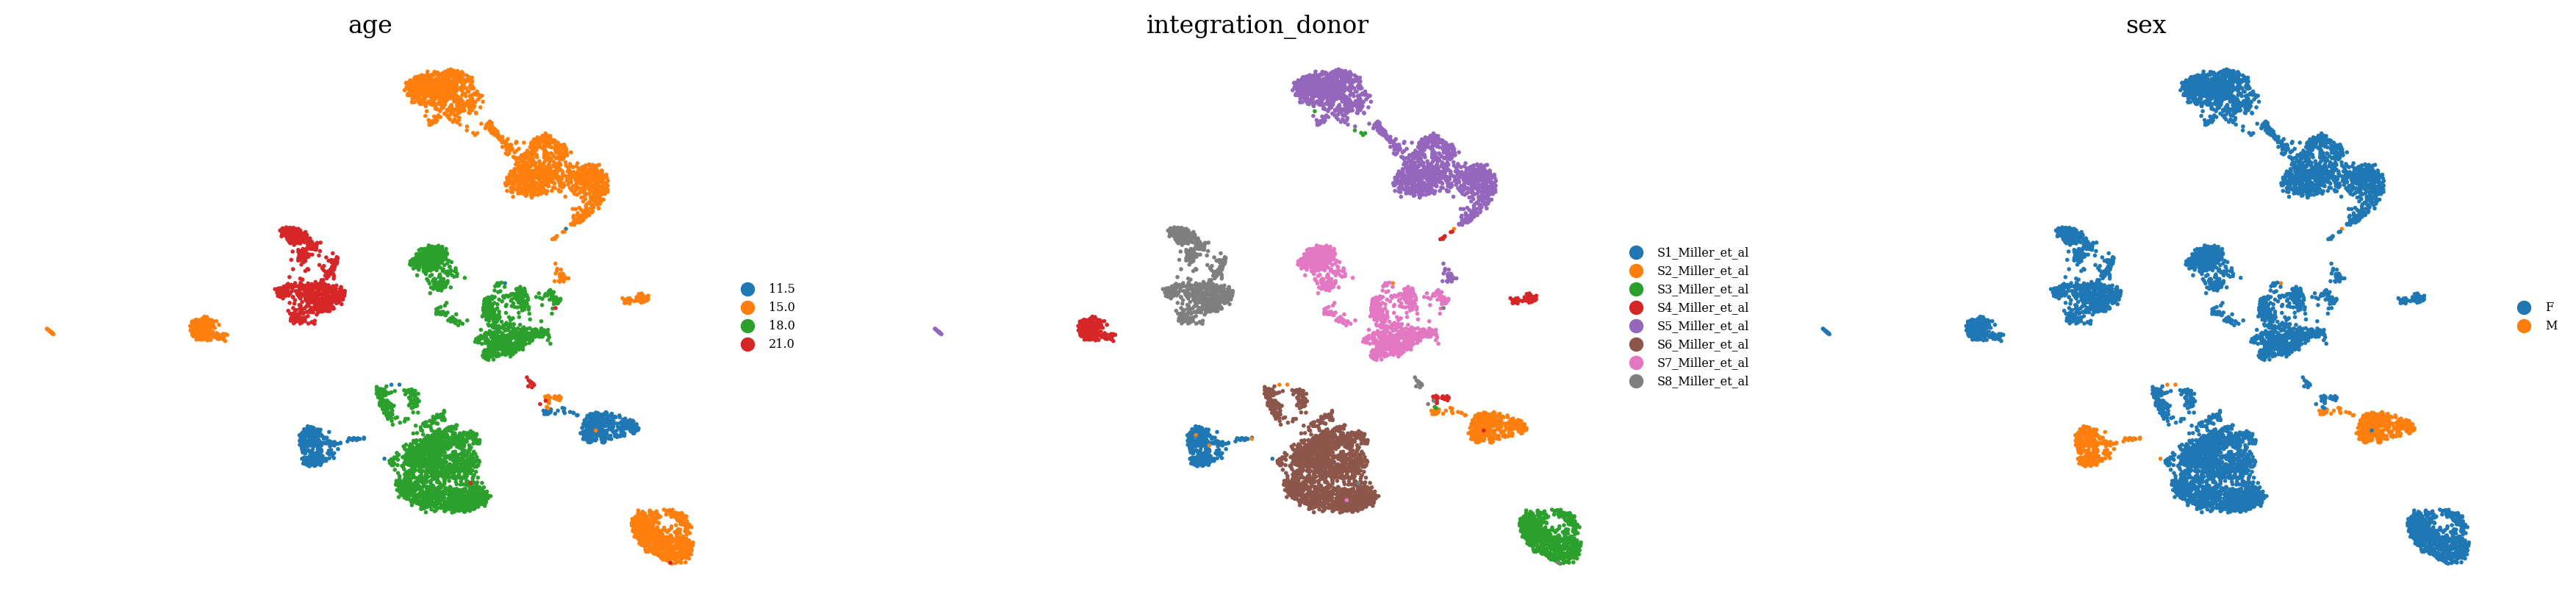

In [19]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

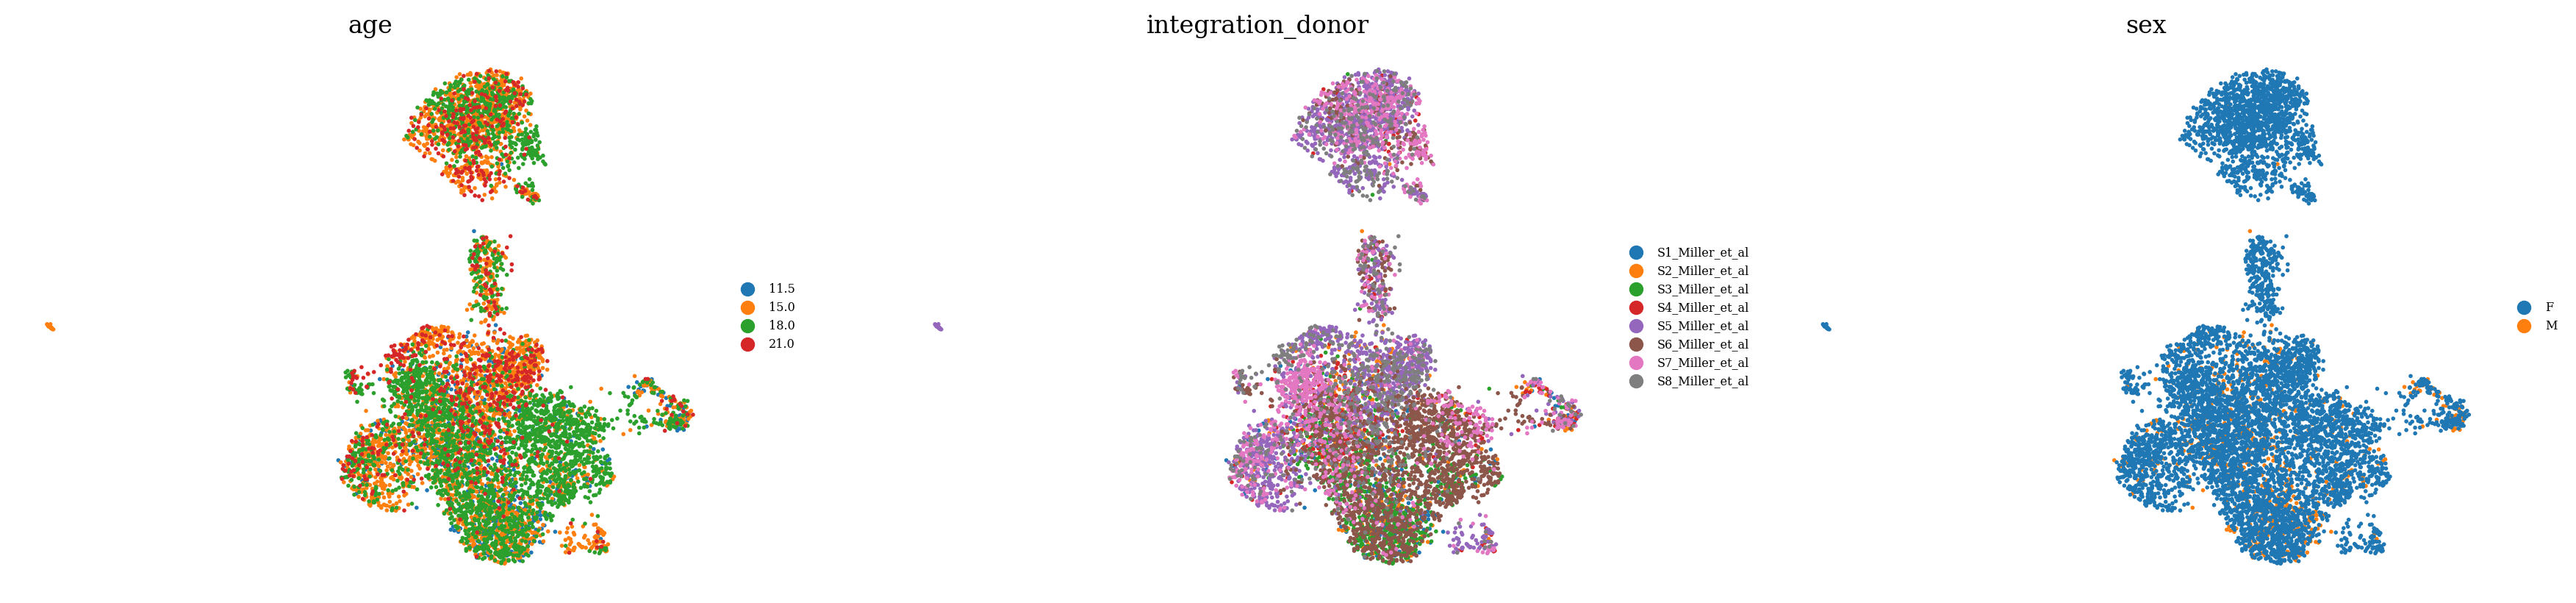

In [20]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [21]:
model.predict()

  0%|          | 0/232 [00:00<?, ?it/s]

  2%|▏         | 5/232 [00:00<00:04, 49.43it/s]

 10%|█         | 24/232 [00:00<00:01, 129.13it/s]

 18%|█▊        | 42/232 [00:00<00:01, 149.86it/s]

 26%|██▋       | 61/232 [00:00<00:01, 162.95it/s]

 34%|███▍      | 80/232 [00:00<00:00, 169.92it/s]

 43%|████▎     | 99/232 [00:00<00:00, 174.82it/s]

 51%|█████     | 118/232 [00:00<00:00, 178.07it/s]

 59%|█████▉    | 137/232 [00:00<00:00, 180.98it/s]

 67%|██████▋   | 156/232 [00:00<00:00, 182.41it/s]

 75%|███████▌  | 175/232 [00:01<00:00, 183.64it/s]

 84%|████████▎ | 194/232 [00:01<00:00, 184.10it/s]

 92%|█████████▏| 213/232 [00:01<00:00, 183.22it/s]

100%|██████████| 232/232 [00:01<00:00, 182.61it/s]

100%|██████████| 232/232 [00:01<00:00, 172.96it/s]

In [22]:
pred_adata = adata[model.test_indices]
true = pred_adata.X.A
pred = pred_adata.obsm["CPA_pred"]

In [23]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind
np.mean(r2s)

0.43472402869584736

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)